# Making an accurate detector for fake disaster tweets

Let's try to use BERT pretrained model from Google in order to obtain rich tweet texts descriptors. 

In [1]:
# Execute this to disable GPU usage
from tensorflow import config
config.set_visible_devices([], 'GPU')

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.math as tf_math
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel

### Data loading

Load the data

In [2]:
# Load csv data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Remove duplicated text from train set
train[train['text'].duplicated(keep='first')]

# Prepare train and test set
X_train, y_train = train['text'], train['target']
X_test = test['text']

## Preprocess text by using BERT pretrained model

1. Tokenize input data by using the BERT tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tweet_max_length = 280

# Tokenize train y test set according to BERT model input format
X_train_tok = tokenizer(text=X_train.tolist(),
                        max_length=tweet_max_length,
                        padding='max_length',
                        add_special_tokens=True,
                        return_attention_mask=True,
                        return_token_type_ids=True,
                        pad_to_max_length=True,
                        return_tensors='tf')

X_test_tok = tokenizer(text=X_test.tolist(),
                        max_length=tweet_max_length,
                        padding='max_length',
                        add_special_tokens=True,
                        return_attention_mask=True,
                        return_token_type_ids=True,
                        pad_to_max_length=True,
                        return_tensors='tf')

In [5]:
X_train_tok.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
X_train_tok['input_ids']

<tf.Tensor: shape=(7613, 280), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  1012, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>

In [6]:
X_train_tok['token_type_ids']

<tf.Tensor: shape=(7613, 280), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [7]:
X_train_tok['attention_mask']

<tf.Tensor: shape=(7613, 280), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

2. User BERT pretrained model for high-descriptive features extraction 

In [8]:
# Load pretrained model
def build_pre_core_BERT_model(max_length: int):
    
    # Prepare input layers with tokenized data
    input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
    token_typ_ids = Input(shape=(max_length,), dtype='int32', name='token_typ_ids')
    attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')
    
    # Load pretrained model
    bert_pre_model = TFBertModel.from_pretrained('bert-base-uncased')
    bert_pre_model.trainable = False

    sequence_output, pooled_output = bert_pre_model(input_ids, attention_masks, token_typ_ids)
    
    # Average sequence output to obtain a feture of dim 768
    out_layer = Lambda(lambda x: tf_math.reduce_mean(x, axis=1))(bert_pre_model.output[0])
    
    # Prepare model
    model = Model(inputs=(input_ids, attention_masks, token_typ_ids), outputs=out_layer)
    
    return model

In [9]:
# Compute features for train and test sets and save into disk
bert_feat_extractor = build_pre_core_BERT_model(tweet_max_length) #TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f8302ffa6c0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f8302ffa6c0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [41]:
bert_feat_extractor

In [6]:
config.list_physical_devices('GPU')

NameError: name 'config' is not defined

In [12]:
X_train_vect = bert_feat_extractor.predict([X_train_tok['input_ids'],
                                            X_train_tok['attention_mask'],
                                            X_train_tok['token_type_ids']],
                                          verbose=True)
X_test_vect = bert_feat_extractor.predict([X_test_tok['input_ids'],
                                            X_test_tok['attention_mask'],
                                            X_test_tok['token_type_ids']],
                                          verbose=True)

102/102 [==============================] - 828s 8s/step


In [16]:
# Save matrix to file
np.save('X_train_BERT_avg_hidden_states.npy', X_train_vect)
np.save('X_test_BERT_avg_hidden_states.npy', X_test_vect)

## Prediction models

Let's try non-neuran-network-based models being applying over the extracted features. Again stratified k-fold validation (`K=5`) on the train set will be done

In [3]:
# Load matrix containing BERT tokenization from file
X_train_vect = np.load('X_train_BERT_avg_hidden_states.npy')
X_test_vect = np.load('X_test_BERT_avg_hidden_states.npy')

In [4]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

### SVM Model

In [24]:
from sklearn.svm import SVC

Let's grid following parameters.

In [6]:
K = 5
svm_params = {
        'C': np.arange(0.5, 10, 0.5),
        'kernel': ['linear', 'rbf']
    }

In [6]:
kfold = StratifiedKFold(n_splits=K)

In [29]:
smv_lin_rbf_perf_metrics = []

for param in ParameterGrid(svm_params):
    
    meta = {
        'kernel': param['kernel'],
        'C': param['C'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }
    
    print('Training with parameters {}'.format(param))
    
    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit SVM model with linear or rbf reknel
        svm = SVC(kernel=param['kernel'], C=param['C'])
        svm.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = svm.predict(X_test_part)
        
        # Meassure performance metrics
        meta['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        meta['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        meta['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        meta['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        meta['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    meta['accuracy_avg'] = np.mean(meta['accuracy_fold'])
    meta['accuracy_std'] = np.std(meta['accuracy_fold'])
    
    meta['precision_avg'] = np.mean(meta['precision_fold'])
    meta['precision_std'] = np.std(meta['precision_fold'])
    
    meta['recall_avg'] = np.mean(meta['recall_fold'])
    meta['recall_std'] = np.std(meta['recall_fold'])
    
    meta['specificity_avg'] = np.mean(meta['specificity_fold'])
    meta['specificity_std'] = np.std(meta['specificity_fold'])
    
    meta['f1_score_avg'] = np.mean(meta['f1_score_fold'])
    meta['f1_score_std'] = np.std(meta['f1_score_fold'])
    
    smv_lin_rbf_perf_metrics.append(meta)

smv_lin_rbf_perf_metrics = pd.DataFrame(smv_lin_rbf_perf_metrics)

Training with parameters {'C': 0.5, 'kernel': 'linear'}
Training with parameters {'C': 0.5, 'kernel': 'rbf'}
Training with parameters {'C': 1.0, 'kernel': 'linear'}
Training with parameters {'C': 1.0, 'kernel': 'rbf'}
Training with parameters {'C': 1.5, 'kernel': 'linear'}
Training with parameters {'C': 1.5, 'kernel': 'rbf'}
Training with parameters {'C': 2.0, 'kernel': 'linear'}
Training with parameters {'C': 2.0, 'kernel': 'rbf'}
Training with parameters {'C': 2.5, 'kernel': 'linear'}
Training with parameters {'C': 2.5, 'kernel': 'rbf'}
Training with parameters {'C': 3.0, 'kernel': 'linear'}
Training with parameters {'C': 3.0, 'kernel': 'rbf'}
Training with parameters {'C': 3.5, 'kernel': 'linear'}
Training with parameters {'C': 3.5, 'kernel': 'rbf'}
Training with parameters {'C': 4.0, 'kernel': 'linear'}
Training with parameters {'C': 4.0, 'kernel': 'rbf'}
Training with parameters {'C': 4.5, 'kernel': 'linear'}
Training with parameters {'C': 4.5, 'kernel': 'rbf'}
Training with param

In [30]:
smv_lin_rbf_perf_metrics

,kernel,C,accuracy_fold,precision_fold,recall_fold,specificity_fold,f1_score_fold,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std,specificity_avg,specificity_std,f1_score_avg,f1_score_std
0,linear,0.5,"[0.7971109652002626, 0.7852921864740644, 0.790...","[0.8227611940298507, 0.7843478260869565, 0.762...","[0.6732824427480916, 0.6896024464831805, 0.744...","[0.8905529953917051, 0.857307249712313, 0.8250...","[0.7405541561712847, 0.7339300244100895, 0.753...",0.791935,0.019310,0.783503,0.024916,0.713861,0.047422,0.850764,0.022711,0.746076,0.027959
1,rbf,0.5,"[0.8108995403808273, 0.8010505581089954, 0.804...","[0.8767967145790554, 0.8128342245989305, 0.811...","[0.6519083969465649, 0.6972477064220184, 0.711...","[0.9308755760368663, 0.8791714614499425, 0.875...","[0.7478108581436076, 0.7506172839506174, 0.757...",0.808224,0.018011,0.826087,0.029108,0.702859,0.042693,0.887614,0.022534,0.758481,0.025862
2,linear,1.0,"[0.8017071569271176, 0.7852921864740644, 0.785...","[0.818018018018018, 0.7775891341256367, 0.7566...","[0.6931297709923664, 0.7003058103975535, 0.737...","[0.8836405529953917, 0.8492520138089759, 0.821...","[0.7504132231404959, 0.7369267900241352, 0.746...",0.789570,0.019297,0.776260,0.025601,0.717831,0.041624,0.843624,0.022193,0.745196,0.026447
3,rbf,1.0,"[0.8181221273801708, 0.7997373604727511, 0.808...","[0.8825910931174089, 0.8132854578096947, 0.809...","[0.665648854961832, 0.6926605504587156, 0.7232...","[0.9331797235023042, 0.8803222094361335, 0.872...","[0.7589208006962574, 0.7481420313790257, 0.764...",0.810062,0.018079,0.826171,0.031223,0.708359,0.041200,0.886693,0.024038,0.761739,0.025167
4,linear,1.5,"[0.7984241628365069, 0.7741300065659882, 0.780...","[0.8107142857142857, 0.7609427609427609, 0.748...","[0.6931297709923664, 0.691131498470948, 0.7354...","[0.8778801843317973, 0.8365937859608745, 0.813...","[0.7473251028806583, 0.7243589743589745, 0.741...",0.784973,0.018290,0.768598,0.024013,0.715690,0.041543,0.837177,0.021709,0.740485,0.025507
5,rbf,1.5,"[0.8174655285620486, 0.7984241628365069, 0.805...","[0.8823529411764706, 0.8114901256732495, 0.801...","[0.6641221374045801, 0.691131498470948, 0.7278...","[0.9331797235023042, 0.8791714614499425, 0.864...","[0.7578397212543554, 0.7464905037159372, 0.762...",0.809537,0.018126,0.824026,0.031879,0.709889,0.043402,0.884621,0.025129,0.761567,0.025532
6,linear,2.0,"[0.7964543663821405, 0.7708470124753776, 0.776...","[0.8053097345132744, 0.7537437603993344, 0.743...","[0.6946564885496184, 0.6926605504587156, 0.733...","[0.8732718894009217, 0.8296892980437284, 0.808...","[0.7459016393442623, 0.7219123505976095, 0.738...",0.784186,0.018617,0.765954,0.023648,0.717525,0.040325,0.834415,0.021136,0.740314,0.025456
7,rbf,2.0,"[0.8174655285620486, 0.7971109652002626, 0.806...","[0.8777555110220441, 0.8119349005424955, 0.798...","[0.6687022900763359, 0.6865443425076453, 0.733...","[0.9297235023041475, 0.8803222094361335, 0.860...","[0.7590987868284229, 0.743993371996686, 0.7649...",0.810326,0.017547,0.822935,0.029651,0.713557,0.044828,0.883239,0.024205,0.763184,0.025380
8,linear,2.5,"[0.7951411687458962, 0.767564018384767, 0.7754...","[0.8024691358024691, 0.75, 0.7407407407407407,...","[0.6946564885496184, 0.6880733944954128, 0.733...","[0.8709677419354839, 0.8273878020713463, 0.806...","[0.7446808510638299, 0.7177033492822965, 0.737...",0.781427,0.018339,0.762116,0.023827,0.715078,0.039085,0.831421,0.021328,0.737242,0.024934
9,rbf,2.5,"[0.8161523309258043, 0.7931713722915299, 0.804...","[0.8787878787878788, 0.8065099457504521, 0.795...","[0.6641221374045801, 0.6819571865443425, 0.732...","[0.9308755760368663, 0.8768699654775605, 0.858...","[0.7565217391304349, 0.7390223695111846, 0.762...",0.808618,0.018446,0.820476,0.031349,0.712029,0.047258,0.881397,0.025572,0.761111,0.026677


In [31]:
def plot_performance(perf_df, param, param_name=None):
    
    if not param_name:
        param_name = param

    fig, ax = plt.subplots(3,2, figsize=(16,20))

    # Plot accuracy
    ax[0, 0].fill_between(perf_df[param].values,
                     perf_df['accuracy_fold'].apply(np.min),
                     perf_df['accuracy_fold'].apply(np.max), color='lightblue')
    ax[0, 0].plot(perf_df[param].values, perf_df['accuracy_avg'].values, color='tab:blue')
    ax[0, 0].set_xlabel(param_name)
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].set_title('Accuracy evolution against {}'.format(param_name))
    
    # Plot precision
    ax[0, 1].fill_between(perf_df[param].values,
                     perf_df['precision_fold'].apply(np.min),
                     perf_df['precision_fold'].apply(np.max), color='coral')
    ax[0, 1].plot(perf_df[param].values, perf_df['precision_avg'].values, color='tab:red')
    ax[0, 1].set_xlabel(param_name)
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].set_title('Precision evolution against {}'.format(param_name))
    
    # Plot recall
    ax[1, 0].fill_between(perf_df[param].values,
                     perf_df['recall_fold'].apply(np.min),
                     perf_df['recall_fold'].apply(np.max), color='lightgreen')
    ax[1, 0].plot(perf_df[param].values, perf_df['recall_avg'].values, color='tab:green')
    ax[1, 0].set_xlabel(param_name)
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].set_title('Recall evolution against {}'.format(param_name))
    
    # Plot specificity
    ax[1, 1].fill_between(perf_df[param].values,
                     perf_df['specificity_fold'].apply(np.min),
                     perf_df['specificity_fold'].apply(np.max), color='orange')
    ax[1, 1].plot(perf_df[param].values, perf_df['specificity_avg'].values, color='tab:orange')
    ax[1, 1].set_xlabel(param_name)
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].set_title('Specificity evolution against {}'.format(param_name))

    # Plot f1 score
    ax[2, 0].fill_between(perf_df[param].values,
                     perf_df['f1_score_fold'].apply(np.min),
                     perf_df['f1_score_fold'].apply(np.max), color='lightpink')
    ax[2, 0].plot(perf_df[param].values, perf_df['f1_score_avg'].values, color='tab:pink')
    ax[2, 0].set_xlabel(param_name)
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].set_title('F1 Score evolution against {}'.format(param_name))
    
    plt.show()
    return fig, ax

Performance evolution for linear kernel

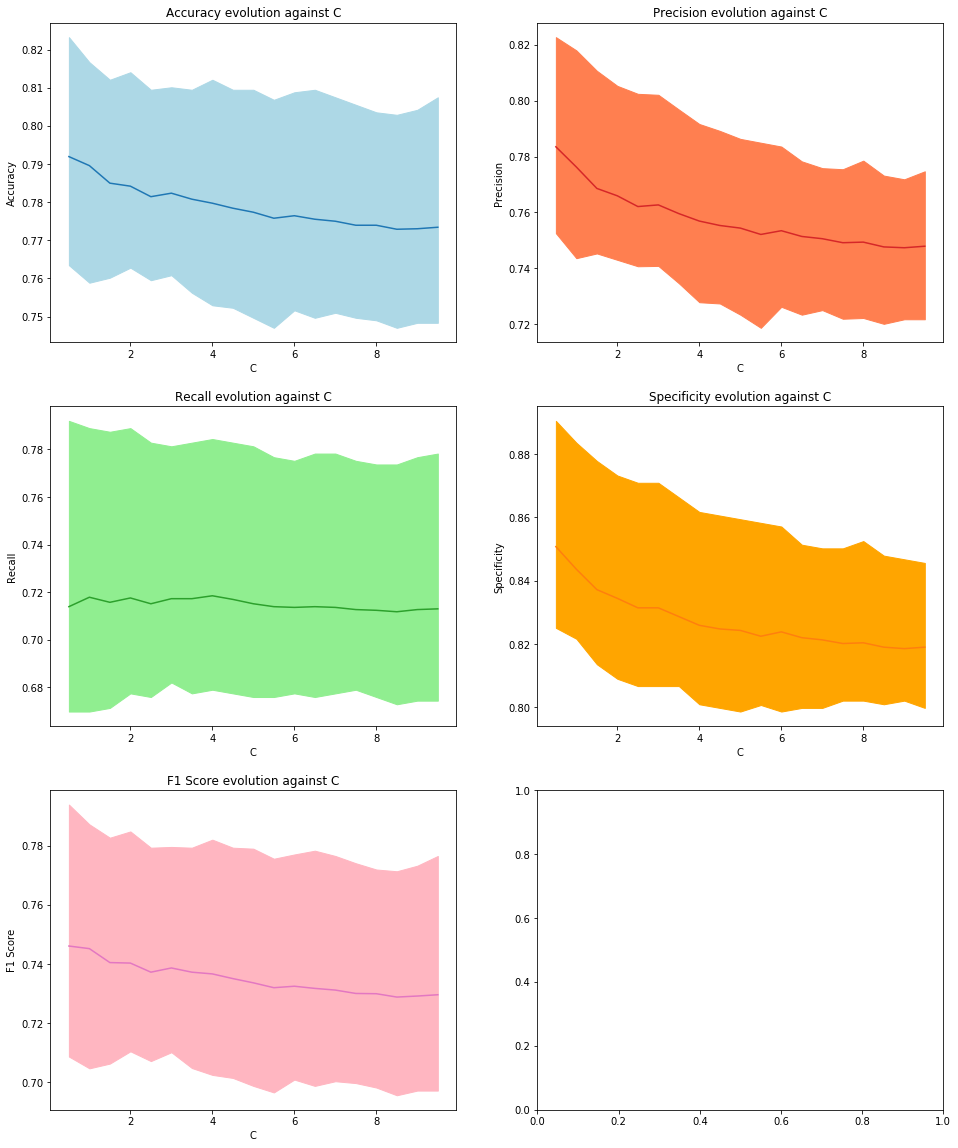

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81100985c0>,
       dtype=object))

In [33]:
plot_performance(smv_lin_rbf_perf_metrics[smv_lin_rbf_perf_metrics['kernel'] == 'linear'], param='C')

Performance evolution for `rbf` kernel

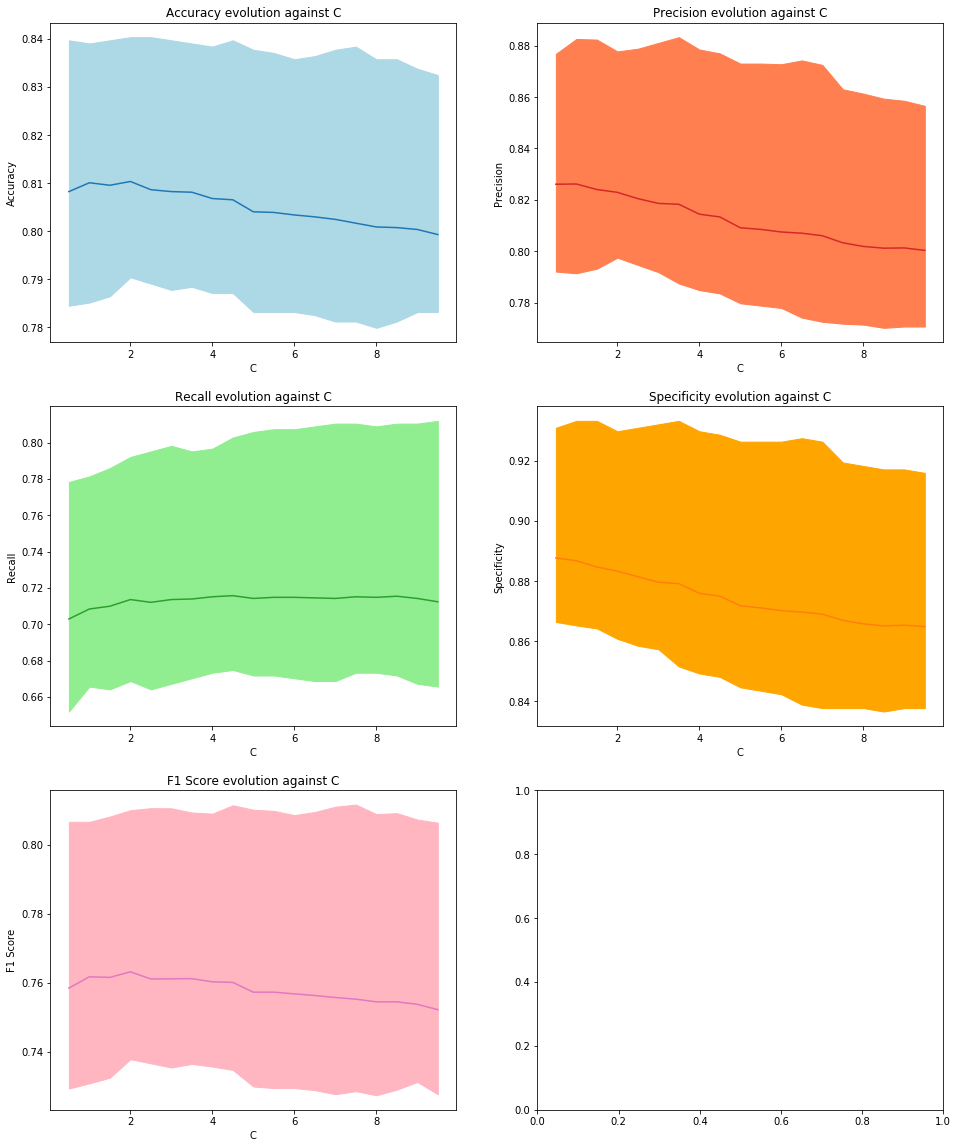

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f810a1fd438>,
       dtype=object))

In [36]:
plot_performance(smv_lin_rbf_perf_metrics[smv_lin_rbf_perf_metrics['kernel'] == 'rbf'], param='C')

Show model configuration with highest accuracy and f1-score

In [37]:
smv_lin_rbf_perf_metrics.nlargest(3, 'accuracy_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

,C,kernel,accuracy_avg,precision_avg,recall_avg,specificity_avg,f1_score_avg
7,2.0,rbf,0.810326,0.822935,0.713557,0.883239,0.763184
3,1.0,rbf,0.810062,0.826171,0.708359,0.886693,0.761739
5,1.5,rbf,0.809537,0.824026,0.709889,0.884621,0.761567


In [38]:
smv_lin_rbf_perf_metrics.nlargest(3, 'f1_score_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

,C,kernel,accuracy_avg,precision_avg,recall_avg,specificity_avg,f1_score_avg
7,2.0,rbf,0.810326,0.822935,0.713557,0.883239,0.763184
3,1.0,rbf,0.810062,0.826171,0.708359,0.886693,0.761739
5,1.5,rbf,0.809537,0.824026,0.709889,0.884621,0.761567


In [39]:
smv_lin_rbf_perf_metrics.to_csv('SVM_kernel=lin-rbf_BERT.csv', sep=';')

### Random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

Let's try with random forest based model by griding the following values:

In [10]:
rdf_params = {
        'n_estimators': list(range(25, 725, 25)),
        'max_depth': [100, 200]
        #'max_depth': [None] + list(range(50, 500, 50))
    }

In [11]:
rand_for_perf_metrics = []

for param in ParameterGrid(rdf_params):
    
    meta = {
        'n_estimators': param['n_estimators'],
        'max depth': param['max_depth'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }
    
    print('Training with parameters {}'.format(param))
    
    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit Random Forest model
        rand_forest = RandomForestClassifier(n_estimators=param['n_estimators'],
                                             max_depth=param['max_depth'])
        rand_forest.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = rand_forest.predict(X_test_part)
        
        # Meassure performance metrics
        meta['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        meta['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        meta['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        meta['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        meta['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    meta['accuracy_avg'] = np.mean(meta['accuracy_fold'])
    meta['accuracy_std'] = np.std(meta['accuracy_fold'])
    
    meta['precision_avg'] = np.mean(meta['precision_fold'])
    meta['precision_std'] = np.std(meta['precision_fold'])
    
    meta['recall_avg'] = np.mean(meta['recall_fold'])
    meta['recall_std'] = np.std(meta['recall_fold'])
    
    meta['specificity_avg'] = np.mean(meta['specificity_fold'])
    meta['specificity_std'] = np.std(meta['specificity_fold'])
    
    meta['f1_score_avg'] = np.mean(meta['f1_score_fold'])
    meta['f1_score_std'] = np.std(meta['f1_score_fold'])
    
    rand_for_perf_metrics.append(meta)

rand_for_perf_metrics = pd.DataFrame(rand_for_perf_metrics)

Training with parameters {'max_depth': 100, 'n_estimators': 25}
Training with parameters {'max_depth': 100, 'n_estimators': 50}
Training with parameters {'max_depth': 100, 'n_estimators': 75}
Training with parameters {'max_depth': 100, 'n_estimators': 100}
Training with parameters {'max_depth': 100, 'n_estimators': 125}
Training with parameters {'max_depth': 100, 'n_estimators': 150}
Training with parameters {'max_depth': 100, 'n_estimators': 175}
Training with parameters {'max_depth': 100, 'n_estimators': 200}
Training with parameters {'max_depth': 100, 'n_estimators': 225}
Training with parameters {'max_depth': 100, 'n_estimators': 250}
Training with parameters {'max_depth': 100, 'n_estimators': 275}
Training with parameters {'max_depth': 100, 'n_estimators': 300}
Training with parameters {'max_depth': 100, 'n_estimators': 325}
Training with parameters {'max_depth': 100, 'n_estimators': 350}
Training with parameters {'max_depth': 100, 'n_estimators': 375}
Training with parameters {'m

In [12]:
rand_for_perf_metrics = pd.DataFrame(rand_for_perf_metrics)

In [13]:
rand_for_perf_metrics.to_csv('Random_Forest_BERT_experiments2.csv', sep=';')

## Multilayer Perceptron

Let's try with a single neural network architecture

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

In [18]:
def build_MLP_network(input_dim, layers_dim: tuple, dropout=0.1, lr=1e-4, inner_act_func='relu', out_act_func='sigmoid', seed=10):
    
    if isinstance(dropout, (float, int)):
        dropout = (dropout,) * len(layers_dim)
    
    # Input
    input_layer = Input(shape=(input_dim,), dtype='float32')
    prev_lay = input_layer
    
    # Add intern fully-connected layers
    for i in range(len(layers_dim)):
        fully_lay = Dense(layers_dim[i], activation='relu',
                          kernel_initializer=GlorotUniform(seed=seed))(prev_lay)
        drop_layer = Dropout(dropout[i])(fully_lay)
        prev_lay = drop_layer
    
    # Add classification output layer
    output_layer = Dense(1, activation='sigmoid',
                        kernel_initializer=GlorotUniform(seed=seed))(prev_lay)
    
    # Builad & compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
    model.optimizer.lr = lr
    
    return model

Prepare and grid following configurations

In [7]:
def mulspace_limits(begin, end, factor):
    x = begin
    
    while x <= end:
        yield x
        x *= factor

In [8]:
# Configuration with only 1 hidden layer
one_hidden_lay_conf = [[x] for x in mulspace_limits(32, X_train_vect.shape[1], 2)]

# Configuration with 2 hidden layers
two_hidden_lay_conf = [[x[0], y] for x in one_hidden_lay_conf[1:] for y in mulspace_limits(32, x[0], 2)]

# Grid parameters
params = {
        'lay_conf': one_hidden_lay_conf + two_hidden_lay_conf,
        'lr': [1e-4],
        'dropout': [0.1],
        'max_epochs': [300],
        'batch_size': [100],
        'seed': [123456]
    }

In [9]:
params

{'lay_conf': [[32],
  [64],
  [128],
  [256],
  [512],
  [64, 32],
  [64, 64],
  [128, 32],
  [128, 64],
  [128, 128],
  [256, 32],
  [256, 64],
  [256, 128],
  [256, 256],
  [512, 32],
  [512, 64],
  [512, 128],
  [512, 256],
  [512, 512]],
 'lr': [0.0001],
 'dropout': [0.1],
 'max_epochs': [300],
 'batch_size': [100],
 'seed': [123456]}

In [19]:
def make_MLP_exp(X, y, params, val_split=0.1, test_size=0.2):

    mlp_perf_metrics = []

    # Split train and test sets in a single one-shot validation
    X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X, y, test_size=test_size)

    for param in ParameterGrid(params):

        meta = {
            'n_layers': len(param['lay_conf']), #if isinstance(conf, list) else 1
            'layer_conf': param['lay_conf'],
            'lr': param['lr'],
            'dropout': param['dropout'],
            'batch_size': param['batch_size']
        }

        print('Training with parameters {}'.format(param))

        # Fit MLP
        mlp_model = build_MLP_network(input_dim=X.shape[1],
                                      layers_dim=param['lay_conf'],
                                      dropout=param['dropout'], lr=param['lr'],
                                      seed=param['seed'],
                                      inner_act_func=param['inner_act_func'] if 'inner_act_func' in param else 'relu',
                                      out_act_func=param['out_act_func'] if 'out_act_func' in param else 'sigmoid')
        mlp_model.summary()
        hist = mlp_model.fit(X_train_part, y_train_part,
                             batch_size=param['batch_size'],
                             epochs=param['max_epochs'],
                              validation_split=val_split,
                              callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                       restore_best_weights=True,
                                                      min_delta=1e-7)])

        # Add train & val metrics
        meta['accuracy_train'] = hist.history['acc'][-1]
        meta['accuracy_val'] = hist.history['val_acc'][-1]
        meta['loss_train'] = hist.history['loss'][-1]
        meta['loss_val'] = hist.history['val_loss'][-1]
        meta['epochs'] = len(hist.history['val_loss'])

        # Predict over test
        y_pred = mlp_model.predict(X_test_part)
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        y_pred = y_pred.squeeze().astype('int8')

        # Meassure performance metrics
        meta['accuracy'] = metrics.accuracy_score(y_test_part, y_pred)
        meta['precision'] = metrics.precision_score(y_test_part, y_pred)
        meta['recall'] = metrics.recall_score(y_test_part, y_pred)
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        meta['specificity'] = metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1))
        meta['f1_score'] = metrics.f1_score(y_test_part, y_pred)

        mlp_perf_metrics.append(meta)

    mlp_perf_metrics = pd.DataFrame(mlp_perf_metrics)
    return mlp_perf_metrics

In [61]:
mlp_perf_metrics1=make_MLP_exp(X_train_vect, y_train.values, params)

Training with parameters {'batch_size': 100, 'dropout': 0.1, 'lay_conf': [32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_108 (Dense)            (None, 32)                24608     
_________________________________________________________________
dropout_68 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 33        
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
55/55 [==============================] - 1s 5ms/step - loss: 0.6453 - acc: 0.6313 - val_loss: 0.5793 - val_acc: 

55/55 [==============================] - 0s 6ms/step - loss: 0.3814 - acc: 0.8376 - val_loss: 0.4056 - val_acc: 0.8407
Epoch 47/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3794 - acc: 0.8384 - val_loss: 0.4029 - val_acc: 0.8342
Epoch 48/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3767 - acc: 0.8384 - val_loss: 0.4049 - val_acc: 0.8358
Epoch 49/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3771 - acc: 0.8374 - val_loss: 0.4021 - val_acc: 0.8391
Epoch 50/300
55/55 [==============================] - 0s 3ms/step - loss: 0.3758 - acc: 0.8389 - val_loss: 0.4020 - val_acc: 0.8259
Epoch 51/300
55/55 [==============================] - 0s 5ms/step - loss: 0.3748 - acc: 0.8382 - val_loss: 0.4052 - val_acc: 0.8210
Epoch 52/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3750 - acc: 0.8384 - val_loss: 0.4028 - val_acc: 0.8407
Epoch 53/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3728 - acc: 0

Epoch 1/300
55/55 [==============================] - 1s 6ms/step - loss: 0.6413 - acc: 0.6243 - val_loss: 0.5729 - val_acc: 0.7488
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5472 - acc: 0.7504 - val_loss: 0.5177 - val_acc: 0.7718
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5033 - acc: 0.7763 - val_loss: 0.4894 - val_acc: 0.7816
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4790 - acc: 0.7889 - val_loss: 0.4628 - val_acc: 0.7898
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4626 - acc: 0.7982 - val_loss: 0.4493 - val_acc: 0.7997
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4504 - acc: 0.8022 - val_loss: 0.4411 - val_acc: 0.8128
Epoch 7/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4429 - acc: 0.8093 - val_loss: 0.4334 - val_acc: 0.8194
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4361 - a

Epoch 1/300
55/55 [==============================] - 1s 6ms/step - loss: 0.6715 - acc: 0.5975 - val_loss: 0.6253 - val_acc: 0.7143
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5998 - acc: 0.7084 - val_loss: 0.5569 - val_acc: 0.7406
Epoch 3/300
55/55 [==============================] - 0s 7ms/step - loss: 0.5508 - acc: 0.7426 - val_loss: 0.5131 - val_acc: 0.7833
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5205 - acc: 0.7612 - val_loss: 0.4823 - val_acc: 0.7882
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4949 - acc: 0.7741 - val_loss: 0.4630 - val_acc: 0.7898
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4758 - acc: 0.7838 - val_loss: 0.4464 - val_acc: 0.7964
Epoch 7/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4619 - acc: 0.7927 - val_loss: 0.4376 - val_acc: 0.8079
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4538 - a

55/55 [==============================] - 1s 6ms/step - loss: 0.6545 - acc: 0.6214 - val_loss: 0.5911 - val_acc: 0.7389
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5671 - acc: 0.7289 - val_loss: 0.5221 - val_acc: 0.7619
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5098 - acc: 0.7666 - val_loss: 0.4761 - val_acc: 0.7997
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4792 - acc: 0.7833 - val_loss: 0.4519 - val_acc: 0.7964
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4605 - acc: 0.7949 - val_loss: 0.4355 - val_acc: 0.8128
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4467 - acc: 0.8042 - val_loss: 0.4277 - val_acc: 0.8079
Epoch 7/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4376 - acc: 0.8046 - val_loss: 0.4194 - val_acc: 0.8144
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4300 - acc: 0.8135 -

55/55 [==============================] - 1s 6ms/step - loss: 0.6711 - acc: 0.5950 - val_loss: 0.5742 - val_acc: 0.7455
Epoch 2/300
55/55 [==============================] - 0s 5ms/step - loss: 0.5577 - acc: 0.7356 - val_loss: 0.5046 - val_acc: 0.7816
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5005 - acc: 0.7756 - val_loss: 0.4635 - val_acc: 0.7882
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4773 - acc: 0.7869 - val_loss: 0.4410 - val_acc: 0.8030
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4568 - acc: 0.7973 - val_loss: 0.4261 - val_acc: 0.8161
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4422 - acc: 0.8051 - val_loss: 0.4189 - val_acc: 0.8144
Epoch 7/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4350 - acc: 0.8084 - val_loss: 0.4157 - val_acc: 0.8194
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4290 - acc: 0.8155 -

Epoch 1/300
55/55 [==============================] - 1s 6ms/step - loss: 0.6505 - acc: 0.6110 - val_loss: 0.5621 - val_acc: 0.7668
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5390 - acc: 0.7468 - val_loss: 0.4862 - val_acc: 0.7767
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4872 - acc: 0.7756 - val_loss: 0.4452 - val_acc: 0.7947
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4590 - acc: 0.7946 - val_loss: 0.4279 - val_acc: 0.8062
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4395 - acc: 0.8053 - val_loss: 0.4152 - val_acc: 0.8259
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4264 - acc: 0.8090 - val_loss: 0.4113 - val_acc: 0.8227
Epoch 7/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4203 - acc: 0.8155 - val_loss: 0.4060 - val_acc: 0.8210
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4139 - a

Epoch 11/300
55/55 [==============================] - 0s 7ms/step - loss: 0.3916 - acc: 0.8320 - val_loss: 0.4068 - val_acc: 0.8177
Epoch 12/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3849 - acc: 0.8352 - val_loss: 0.3999 - val_acc: 0.8374
Epoch 13/300
55/55 [==============================] - 0s 7ms/step - loss: 0.3827 - acc: 0.8354 - val_loss: 0.4040 - val_acc: 0.8276
Epoch 14/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3782 - acc: 0.8362 - val_loss: 0.3967 - val_acc: 0.8259
Epoch 15/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3710 - acc: 0.8425 - val_loss: 0.3998 - val_acc: 0.8309
Epoch 16/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3628 - acc: 0.8444 - val_loss: 0.3989 - val_acc: 0.8342
Epoch 17/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3597 - acc: 0.8458 - val_loss: 0.3980 - val_acc: 0.8342
Epoch 18/300
55/55 [==============================] - 0s 6ms/step - loss: 0.

55/55 [==============================] - 1s 7ms/step - loss: 0.5992 - acc: 0.6822 - val_loss: 0.5057 - val_acc: 0.7734
Epoch 2/300
55/55 [==============================] - 0s 5ms/step - loss: 0.4881 - acc: 0.7834 - val_loss: 0.4388 - val_acc: 0.8079
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4528 - acc: 0.7993 - val_loss: 0.4192 - val_acc: 0.8194
Epoch 4/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4329 - acc: 0.8124 - val_loss: 0.4100 - val_acc: 0.8177
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4134 - acc: 0.8234 - val_loss: 0.4051 - val_acc: 0.8325
Epoch 6/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4063 - acc: 0.8243 - val_loss: 0.4063 - val_acc: 0.8243
Epoch 7/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3977 - acc: 0.8292 - val_loss: 0.3997 - val_acc: 0.8259
Epoch 8/300
55/55 [==============================] - 0s 7ms/step - loss: 0.3906 - acc: 0.8312 -

In [62]:
mlp_perf_metrics1

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,1,[32],0.0001,0.1,100,0.838351,0.829228,0.378801,0.400439,63,0.806303,0.820467,0.700920,0.885189,0.755997
1,1,[64],0.0001,0.1,100,0.839263,0.837438,0.368426,0.403811,58,0.806303,0.812609,0.711656,0.877153,0.758790
2,1,[128],0.0001,0.1,100,0.839810,0.827586,0.371238,0.402153,36,0.812869,0.829443,0.708589,0.890930,0.764268
3,1,[256],0.0001,0.1,100,0.843094,0.832512,0.363093,0.402502,33,0.808930,0.836127,0.688650,0.898967,0.755257
4,1,[512],0.0001,0.1,100,0.844007,0.821018,0.355342,0.402125,29,0.807617,0.816578,0.710123,0.880597,0.759639
5,2,"[64, 32]",0.0001,0.1,100,0.843094,0.824302,0.367635,0.397961,43,0.809586,0.832721,0.694785,0.895522,0.757525
6,2,"[64, 64]",0.0001,0.1,100,0.843094,0.829228,0.370643,0.394023,33,0.807617,0.829358,0.693252,0.893226,0.755221
7,2,"[128, 32]",0.0001,0.1,100,0.849115,0.829228,0.358455,0.399094,34,0.807617,0.828154,0.694785,0.892078,0.755630
8,2,"[128, 64]",0.0001,0.1,100,0.843642,0.822660,0.359424,0.406357,29,0.807617,0.821109,0.703988,0.885189,0.758051
9,2,"[128, 128]",0.0001,0.1,100,0.853859,0.822660,0.343919,0.400544,28,0.810243,0.830601,0.699387,0.893226,0.759367


In [63]:
mlp_perf_metrics1.to_csv('mlp_perf_metrics1.csv', sep=';')

Let's analyze the best architectures

In [66]:
mlp_perf_metrics1.nlargest(5, 'accuracy')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
17,2,"[512, 256]",0.0001,0.1,100,0.854224,0.821018,0.342069,0.412827,15,0.814839,0.832734,0.710123,0.893226,0.766556
10,2,"[256, 32]",0.0001,0.1,100,0.840723,0.829228,0.372808,0.395154,22,0.814183,0.843575,0.694785,0.903559,0.761985
2,1,[128],0.0001,0.1,100,0.839810,0.827586,0.371238,0.402153,36,0.812869,0.829443,0.708589,0.890930,0.764268
9,2,"[128, 128]",0.0001,0.1,100,0.853859,0.822660,0.343919,0.400544,28,0.810243,0.830601,0.699387,0.893226,0.759367
13,2,"[256, 256]",0.0001,0.1,100,0.846926,0.834154,0.360357,0.401359,17,0.810243,0.815652,0.719325,0.878301,0.764466


In [67]:
mlp_perf_metrics1.nlargest(5, 'f1_score')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
17,2,"[512, 256]",0.0001,0.1,100,0.854224,0.821018,0.342069,0.412827,15,0.814839,0.832734,0.710123,0.893226,0.766556
13,2,"[256, 256]",0.0001,0.1,100,0.846926,0.834154,0.360357,0.401359,17,0.810243,0.815652,0.719325,0.878301,0.764466
2,1,[128],0.0001,0.1,100,0.839810,0.827586,0.371238,0.402153,36,0.812869,0.829443,0.708589,0.890930,0.764268
16,2,"[512, 128]",0.0001,0.1,100,0.852764,0.827586,0.344633,0.402671,17,0.808273,0.810345,0.720859,0.873708,0.762987
10,2,"[256, 32]",0.0001,0.1,100,0.840723,0.829228,0.372808,0.395154,22,0.814183,0.843575,0.694785,0.903559,0.761985


For the best architectures, let's try to grid other values for `batch_size`

In [10]:
best_arch1 = [[512, 256],
             [256, 256],
             [128],
             [512, 128],
             [256, 32],
             [128, 128],
             [256, 256]]

# Grid parameters
params2 = {
        'lay_conf': best_arch1,
        'lr': [1e-4],
        'dropout': [0.1],
        'max_epochs': [300],
        'batch_size': [None, 1, 10, 20, 50, 70, 200, 350, 500, 700],
        'seed': [123456]
    }

In [70]:
mlp_perf_metrics2 = make_MLP_exp(X_train_vect, y_train.values, params2)

Training with parameters {'batch_size': None, 'dropout': 0.1, 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_160 (Dense)            (None, 512)               393728    
_________________________________________________________________
dropout_101 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_102 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 

172/172 [==============================] - 0s 1ms/step - loss: 0.4092 - acc: 0.8196 - val_loss: 0.4222 - val_acc: 0.8194
Epoch 8/300
172/172 [==============================] - 0s 2ms/step - loss: 0.4025 - acc: 0.8272 - val_loss: 0.4363 - val_acc: 0.8161
Epoch 9/300
172/172 [==============================] - 0s 2ms/step - loss: 0.3934 - acc: 0.8294 - val_loss: 0.4194 - val_acc: 0.8210
Epoch 10/300
172/172 [==============================] - 0s 2ms/step - loss: 0.3894 - acc: 0.8290 - val_loss: 0.4191 - val_acc: 0.8161
Epoch 11/300
172/172 [==============================] - 0s 2ms/step - loss: 0.3848 - acc: 0.8356 - val_loss: 0.4280 - val_acc: 0.8128
Epoch 12/300
172/172 [==============================] - 0s 2ms/step - loss: 0.3783 - acc: 0.8354 - val_loss: 0.4180 - val_acc: 0.8161
Epoch 13/300
172/172 [==============================] - 0s 2ms/step - loss: 0.3766 - acc: 0.8387 - val_loss: 0.4158 - val_acc: 0.8194
Epoch 14/300
172/172 [==============================] - 0s 1ms/step - loss: 0

5481/5481 [==============================] - 9s 2ms/step - loss: 0.3403 - acc: 0.8535 - val_loss: 0.5006 - val_acc: 0.8030
Epoch 12/300
5481/5481 [==============================] - 9s 2ms/step - loss: 0.3350 - acc: 0.8571 - val_loss: 0.4217 - val_acc: 0.8161
Training with parameters {'batch_size': 1, 'dropout': 0.1, 'lay_conf': [512, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_188 (Dense)            (None, 512)               393728    
_________________________________________________________________
dropout_119 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_189 (Dense)            (None, 128)               65664   

5481/5481 [==============================] - 11s 2ms/step - loss: 0.4897 - acc: 0.7719 - val_loss: 0.4385 - val_acc: 0.7980
Epoch 2/300
5481/5481 [==============================] - 10s 2ms/step - loss: 0.4302 - acc: 0.8137 - val_loss: 0.4208 - val_acc: 0.8161
Epoch 3/300
5481/5481 [==============================] - 10s 2ms/step - loss: 0.4103 - acc: 0.8176 - val_loss: 0.4177 - val_acc: 0.8177
Epoch 4/300
5481/5481 [==============================] - 10s 2ms/step - loss: 0.3975 - acc: 0.8234 - val_loss: 0.4246 - val_acc: 0.8144
Epoch 5/300
5481/5481 [==============================] - 10s 2ms/step - loss: 0.3824 - acc: 0.8329 - val_loss: 0.4191 - val_acc: 0.8144
Epoch 6/300
5481/5481 [==============================] - 10s 2ms/step - loss: 0.3631 - acc: 0.8371 - val_loss: 0.4290 - val_acc: 0.8095
Epoch 7/300
5481/5481 [==============================] - 10s 2ms/step - loss: 0.3448 - acc: 0.8486 - val_loss: 0.4321 - val_acc: 0.8062
Epoch 8/300
5481/5481 [==============================] - 10s

549/549 [==============================] - 1s 2ms/step - loss: 0.3794 - acc: 0.8373 - val_loss: 0.4293 - val_acc: 0.8128
Epoch 10/300
549/549 [==============================] - 1s 1ms/step - loss: 0.3718 - acc: 0.8385 - val_loss: 0.4662 - val_acc: 0.8046
Epoch 11/300
549/549 [==============================] - 1s 1ms/step - loss: 0.3657 - acc: 0.8478 - val_loss: 0.4205 - val_acc: 0.8161
Epoch 12/300
549/549 [==============================] - 1s 1ms/step - loss: 0.3584 - acc: 0.8477 - val_loss: 0.4246 - val_acc: 0.8144
Training with parameters {'batch_size': 10, 'dropout': 0.1, 'lay_conf': [128, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_214 (Dense)            (None, 128)               98432  

Epoch 4/300
275/275 [==============================] - 0s 2ms/step - loss: 0.4084 - acc: 0.8227 - val_loss: 0.4192 - val_acc: 0.8194
Epoch 5/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3979 - acc: 0.8252 - val_loss: 0.4170 - val_acc: 0.8227
Epoch 6/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3831 - acc: 0.8320 - val_loss: 0.4153 - val_acc: 0.8309
Epoch 7/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3756 - acc: 0.8415 - val_loss: 0.4120 - val_acc: 0.8325
Epoch 8/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3641 - acc: 0.8398 - val_loss: 0.4222 - val_acc: 0.8161
Epoch 9/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3484 - acc: 0.8484 - val_loss: 0.4638 - val_acc: 0.8062
Epoch 10/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3367 - acc: 0.8515 - val_loss: 0.4435 - val_acc: 0.8046
Epoch 11/300
275/275 [==============================] - 0s 2ms/step 

275/275 [==============================] - 1s 2ms/step - loss: 0.5758 - acc: 0.7157 - val_loss: 0.5031 - val_acc: 0.7750
Epoch 2/300
275/275 [==============================] - 0s 1ms/step - loss: 0.4699 - acc: 0.7904 - val_loss: 0.4539 - val_acc: 0.8046
Epoch 3/300
275/275 [==============================] - 0s 1ms/step - loss: 0.4450 - acc: 0.7993 - val_loss: 0.4391 - val_acc: 0.8112
Epoch 4/300
275/275 [==============================] - 0s 2ms/step - loss: 0.4311 - acc: 0.8101 - val_loss: 0.4373 - val_acc: 0.8128
Epoch 5/300
275/275 [==============================] - 0s 2ms/step - loss: 0.4210 - acc: 0.8194 - val_loss: 0.4343 - val_acc: 0.8079
Epoch 6/300
275/275 [==============================] - 0s 2ms/step - loss: 0.4097 - acc: 0.8221 - val_loss: 0.4241 - val_acc: 0.8112
Epoch 7/300
275/275 [==============================] - 0s 2ms/step - loss: 0.3983 - acc: 0.8285 - val_loss: 0.4324 - val_acc: 0.8030
Epoch 8/300
275/275 [==============================] - 0s 1ms/step - loss: 0.3969

110/110 [==============================] - 0s 1ms/step - loss: 0.3960 - acc: 0.8269 - val_loss: 0.4225 - val_acc: 0.8276
Epoch 17/300
110/110 [==============================] - 0s 1ms/step - loss: 0.3947 - acc: 0.8309 - val_loss: 0.4229 - val_acc: 0.8161
Epoch 18/300
110/110 [==============================] - 0s 1ms/step - loss: 0.3918 - acc: 0.8300 - val_loss: 0.4253 - val_acc: 0.8112
Epoch 19/300
110/110 [==============================] - 0s 1ms/step - loss: 0.3896 - acc: 0.8309 - val_loss: 0.4197 - val_acc: 0.8210
Epoch 20/300
110/110 [==============================] - 0s 1ms/step - loss: 0.3874 - acc: 0.8300 - val_loss: 0.4196 - val_acc: 0.8210
Epoch 21/300
110/110 [==============================] - 0s 1ms/step - loss: 0.3851 - acc: 0.8327 - val_loss: 0.4290 - val_acc: 0.8095
Epoch 22/300
110/110 [==============================] - 0s 1ms/step - loss: 0.3810 - acc: 0.8320 - val_loss: 0.4216 - val_acc: 0.8128
Epoch 23/300
110/110 [==============================] - 0s 2ms/step - loss:

110/110 [==============================] - 0s 2ms/step - loss: 0.3826 - acc: 0.8347 - val_loss: 0.4166 - val_acc: 0.8276
Epoch 11/300
110/110 [==============================] - 0s 2ms/step - loss: 0.3773 - acc: 0.8376 - val_loss: 0.4168 - val_acc: 0.8177
Epoch 12/300
110/110 [==============================] - 0s 2ms/step - loss: 0.3678 - acc: 0.8427 - val_loss: 0.4220 - val_acc: 0.8210
Epoch 13/300
110/110 [==============================] - 0s 2ms/step - loss: 0.3634 - acc: 0.8435 - val_loss: 0.4163 - val_acc: 0.8194
Epoch 14/300
110/110 [==============================] - 0s 2ms/step - loss: 0.3553 - acc: 0.8478 - val_loss: 0.4298 - val_acc: 0.8095
Epoch 15/300
110/110 [==============================] - 0s 2ms/step - loss: 0.3517 - acc: 0.8467 - val_loss: 0.4190 - val_acc: 0.8177
Epoch 16/300
110/110 [==============================] - 0s 2ms/step - loss: 0.3409 - acc: 0.8504 - val_loss: 0.4238 - val_acc: 0.8144
Epoch 17/300
110/110 [==============================] - 0s 2ms/step - loss:

Epoch 19/300
79/79 [==============================] - 0s 2ms/step - loss: 0.3342 - acc: 0.8548 - val_loss: 0.4274 - val_acc: 0.8194
Epoch 20/300
79/79 [==============================] - 0s 2ms/step - loss: 0.3260 - acc: 0.8588 - val_loss: 0.4364 - val_acc: 0.7997
Epoch 21/300
79/79 [==============================] - 0s 2ms/step - loss: 0.3187 - acc: 0.8615 - val_loss: 0.4463 - val_acc: 0.8079
Training with parameters {'batch_size': 70, 'dropout': 0.1, 'lay_conf': [128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(None, 768)]             0         
_________________________________________________________________
dense_266 (Dense)            (None, 128)               98432     
_________________________________________________________________
dropout_170 (Dropout)        (None, 128)               0      

79/79 [==============================] - 1s 5ms/step - loss: 0.6095 - acc: 0.6676 - val_loss: 0.5133 - val_acc: 0.7783
Epoch 2/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4912 - acc: 0.7800 - val_loss: 0.4602 - val_acc: 0.7947
Epoch 3/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4507 - acc: 0.8055 - val_loss: 0.4465 - val_acc: 0.8128
Epoch 4/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4330 - acc: 0.8088 - val_loss: 0.4310 - val_acc: 0.8194
Epoch 5/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4224 - acc: 0.8176 - val_loss: 0.4254 - val_acc: 0.8276
Epoch 6/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4160 - acc: 0.8203 - val_loss: 0.4315 - val_acc: 0.8079
Epoch 7/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4033 - acc: 0.8298 - val_loss: 0.4233 - val_acc: 0.8144
Epoch 8/300
79/79 [==============================] - 0s 2ms/step - loss: 0.3970 - acc: 0.8305 -

Epoch 3/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4839 - acc: 0.7811 - val_loss: 0.4637 - val_acc: 0.8079
Epoch 4/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4617 - acc: 0.7907 - val_loss: 0.4497 - val_acc: 0.8062
Epoch 5/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4429 - acc: 0.8035 - val_loss: 0.4451 - val_acc: 0.8062
Epoch 6/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4342 - acc: 0.8110 - val_loss: 0.4376 - val_acc: 0.8095
Epoch 7/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4248 - acc: 0.8130 - val_loss: 0.4331 - val_acc: 0.8112
Epoch 8/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4175 - acc: 0.8152 - val_loss: 0.4292 - val_acc: 0.8128
Epoch 9/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4132 - acc: 0.8154 - val_loss: 0.4295 - val_acc: 0.8079
Epoch 10/300
79/79 [==============================] - 0s 2ms/step - loss: 0.4081 - 

Epoch 1/300
28/28 [==============================] - 0s 6ms/step - loss: 0.6426 - acc: 0.6192 - val_loss: 0.5728 - val_acc: 0.7521
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 0.5430 - acc: 0.7508 - val_loss: 0.4991 - val_acc: 0.7849
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.4876 - acc: 0.7772 - val_loss: 0.4675 - val_acc: 0.7980
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.4605 - acc: 0.7935 - val_loss: 0.4589 - val_acc: 0.8112
Epoch 5/300
28/28 [==============================] - 0s 3ms/step - loss: 0.4394 - acc: 0.8101 - val_loss: 0.4418 - val_acc: 0.8095
Epoch 6/300
28/28 [==============================] - 0s 3ms/step - loss: 0.4276 - acc: 0.8124 - val_loss: 0.4327 - val_acc: 0.8161
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.4200 - acc: 0.8157 - val_loss: 0.4292 - val_acc: 0.8194
Epoch 8/300
28/28 [==============================] - 0s 3ms/step - loss: 0.4105 - a

28/28 [==============================] - 0s 5ms/step - loss: 0.6335 - acc: 0.6539 - val_loss: 0.5973 - val_acc: 0.7307
Epoch 2/300
28/28 [==============================] - 0s 2ms/step - loss: 0.5771 - acc: 0.7234 - val_loss: 0.5570 - val_acc: 0.7603
Epoch 3/300
28/28 [==============================] - 0s 2ms/step - loss: 0.5438 - acc: 0.7524 - val_loss: 0.5242 - val_acc: 0.7833
Epoch 4/300
28/28 [==============================] - 0s 2ms/step - loss: 0.5200 - acc: 0.7630 - val_loss: 0.5055 - val_acc: 0.7915
Epoch 5/300
28/28 [==============================] - 0s 2ms/step - loss: 0.5015 - acc: 0.7760 - val_loss: 0.4905 - val_acc: 0.7898
Epoch 6/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4901 - acc: 0.7805 - val_loss: 0.4800 - val_acc: 0.7964
Epoch 7/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4766 - acc: 0.7913 - val_loss: 0.4727 - val_acc: 0.7947
Epoch 8/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4701 - acc: 0.7895 -

Epoch 14/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4180 - acc: 0.8183 - val_loss: 0.4309 - val_acc: 0.8079
Epoch 15/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4158 - acc: 0.8205 - val_loss: 0.4275 - val_acc: 0.8210
Epoch 16/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4113 - acc: 0.8177 - val_loss: 0.4270 - val_acc: 0.8128
Epoch 17/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4079 - acc: 0.8230 - val_loss: 0.4293 - val_acc: 0.8030
Epoch 18/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4063 - acc: 0.8201 - val_loss: 0.4235 - val_acc: 0.8259
Epoch 19/300
28/28 [==============================] - 0s 2ms/step - loss: 0.4022 - acc: 0.8250 - val_loss: 0.4235 - val_acc: 0.8177
Epoch 20/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3986 - acc: 0.8247 - val_loss: 0.4315 - val_acc: 0.8062
Epoch 21/300
28/28 [==============================] - 0s 2ms/step - loss: 0.

Epoch 6/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4586 - acc: 0.7971 - val_loss: 0.4568 - val_acc: 0.8095
Epoch 7/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4431 - acc: 0.8066 - val_loss: 0.4454 - val_acc: 0.8079
Epoch 8/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4352 - acc: 0.8073 - val_loss: 0.4425 - val_acc: 0.8144
Epoch 9/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4250 - acc: 0.8155 - val_loss: 0.4398 - val_acc: 0.8128
Epoch 10/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4196 - acc: 0.8216 - val_loss: 0.4405 - val_acc: 0.8112
Epoch 11/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4170 - acc: 0.8161 - val_loss: 0.4286 - val_acc: 0.8227
Epoch 12/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4110 - acc: 0.8241 - val_loss: 0.4276 - val_acc: 0.8177
Epoch 13/300
16/16 [==============================] - 0s 4ms/step - loss: 0.4064

16/16 [==============================] - 0s 3ms/step - loss: 0.3959 - acc: 0.8292 - val_loss: 0.4310 - val_acc: 0.8128
Epoch 47/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3952 - acc: 0.8298 - val_loss: 0.4255 - val_acc: 0.8194
Epoch 48/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3960 - acc: 0.8312 - val_loss: 0.4254 - val_acc: 0.8128
Epoch 49/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3936 - acc: 0.8305 - val_loss: 0.4263 - val_acc: 0.8128
Epoch 50/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3913 - acc: 0.8318 - val_loss: 0.4249 - val_acc: 0.8128
Epoch 51/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3913 - acc: 0.8325 - val_loss: 0.4237 - val_acc: 0.8194
Epoch 52/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3895 - acc: 0.8318 - val_loss: 0.4264 - val_acc: 0.8112
Epoch 53/300
16/16 [==============================] - 0s 3ms/step - loss: 0.3900 - acc: 0

Epoch 3/300
16/16 [==============================] - 0s 3ms/step - loss: 0.6090 - acc: 0.7123 - val_loss: 0.5848 - val_acc: 0.7586
Epoch 4/300
16/16 [==============================] - 0s 3ms/step - loss: 0.5814 - acc: 0.7260 - val_loss: 0.5552 - val_acc: 0.7652
Epoch 5/300
16/16 [==============================] - 0s 3ms/step - loss: 0.5550 - acc: 0.7417 - val_loss: 0.5300 - val_acc: 0.7750
Epoch 6/300
16/16 [==============================] - 0s 3ms/step - loss: 0.5327 - acc: 0.7583 - val_loss: 0.5110 - val_acc: 0.7882
Epoch 7/300
16/16 [==============================] - 0s 3ms/step - loss: 0.5110 - acc: 0.7694 - val_loss: 0.4928 - val_acc: 0.7947
Epoch 8/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4973 - acc: 0.7730 - val_loss: 0.4874 - val_acc: 0.7915
Epoch 9/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4851 - acc: 0.7871 - val_loss: 0.4698 - val_acc: 0.8046
Epoch 10/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4759 - 

16/16 [==============================] - 0s 3ms/step - loss: 0.4290 - acc: 0.8126 - val_loss: 0.4378 - val_acc: 0.8144
Epoch 14/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4233 - acc: 0.8121 - val_loss: 0.4364 - val_acc: 0.8161
Epoch 15/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4181 - acc: 0.8168 - val_loss: 0.4411 - val_acc: 0.8128
Epoch 16/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4157 - acc: 0.8174 - val_loss: 0.4328 - val_acc: 0.8194
Epoch 17/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4107 - acc: 0.8212 - val_loss: 0.4292 - val_acc: 0.8161
Epoch 18/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4109 - acc: 0.8205 - val_loss: 0.4295 - val_acc: 0.8177
Epoch 19/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4017 - acc: 0.8250 - val_loss: 0.4278 - val_acc: 0.8210
Epoch 20/300
16/16 [==============================] - 0s 3ms/step - loss: 0.4008 - acc: 0

11/11 [==============================] - 0s 4ms/step - loss: 0.3461 - acc: 0.8520 - val_loss: 0.4227 - val_acc: 0.8259
Epoch 49/300
11/11 [==============================] - 0s 4ms/step - loss: 0.3366 - acc: 0.8548 - val_loss: 0.4236 - val_acc: 0.8227
Training with parameters {'batch_size': 500, 'dropout': 0.1, 'lay_conf': [128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_122 (InputLayer)       [(None, 768)]             0         
_________________________________________________________________
dense_326 (Dense)            (None, 128)               98432     
_________________________________________________________________
dropout_209 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_327 (Dense)            (None, 1)                 129       
Total p

11/11 [==============================] - 0s 5ms/step - loss: 0.4626 - acc: 0.7973 - val_loss: 0.4592 - val_acc: 0.7964
Epoch 10/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4513 - acc: 0.8030 - val_loss: 0.4519 - val_acc: 0.8046
Epoch 11/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4425 - acc: 0.8061 - val_loss: 0.4470 - val_acc: 0.8095
Epoch 12/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4353 - acc: 0.8077 - val_loss: 0.4447 - val_acc: 0.8161
Epoch 13/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4306 - acc: 0.8092 - val_loss: 0.4414 - val_acc: 0.8144
Epoch 14/300
11/11 [==============================] - 0s 5ms/step - loss: 0.4243 - acc: 0.8159 - val_loss: 0.4373 - val_acc: 0.8177
Epoch 15/300
11/11 [==============================] - 0s 5ms/step - loss: 0.4207 - acc: 0.8165 - val_loss: 0.4341 - val_acc: 0.8161
Epoch 16/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4167 - acc: 0

11/11 [==============================] - 0s 4ms/step - loss: 0.5725 - acc: 0.7351 - val_loss: 0.5567 - val_acc: 0.7701
Epoch 7/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5554 - acc: 0.7427 - val_loss: 0.5356 - val_acc: 0.7734
Epoch 8/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5351 - acc: 0.7526 - val_loss: 0.5180 - val_acc: 0.7833
Epoch 9/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5173 - acc: 0.7687 - val_loss: 0.5021 - val_acc: 0.7931
Epoch 10/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5051 - acc: 0.7694 - val_loss: 0.4900 - val_acc: 0.7947
Epoch 11/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4916 - acc: 0.7796 - val_loss: 0.4806 - val_acc: 0.7964
Epoch 12/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4802 - acc: 0.7836 - val_loss: 0.4745 - val_acc: 0.7997
Epoch 13/300
11/11 [==============================] - 0s 4ms/step - loss: 0.4717 - acc: 0.78

Epoch 1/300
11/11 [==============================] - 0s 11ms/step - loss: 0.7515 - acc: 0.4621 - val_loss: 0.6739 - val_acc: 0.6092
Epoch 2/300
11/11 [==============================] - 0s 4ms/step - loss: 0.6594 - acc: 0.5977 - val_loss: 0.6455 - val_acc: 0.5534
Epoch 3/300
11/11 [==============================] - 0s 4ms/step - loss: 0.6254 - acc: 0.6508 - val_loss: 0.6010 - val_acc: 0.7340
Epoch 4/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5959 - acc: 0.7050 - val_loss: 0.5712 - val_acc: 0.7438
Epoch 5/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5698 - acc: 0.7225 - val_loss: 0.5482 - val_acc: 0.7586
Epoch 6/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5469 - acc: 0.7393 - val_loss: 0.5246 - val_acc: 0.7750
Epoch 7/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5240 - acc: 0.7614 - val_loss: 0.5040 - val_acc: 0.7849
Epoch 8/300
11/11 [==============================] - 0s 4ms/step - loss: 0.5043 - 

8/8 [==============================] - 0s 5ms/step - loss: 0.4374 - acc: 0.8041 - val_loss: 0.4436 - val_acc: 0.8095
Epoch 20/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4352 - acc: 0.8081 - val_loss: 0.4453 - val_acc: 0.8144
Epoch 21/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4299 - acc: 0.8095 - val_loss: 0.4391 - val_acc: 0.8144
Epoch 22/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4256 - acc: 0.8121 - val_loss: 0.4409 - val_acc: 0.8161
Epoch 23/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4231 - acc: 0.8139 - val_loss: 0.4382 - val_acc: 0.8144
Epoch 24/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4229 - acc: 0.8130 - val_loss: 0.4362 - val_acc: 0.8177
Epoch 25/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4161 - acc: 0.8177 - val_loss: 0.4351 - val_acc: 0.8144
Epoch 26/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4133 - acc: 0.8148 - val_loss

8/8 [==============================] - 0s 4ms/step - loss: 0.3846 - acc: 0.8321 - val_loss: 0.4230 - val_acc: 0.8112
Epoch 88/300
8/8 [==============================] - 0s 4ms/step - loss: 0.3865 - acc: 0.8365 - val_loss: 0.4231 - val_acc: 0.8095
Epoch 89/300
8/8 [==============================] - 0s 4ms/step - loss: 0.3846 - acc: 0.8340 - val_loss: 0.4226 - val_acc: 0.8112
Epoch 90/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3831 - acc: 0.8338 - val_loss: 0.4230 - val_acc: 0.8112
Epoch 91/300
8/8 [==============================] - 0s 4ms/step - loss: 0.3836 - acc: 0.8316 - val_loss: 0.4220 - val_acc: 0.8144
Epoch 92/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3825 - acc: 0.8347 - val_loss: 0.4226 - val_acc: 0.8112
Epoch 93/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3821 - acc: 0.8349 - val_loss: 0.4228 - val_acc: 0.8112
Epoch 94/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3808 - acc: 0.8343 - val_loss

8/8 [==============================] - 0s 5ms/step - loss: 0.3994 - acc: 0.8296 - val_loss: 0.4254 - val_acc: 0.8161
Epoch 47/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3953 - acc: 0.8311 - val_loss: 0.4250 - val_acc: 0.8144
Epoch 48/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3967 - acc: 0.8280 - val_loss: 0.4245 - val_acc: 0.8128
Epoch 49/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3950 - acc: 0.8281 - val_loss: 0.4235 - val_acc: 0.8177
Epoch 50/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3909 - acc: 0.8309 - val_loss: 0.4239 - val_acc: 0.8177
Epoch 51/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3888 - acc: 0.8309 - val_loss: 0.4227 - val_acc: 0.8194
Epoch 52/300
8/8 [==============================] - 0s 5ms/step - loss: 0.3907 - acc: 0.8287 - val_loss: 0.4231 - val_acc: 0.8194
Epoch 53/300
8/8 [==============================] - 0s 6ms/step - loss: 0.3884 - acc: 0.8352 - val_loss

8/8 [==============================] - 0s 6ms/step - loss: 0.4205 - acc: 0.8157 - val_loss: 0.4353 - val_acc: 0.8177
Epoch 24/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4178 - acc: 0.8188 - val_loss: 0.4374 - val_acc: 0.8177
Epoch 25/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4170 - acc: 0.8144 - val_loss: 0.4333 - val_acc: 0.8161
Epoch 26/300
8/8 [==============================] - 0s 6ms/step - loss: 0.4142 - acc: 0.8132 - val_loss: 0.4320 - val_acc: 0.8161
Epoch 27/300
8/8 [==============================] - 0s 7ms/step - loss: 0.4118 - acc: 0.8174 - val_loss: 0.4334 - val_acc: 0.8177
Epoch 28/300
8/8 [==============================] - 0s 6ms/step - loss: 0.4078 - acc: 0.8216 - val_loss: 0.4297 - val_acc: 0.8210
Epoch 29/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4047 - acc: 0.8203 - val_loss: 0.4312 - val_acc: 0.8177
Epoch 30/300
8/8 [==============================] - 0s 5ms/step - loss: 0.4025 - acc: 0.8216 - val_loss

In [72]:
mlp_perf_metrics2

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[512, 256]",0.0001,0.1,NaN,0.857325,0.806240,0.339870,0.431074,11,0.814839,0.808874,0.736025,0.872582,0.770732
1,2,"[256, 256]",0.0001,0.1,NaN,0.851487,0.819376,0.346702,0.423231,13,0.814183,0.804384,0.740683,0.868032,0.771221
2,1,[128],0.0001,0.1,NaN,0.849115,0.811166,0.348551,0.424856,32,0.812213,0.796358,0.746894,0.860068,0.770833
3,2,"[512, 128]",0.0001,0.1,NaN,0.866083,0.807882,0.317675,0.425181,14,0.814183,0.799337,0.748447,0.862344,0.773055
4,2,"[256, 32]",0.0001,0.1,NaN,0.857508,0.821018,0.324476,0.429557,22,0.816152,0.802326,0.750000,0.864619,0.775281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1,[128],0.0001,0.1,700.0,0.839445,0.812808,0.378041,0.421845,101,0.811556,0.803056,0.734472,0.868032,0.767234
66,2,"[512, 128]",0.0001,0.1,700.0,0.848385,0.814450,0.350844,0.424528,46,0.806960,0.783172,0.751553,0.847554,0.767036
67,2,"[256, 32]",0.0001,0.1,700.0,0.842182,0.816092,0.364904,0.420518,69,0.813526,0.804054,0.739130,0.868032,0.770227
68,2,"[128, 128]",0.0001,0.1,700.0,0.837986,0.814450,0.372405,0.423731,60,0.814183,0.805415,0.739130,0.869170,0.770850


In [73]:
mlp_perf_metrics2.to_csv('mlp_perf_metrics2.csv', sep=';')

Let's analyze the best results

In [76]:
mlp_perf_metrics2.nlargest(5, 'accuracy')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
11,2,"[256, 32]",0.0001,0.1,1.0,0.860427,0.812808,0.323961,0.438386,10,0.824032,0.848148,0.711180,0.906712,0.773649
25,2,"[256, 32]",0.0001,0.1,20.0,0.862251,0.816092,0.330685,0.425597,18,0.820749,0.820380,0.737578,0.881684,0.776778
12,2,"[128, 128]",0.0001,0.1,1.0,0.879584,0.784893,0.284675,0.509556,12,0.820092,0.836364,0.714286,0.897611,0.770519
24,2,"[512, 128]",0.0001,0.1,20.0,0.874111,0.812808,0.305726,0.429264,13,0.817466,0.815517,0.734472,0.878271,0.772876
4,2,"[256, 32]",0.0001,0.1,NaN,0.857508,0.821018,0.324476,0.429557,22,0.816152,0.802326,0.750000,0.864619,0.775281


In [77]:
mlp_perf_metrics2.nlargest(5, 'f1_score')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
34,2,"[256, 256]",0.0001,0.1,50.0,0.857143,0.819376,0.325917,0.422478,18,0.812213,0.780564,0.773292,0.840728,0.776911
25,2,"[256, 32]",0.0001,0.1,20.0,0.862251,0.816092,0.330685,0.425597,18,0.820749,0.820380,0.737578,0.881684,0.776778
26,2,"[128, 128]",0.0001,0.1,20.0,0.871921,0.806240,0.299735,0.430372,22,0.815496,0.796085,0.757764,0.857793,0.776452
4,2,"[256, 32]",0.0001,0.1,NaN,0.857508,0.821018,0.324476,0.429557,22,0.816152,0.802326,0.750000,0.864619,0.775281
28,2,"[512, 256]",0.0001,0.1,50.0,0.873746,0.829228,0.300918,0.435925,16,0.813526,0.791262,0.759317,0.853242,0.774960


`batch_size=20` seems to provide higuer results for most of the top results

Let's grid higer `batch_size` values

In [10]:
params3 = {
        'lay_conf': best_arch1,
        'lr': [1e-4],
        'dropout': [0.1],
        'max_epochs': [300],
        'batch_size': [1000, 1250, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
        'seed': [123456]
    }

In [15]:
mlp_perf_metrics3 = make_MLP_exp(X_train_vect, y_train.values, params3)

Training with parameters {'batch_size': 1000, 'dropout': 0.1, 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257

6/6 [==============================] - 0s 9ms/step - loss: 0.5240 - acc: 0.7654 - val_loss: 0.5249 - val_acc: 0.7455
Epoch 13/300
6/6 [==============================] - 0s 9ms/step - loss: 0.5167 - acc: 0.7707 - val_loss: 0.5174 - val_acc: 0.7521
Epoch 14/300
6/6 [==============================] - 0s 9ms/step - loss: 0.5112 - acc: 0.7741 - val_loss: 0.5109 - val_acc: 0.7668
Epoch 15/300
6/6 [==============================] - 0s 9ms/step - loss: 0.5061 - acc: 0.7738 - val_loss: 0.5034 - val_acc: 0.7668
Epoch 16/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4993 - acc: 0.7798 - val_loss: 0.5013 - val_acc: 0.7668
Epoch 17/300
6/6 [==============================] - 0s 8ms/step - loss: 0.4952 - acc: 0.7798 - val_loss: 0.5002 - val_acc: 0.7586
Epoch 18/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4915 - acc: 0.7814 - val_loss: 0.4908 - val_acc: 0.7734
Epoch 19/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4886 - acc: 0.7834 - val_loss

6/6 [==============================] - 0s 9ms/step - loss: 0.4071 - acc: 0.8227 - val_loss: 0.4184 - val_acc: 0.8177
Epoch 76/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4048 - acc: 0.8225 - val_loss: 0.4210 - val_acc: 0.8177
Epoch 77/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4048 - acc: 0.8250 - val_loss: 0.4201 - val_acc: 0.8177
Epoch 78/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4045 - acc: 0.8254 - val_loss: 0.4186 - val_acc: 0.8210
Epoch 79/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4021 - acc: 0.8252 - val_loss: 0.4188 - val_acc: 0.8194
Epoch 80/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4032 - acc: 0.8285 - val_loss: 0.4179 - val_acc: 0.8194
Epoch 81/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4025 - acc: 0.8274 - val_loss: 0.4188 - val_acc: 0.8194
Epoch 82/300
6/6 [==============================] - 0s 9ms/step - loss: 0.4011 - acc: 0.8276 - val_loss

Epoch 38/300
6/6 [==============================] - 0s 14ms/step - loss: 0.4246 - acc: 0.8168 - val_loss: 0.4286 - val_acc: 0.8030
Epoch 39/300
6/6 [==============================] - 0s 12ms/step - loss: 0.4230 - acc: 0.8157 - val_loss: 0.4255 - val_acc: 0.8095
Epoch 40/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4241 - acc: 0.8154 - val_loss: 0.4261 - val_acc: 0.8062
Epoch 41/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4222 - acc: 0.8159 - val_loss: 0.4235 - val_acc: 0.8128
Epoch 42/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4176 - acc: 0.8144 - val_loss: 0.4228 - val_acc: 0.8128
Epoch 43/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4201 - acc: 0.8165 - val_loss: 0.4211 - val_acc: 0.8144
Epoch 44/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4194 - acc: 0.8210 - val_loss: 0.4213 - val_acc: 0.8161
Epoch 45/300
6/6 [==============================] - 0s 12ms/step - loss: 0.4158 - a

Epoch 36/300
6/6 [==============================] - 0s 10ms/step - loss: 0.4326 - acc: 0.8088 - val_loss: 0.4402 - val_acc: 0.8030
Epoch 37/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4309 - acc: 0.8155 - val_loss: 0.4320 - val_acc: 0.8112
Epoch 38/300
6/6 [==============================] - 0s 10ms/step - loss: 0.4283 - acc: 0.8179 - val_loss: 0.4332 - val_acc: 0.8046
Epoch 39/300
6/6 [==============================] - 0s 14ms/step - loss: 0.4265 - acc: 0.8124 - val_loss: 0.4308 - val_acc: 0.8095
Epoch 40/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4240 - acc: 0.8132 - val_loss: 0.4310 - val_acc: 0.8095
Epoch 41/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4242 - acc: 0.8159 - val_loss: 0.4289 - val_acc: 0.8095
Epoch 42/300
6/6 [==============================] - 0s 11ms/step - loss: 0.4221 - acc: 0.8179 - val_loss: 0.4299 - val_acc: 0.8062
Epoch 43/300
6/6 [==============================] - 0s 10ms/step - loss: 0.4187 - a

Epoch 39/300
6/6 [==============================] - 0s 13ms/step - loss: 0.4055 - acc: 0.8238 - val_loss: 0.4135 - val_acc: 0.8128
Epoch 40/300
6/6 [==============================] - 0s 13ms/step - loss: 0.4036 - acc: 0.8247 - val_loss: 0.4101 - val_acc: 0.8177
Epoch 41/300
6/6 [==============================] - 0s 13ms/step - loss: 0.4018 - acc: 0.8265 - val_loss: 0.4109 - val_acc: 0.8161
Epoch 42/300
6/6 [==============================] - 0s 13ms/step - loss: 0.4010 - acc: 0.8267 - val_loss: 0.4131 - val_acc: 0.8144
Epoch 43/300
6/6 [==============================] - 0s 13ms/step - loss: 0.3970 - acc: 0.8287 - val_loss: 0.4115 - val_acc: 0.8161
Epoch 44/300
6/6 [==============================] - 0s 15ms/step - loss: 0.3953 - acc: 0.8285 - val_loss: 0.4101 - val_acc: 0.8177
Epoch 45/300
6/6 [==============================] - 0s 14ms/step - loss: 0.3962 - acc: 0.8254 - val_loss: 0.4107 - val_acc: 0.8161
Epoch 46/300
6/6 [==============================] - 0s 13ms/step - loss: 0.3914 - a

Epoch 37/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3936 - acc: 0.8283 - val_loss: 0.4118 - val_acc: 0.8227
Epoch 38/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3881 - acc: 0.8380 - val_loss: 0.4115 - val_acc: 0.8210
Epoch 39/300
5/5 [==============================] - 0s 22ms/step - loss: 0.3890 - acc: 0.8314 - val_loss: 0.4138 - val_acc: 0.8227
Epoch 40/300
5/5 [==============================] - 0s 21ms/step - loss: 0.3876 - acc: 0.8343 - val_loss: 0.4088 - val_acc: 0.8210
Epoch 41/300
5/5 [==============================] - 0s 26ms/step - loss: 0.3843 - acc: 0.8318 - val_loss: 0.4132 - val_acc: 0.8227
Epoch 42/300
5/5 [==============================] - 0s 23ms/step - loss: 0.3817 - acc: 0.8349 - val_loss: 0.4077 - val_acc: 0.8177
Epoch 43/300
5/5 [==============================] - 0s 23ms/step - loss: 0.3792 - acc: 0.8349 - val_loss: 0.4160 - val_acc: 0.8227
Epoch 44/300
5/5 [==============================] - 0s 22ms/step - loss: 0.3809 - a

Epoch 41/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4097 - acc: 0.8192 - val_loss: 0.4196 - val_acc: 0.8128
Epoch 42/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4112 - acc: 0.8190 - val_loss: 0.4135 - val_acc: 0.8161
Epoch 43/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4078 - acc: 0.8261 - val_loss: 0.4160 - val_acc: 0.8128
Epoch 44/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4088 - acc: 0.8230 - val_loss: 0.4092 - val_acc: 0.8194
Epoch 45/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4071 - acc: 0.8258 - val_loss: 0.4154 - val_acc: 0.8144
Epoch 46/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4060 - acc: 0.8225 - val_loss: 0.4102 - val_acc: 0.8210
Epoch 47/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4031 - acc: 0.8221 - val_loss: 0.4148 - val_acc: 0.8144
Epoch 48/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4004 - a

Epoch 47/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4383 - acc: 0.8137 - val_loss: 0.4393 - val_acc: 0.8095
Epoch 48/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4375 - acc: 0.8092 - val_loss: 0.4402 - val_acc: 0.8079
Epoch 49/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4366 - acc: 0.8117 - val_loss: 0.4426 - val_acc: 0.8095
Epoch 50/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4346 - acc: 0.8115 - val_loss: 0.4380 - val_acc: 0.8112
Epoch 51/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4324 - acc: 0.8135 - val_loss: 0.4379 - val_acc: 0.8112
Epoch 52/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4320 - acc: 0.8093 - val_loss: 0.4369 - val_acc: 0.8128
Epoch 53/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4316 - acc: 0.8128 - val_loss: 0.4359 - val_acc: 0.8128
Epoch 54/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4302 - a

Epoch 7/300
5/5 [==============================] - 0s 23ms/step - loss: 0.5800 - acc: 0.7008 - val_loss: 0.5761 - val_acc: 0.6864
Epoch 8/300
5/5 [==============================] - 0s 23ms/step - loss: 0.5652 - acc: 0.7272 - val_loss: 0.5561 - val_acc: 0.7126
Epoch 9/300
5/5 [==============================] - 0s 23ms/step - loss: 0.5511 - acc: 0.7386 - val_loss: 0.5436 - val_acc: 0.7110
Epoch 10/300
5/5 [==============================] - 0s 23ms/step - loss: 0.5369 - acc: 0.7438 - val_loss: 0.5293 - val_acc: 0.7258
Epoch 11/300
5/5 [==============================] - 0s 24ms/step - loss: 0.5199 - acc: 0.7628 - val_loss: 0.5117 - val_acc: 0.7586
Epoch 12/300
5/5 [==============================] - 0s 22ms/step - loss: 0.5096 - acc: 0.7732 - val_loss: 0.4983 - val_acc: 0.7668
Epoch 13/300
5/5 [==============================] - 0s 21ms/step - loss: 0.4980 - acc: 0.7763 - val_loss: 0.4922 - val_acc: 0.7652
Epoch 14/300
5/5 [==============================] - 0s 21ms/step - loss: 0.4902 - acc:

Epoch 12/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5649 - acc: 0.7369 - val_loss: 0.5603 - val_acc: 0.7126
Epoch 13/300
5/5 [==============================] - 0s 15ms/step - loss: 0.5595 - acc: 0.7387 - val_loss: 0.5520 - val_acc: 0.7143
Epoch 14/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5505 - acc: 0.7455 - val_loss: 0.5434 - val_acc: 0.7077
Epoch 15/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5409 - acc: 0.7519 - val_loss: 0.5362 - val_acc: 0.7258
Epoch 16/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5347 - acc: 0.7559 - val_loss: 0.5271 - val_acc: 0.7389
Epoch 17/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5268 - acc: 0.7646 - val_loss: 0.5180 - val_acc: 0.7488
Epoch 18/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5227 - acc: 0.7639 - val_loss: 0.5118 - val_acc: 0.7488
Epoch 19/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5142 - a

Epoch 12/300
5/5 [==============================] - 0s 15ms/step - loss: 0.5713 - acc: 0.7289 - val_loss: 0.5706 - val_acc: 0.7143
Epoch 13/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5610 - acc: 0.7449 - val_loss: 0.5611 - val_acc: 0.7209
Epoch 14/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5531 - acc: 0.7460 - val_loss: 0.5521 - val_acc: 0.7307
Epoch 15/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5415 - acc: 0.7535 - val_loss: 0.5426 - val_acc: 0.7340
Epoch 16/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5366 - acc: 0.7544 - val_loss: 0.5329 - val_acc: 0.7455
Epoch 17/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5275 - acc: 0.7568 - val_loss: 0.5251 - val_acc: 0.7438
Epoch 18/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5192 - acc: 0.7661 - val_loss: 0.5157 - val_acc: 0.7504
Epoch 19/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5114 - a

Epoch 3/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6745 - acc: 0.5957 - val_loss: 0.6447 - val_acc: 0.6256
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6564 - acc: 0.6032 - val_loss: 0.6268 - val_acc: 0.6223
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6395 - acc: 0.6180 - val_loss: 0.6124 - val_acc: 0.6552
Epoch 6/300
5/5 [==============================] - 0s 28ms/step - loss: 0.6198 - acc: 0.6652 - val_loss: 0.6015 - val_acc: 0.7225
Epoch 7/300
5/5 [==============================] - 0s 33ms/step - loss: 0.6055 - acc: 0.7123 - val_loss: 0.5942 - val_acc: 0.6979
Epoch 8/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5925 - acc: 0.7039 - val_loss: 0.5856 - val_acc: 0.6979
Epoch 9/300
5/5 [==============================] - 0s 30ms/step - loss: 0.5796 - acc: 0.7108 - val_loss: 0.5727 - val_acc: 0.7028
Epoch 10/300
5/5 [==============================] - 0s 34ms/step - loss: 0.5705 - acc: 0.7

Epoch 9/300
4/4 [==============================] - 0s 28ms/step - loss: 0.5554 - acc: 0.7411 - val_loss: 0.5448 - val_acc: 0.7340
Epoch 10/300
4/4 [==============================] - 0s 27ms/step - loss: 0.5406 - acc: 0.7528 - val_loss: 0.5354 - val_acc: 0.7274
Epoch 11/300
4/4 [==============================] - 0s 29ms/step - loss: 0.5270 - acc: 0.7568 - val_loss: 0.5231 - val_acc: 0.7438
Epoch 12/300
4/4 [==============================] - 0s 28ms/step - loss: 0.5144 - acc: 0.7623 - val_loss: 0.5088 - val_acc: 0.7603
Epoch 13/300
4/4 [==============================] - 0s 27ms/step - loss: 0.5046 - acc: 0.7716 - val_loss: 0.4967 - val_acc: 0.7734
Epoch 14/300
4/4 [==============================] - 0s 29ms/step - loss: 0.4936 - acc: 0.7833 - val_loss: 0.4897 - val_acc: 0.7816
Epoch 15/300
4/4 [==============================] - 0s 30ms/step - loss: 0.4847 - acc: 0.7811 - val_loss: 0.4821 - val_acc: 0.7833
Epoch 16/300
4/4 [==============================] - 0s 28ms/step - loss: 0.4752 - ac

Epoch 15/300
4/4 [==============================] - 0s 20ms/step - loss: 0.5440 - acc: 0.7451 - val_loss: 0.5361 - val_acc: 0.7258
Epoch 16/300
4/4 [==============================] - 0s 19ms/step - loss: 0.5358 - acc: 0.7458 - val_loss: 0.5259 - val_acc: 0.7373
Epoch 17/300
4/4 [==============================] - 0s 20ms/step - loss: 0.5257 - acc: 0.7575 - val_loss: 0.5155 - val_acc: 0.7438
Epoch 18/300
4/4 [==============================] - 0s 19ms/step - loss: 0.5184 - acc: 0.7614 - val_loss: 0.5062 - val_acc: 0.7422
Epoch 19/300
4/4 [==============================] - 0s 23ms/step - loss: 0.5081 - acc: 0.7685 - val_loss: 0.4984 - val_acc: 0.7521
Epoch 20/300
4/4 [==============================] - 0s 19ms/step - loss: 0.4998 - acc: 0.7772 - val_loss: 0.4889 - val_acc: 0.7619
Epoch 21/300
4/4 [==============================] - 0s 19ms/step - loss: 0.4930 - acc: 0.7787 - val_loss: 0.4822 - val_acc: 0.7685
Epoch 22/300
4/4 [==============================] - 0s 19ms/step - loss: 0.4891 - a

4/4 [==============================] - 0s 42ms/step - loss: 0.6652 - acc: 0.6141 - val_loss: 0.6508 - val_acc: 0.6289
Epoch 2/300
4/4 [==============================] - 0s 12ms/step - loss: 0.6469 - acc: 0.6409 - val_loss: 0.6319 - val_acc: 0.6601
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 0.6328 - acc: 0.6532 - val_loss: 0.6203 - val_acc: 0.6798
Epoch 4/300
4/4 [==============================] - 0s 13ms/step - loss: 0.6223 - acc: 0.6714 - val_loss: 0.6116 - val_acc: 0.6700
Epoch 5/300
4/4 [==============================] - 0s 14ms/step - loss: 0.6095 - acc: 0.6960 - val_loss: 0.6043 - val_acc: 0.6814
Epoch 6/300
4/4 [==============================] - 0s 13ms/step - loss: 0.5985 - acc: 0.7099 - val_loss: 0.5983 - val_acc: 0.6782
Epoch 7/300
4/4 [==============================] - 0s 13ms/step - loss: 0.5907 - acc: 0.7099 - val_loss: 0.5911 - val_acc: 0.6847
Epoch 8/300
4/4 [==============================] - 0s 14ms/step - loss: 0.5818 - acc: 0.7183 - val_los

Epoch 64/300
4/4 [==============================] - 0s 15ms/step - loss: 0.4299 - acc: 0.8144 - val_loss: 0.4345 - val_acc: 0.8128
Epoch 65/300
4/4 [==============================] - 0s 17ms/step - loss: 0.4284 - acc: 0.8179 - val_loss: 0.4342 - val_acc: 0.8112
Epoch 66/300
4/4 [==============================] - 0s 16ms/step - loss: 0.4269 - acc: 0.8159 - val_loss: 0.4342 - val_acc: 0.8112
Epoch 67/300
4/4 [==============================] - 0s 16ms/step - loss: 0.4261 - acc: 0.8144 - val_loss: 0.4326 - val_acc: 0.8144
Epoch 68/300
4/4 [==============================] - 0s 15ms/step - loss: 0.4261 - acc: 0.8170 - val_loss: 0.4315 - val_acc: 0.8161
Epoch 69/300
4/4 [==============================] - 0s 16ms/step - loss: 0.4236 - acc: 0.8179 - val_loss: 0.4337 - val_acc: 0.8112
Epoch 70/300
4/4 [==============================] - 0s 16ms/step - loss: 0.4238 - acc: 0.8165 - val_loss: 0.4334 - val_acc: 0.8112
Epoch 71/300
4/4 [==============================] - 0s 16ms/step - loss: 0.4221 - a

Epoch 27/300
4/4 [==============================] - 0s 29ms/step - loss: 0.4388 - acc: 0.8117 - val_loss: 0.4346 - val_acc: 0.8013
Epoch 28/300
4/4 [==============================] - 0s 26ms/step - loss: 0.4335 - acc: 0.8146 - val_loss: 0.4336 - val_acc: 0.8030
Epoch 29/300
4/4 [==============================] - 0s 27ms/step - loss: 0.4331 - acc: 0.8119 - val_loss: 0.4305 - val_acc: 0.8046
Epoch 30/300
4/4 [==============================] - 0s 30ms/step - loss: 0.4281 - acc: 0.8128 - val_loss: 0.4318 - val_acc: 0.8046
Epoch 31/300
4/4 [==============================] - 0s 26ms/step - loss: 0.4289 - acc: 0.8168 - val_loss: 0.4252 - val_acc: 0.8079
Epoch 32/300
4/4 [==============================] - 0s 26ms/step - loss: 0.4272 - acc: 0.8144 - val_loss: 0.4313 - val_acc: 0.8095
Epoch 33/300
4/4 [==============================] - 0s 26ms/step - loss: 0.4246 - acc: 0.8163 - val_loss: 0.4203 - val_acc: 0.8112
Epoch 34/300
4/4 [==============================] - 0s 27ms/step - loss: 0.4217 - a

Epoch 21/300
4/4 [==============================] - 0s 21ms/step - loss: 0.5228 - acc: 0.7615 - val_loss: 0.5162 - val_acc: 0.7406
Epoch 22/300
4/4 [==============================] - 0s 18ms/step - loss: 0.5156 - acc: 0.7661 - val_loss: 0.5108 - val_acc: 0.7488
Epoch 23/300
4/4 [==============================] - 0s 19ms/step - loss: 0.5095 - acc: 0.7701 - val_loss: 0.5050 - val_acc: 0.7504
Epoch 24/300
4/4 [==============================] - 0s 20ms/step - loss: 0.5050 - acc: 0.7736 - val_loss: 0.4978 - val_acc: 0.7553
Epoch 25/300
4/4 [==============================] - 0s 19ms/step - loss: 0.5022 - acc: 0.7750 - val_loss: 0.4926 - val_acc: 0.7553
Epoch 26/300
4/4 [==============================] - 0s 19ms/step - loss: 0.4975 - acc: 0.7738 - val_loss: 0.4886 - val_acc: 0.7570
Epoch 27/300
4/4 [==============================] - 0s 19ms/step - loss: 0.4924 - acc: 0.7807 - val_loss: 0.4832 - val_acc: 0.7685
Epoch 28/300
4/4 [==============================] - 0s 21ms/step - loss: 0.4885 - a

4/4 [==============================] - 0s 46ms/step - loss: 0.7511 - acc: 0.4361 - val_loss: 0.7378 - val_acc: 0.3990
Epoch 2/300
4/4 [==============================] - 0s 18ms/step - loss: 0.7109 - acc: 0.4658 - val_loss: 0.6959 - val_acc: 0.4795
Epoch 3/300
4/4 [==============================] - 0s 20ms/step - loss: 0.6817 - acc: 0.5630 - val_loss: 0.6691 - val_acc: 0.6601
Epoch 4/300
4/4 [==============================] - 0s 26ms/step - loss: 0.6661 - acc: 0.6340 - val_loss: 0.6520 - val_acc: 0.6749
Epoch 5/300
4/4 [==============================] - 0s 21ms/step - loss: 0.6563 - acc: 0.6353 - val_loss: 0.6402 - val_acc: 0.6552
Epoch 6/300
4/4 [==============================] - 0s 23ms/step - loss: 0.6456 - acc: 0.6351 - val_loss: 0.6307 - val_acc: 0.6617
Epoch 7/300
4/4 [==============================] - 0s 23ms/step - loss: 0.6359 - acc: 0.6517 - val_loss: 0.6227 - val_acc: 0.6946
Epoch 8/300
4/4 [==============================] - 0s 27ms/step - loss: 0.6285 - acc: 0.6751 - val_los

Epoch 64/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4140 - acc: 0.8197 - val_loss: 0.4266 - val_acc: 0.8144
Epoch 65/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4130 - acc: 0.8201 - val_loss: 0.4232 - val_acc: 0.8177
Epoch 66/300
4/4 [==============================] - 0s 23ms/step - loss: 0.4090 - acc: 0.8217 - val_loss: 0.4256 - val_acc: 0.8161
Epoch 67/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4094 - acc: 0.8254 - val_loss: 0.4232 - val_acc: 0.8161
Epoch 68/300
4/4 [==============================] - 0s 23ms/step - loss: 0.4080 - acc: 0.8252 - val_loss: 0.4234 - val_acc: 0.8161
Epoch 69/300
4/4 [==============================] - 0s 25ms/step - loss: 0.4061 - acc: 0.8254 - val_loss: 0.4232 - val_acc: 0.8177
Epoch 70/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4065 - acc: 0.8250 - val_loss: 0.4217 - val_acc: 0.8177
Epoch 71/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4054 - a

Epoch 20/300
4/4 [==============================] - 0s 24ms/step - loss: 0.5020 - acc: 0.7729 - val_loss: 0.4895 - val_acc: 0.7570
Epoch 21/300
4/4 [==============================] - 0s 21ms/step - loss: 0.4930 - acc: 0.7776 - val_loss: 0.4828 - val_acc: 0.7635
Epoch 22/300
4/4 [==============================] - 0s 22ms/step - loss: 0.4861 - acc: 0.7801 - val_loss: 0.4736 - val_acc: 0.7767
Epoch 23/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4794 - acc: 0.7862 - val_loss: 0.4699 - val_acc: 0.7783
Epoch 24/300
4/4 [==============================] - 0s 25ms/step - loss: 0.4779 - acc: 0.7827 - val_loss: 0.4654 - val_acc: 0.7833
Epoch 25/300
4/4 [==============================] - 0s 36ms/step - loss: 0.4715 - acc: 0.7885 - val_loss: 0.4599 - val_acc: 0.7865
Epoch 26/300
4/4 [==============================] - 0s 47ms/step - loss: 0.4680 - acc: 0.7889 - val_loss: 0.4547 - val_acc: 0.7947
Epoch 27/300
4/4 [==============================] - 0s 40ms/step - loss: 0.4602 - a

Epoch 1/300
3/3 [==============================] - 0s 68ms/step - loss: 0.7606 - acc: 0.4344 - val_loss: 0.7053 - val_acc: 0.4368
Epoch 2/300
3/3 [==============================] - 0s 37ms/step - loss: 0.6938 - acc: 0.5121 - val_loss: 0.6599 - val_acc: 0.6125
Epoch 3/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6704 - acc: 0.5765 - val_loss: 0.6408 - val_acc: 0.6108
Epoch 4/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6572 - acc: 0.5738 - val_loss: 0.6262 - val_acc: 0.6108
Epoch 5/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6400 - acc: 0.5889 - val_loss: 0.6125 - val_acc: 0.6700
Epoch 6/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6232 - acc: 0.6643 - val_loss: 0.6045 - val_acc: 0.7094
Epoch 7/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6076 - acc: 0.7022 - val_loss: 0.6005 - val_acc: 0.6765
Epoch 8/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5952 - acc: 0.69

Epoch 51/300
3/3 [==============================] - 0s 56ms/step - loss: 0.4255 - acc: 0.8163 - val_loss: 0.4212 - val_acc: 0.8128
Epoch 52/300
3/3 [==============================] - 0s 54ms/step - loss: 0.4277 - acc: 0.8124 - val_loss: 0.4198 - val_acc: 0.8128
Epoch 53/300
3/3 [==============================] - 0s 50ms/step - loss: 0.4212 - acc: 0.8146 - val_loss: 0.4211 - val_acc: 0.8095
Epoch 54/300
3/3 [==============================] - 0s 55ms/step - loss: 0.4234 - acc: 0.8163 - val_loss: 0.4181 - val_acc: 0.8128
Epoch 55/300
3/3 [==============================] - 0s 60ms/step - loss: 0.4216 - acc: 0.8186 - val_loss: 0.4168 - val_acc: 0.8112
Epoch 56/300
3/3 [==============================] - 0s 49ms/step - loss: 0.4217 - acc: 0.8170 - val_loss: 0.4178 - val_acc: 0.8128
Epoch 57/300
3/3 [==============================] - 0s 52ms/step - loss: 0.4153 - acc: 0.8197 - val_loss: 0.4158 - val_acc: 0.8095
Epoch 58/300
3/3 [==============================] - 0s 50ms/step - loss: 0.4141 - a

Epoch 20/300
3/3 [==============================] - 0s 36ms/step - loss: 0.5321 - acc: 0.7619 - val_loss: 0.5343 - val_acc: 0.7422
Epoch 21/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5295 - acc: 0.7610 - val_loss: 0.5300 - val_acc: 0.7455
Epoch 22/300
3/3 [==============================] - 0s 25ms/step - loss: 0.5236 - acc: 0.7637 - val_loss: 0.5259 - val_acc: 0.7553
Epoch 23/300
3/3 [==============================] - 0s 20ms/step - loss: 0.5207 - acc: 0.7703 - val_loss: 0.5224 - val_acc: 0.7586
Epoch 24/300
3/3 [==============================] - 0s 20ms/step - loss: 0.5169 - acc: 0.7656 - val_loss: 0.5197 - val_acc: 0.7488
Epoch 25/300
3/3 [==============================] - 0s 20ms/step - loss: 0.5135 - acc: 0.7699 - val_loss: 0.5163 - val_acc: 0.7504
Epoch 26/300
3/3 [==============================] - 0s 22ms/step - loss: 0.5110 - acc: 0.7725 - val_loss: 0.5124 - val_acc: 0.7619
Epoch 27/300
3/3 [==============================] - 0s 25ms/step - loss: 0.5062 - a

3/3 [==============================] - 0s 17ms/step - loss: 0.3964 - acc: 0.8327 - val_loss: 0.4171 - val_acc: 0.8210
Training with parameters {'batch_size': 2000, 'dropout': 0.1, 'lay_conf': [512, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_68 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
___

Epoch 53/300
3/3 [==============================] - 0s 46ms/step - loss: 0.4028 - acc: 0.8272 - val_loss: 0.4107 - val_acc: 0.8144
Epoch 54/300
3/3 [==============================] - 0s 47ms/step - loss: 0.4016 - acc: 0.8252 - val_loss: 0.4129 - val_acc: 0.8177
Epoch 55/300
3/3 [==============================] - 0s 43ms/step - loss: 0.3996 - acc: 0.8289 - val_loss: 0.4182 - val_acc: 0.8194
Epoch 56/300
3/3 [==============================] - 0s 43ms/step - loss: 0.3983 - acc: 0.8309 - val_loss: 0.4109 - val_acc: 0.8161
Epoch 57/300
3/3 [==============================] - 0s 43ms/step - loss: 0.3961 - acc: 0.8329 - val_loss: 0.4105 - val_acc: 0.8161
Epoch 58/300
3/3 [==============================] - 0s 42ms/step - loss: 0.3934 - acc: 0.8303 - val_loss: 0.4167 - val_acc: 0.8194
Epoch 59/300
3/3 [==============================] - 0s 43ms/step - loss: 0.3929 - acc: 0.8300 - val_loss: 0.4121 - val_acc: 0.8227
Epoch 60/300
3/3 [==============================] - 0s 46ms/step - loss: 0.3913 - a

Epoch 41/300
3/3 [==============================] - 0s 45ms/step - loss: 0.4703 - acc: 0.7942 - val_loss: 0.4665 - val_acc: 0.7800
Epoch 42/300
3/3 [==============================] - 0s 48ms/step - loss: 0.4698 - acc: 0.7911 - val_loss: 0.4635 - val_acc: 0.7816
Epoch 43/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4682 - acc: 0.7933 - val_loss: 0.4608 - val_acc: 0.7865
Epoch 44/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4661 - acc: 0.7937 - val_loss: 0.4588 - val_acc: 0.7865
Epoch 45/300
3/3 [==============================] - 0s 53ms/step - loss: 0.4630 - acc: 0.7926 - val_loss: 0.4577 - val_acc: 0.7865
Epoch 46/300
3/3 [==============================] - 0s 45ms/step - loss: 0.4582 - acc: 0.7968 - val_loss: 0.4548 - val_acc: 0.7898
Epoch 47/300
3/3 [==============================] - 0s 40ms/step - loss: 0.4567 - acc: 0.8053 - val_loss: 0.4529 - val_acc: 0.7915
Epoch 48/300
3/3 [==============================] - 0s 26ms/step - loss: 0.4563 - a

Epoch 51/300
3/3 [==============================] - 0s 22ms/step - loss: 0.4476 - acc: 0.8039 - val_loss: 0.4507 - val_acc: 0.7980
Epoch 52/300
3/3 [==============================] - 0s 40ms/step - loss: 0.4458 - acc: 0.8026 - val_loss: 0.4473 - val_acc: 0.8013
Epoch 53/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4448 - acc: 0.8028 - val_loss: 0.4450 - val_acc: 0.8013
Epoch 54/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4422 - acc: 0.8030 - val_loss: 0.4432 - val_acc: 0.8046
Epoch 55/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4417 - acc: 0.8084 - val_loss: 0.4423 - val_acc: 0.8046
Epoch 56/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4409 - acc: 0.8079 - val_loss: 0.4413 - val_acc: 0.8062
Epoch 57/300
3/3 [==============================] - 0s 35ms/step - loss: 0.4367 - acc: 0.8103 - val_loss: 0.4408 - val_acc: 0.8062
Epoch 58/300
3/3 [==============================] - 0s 38ms/step - loss: 0.4352 - a

Epoch 9/300
3/3 [==============================] - 0s 50ms/step - loss: 0.6292 - acc: 0.6473 - val_loss: 0.6067 - val_acc: 0.7126
Epoch 10/300
3/3 [==============================] - 0s 36ms/step - loss: 0.6177 - acc: 0.6915 - val_loss: 0.6010 - val_acc: 0.7258
Epoch 11/300
3/3 [==============================] - 0s 35ms/step - loss: 0.6046 - acc: 0.7114 - val_loss: 0.5962 - val_acc: 0.7061
Epoch 12/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6012 - acc: 0.7063 - val_loss: 0.5912 - val_acc: 0.6962
Epoch 13/300
3/3 [==============================] - 0s 25ms/step - loss: 0.5923 - acc: 0.7050 - val_loss: 0.5854 - val_acc: 0.7044
Epoch 14/300
3/3 [==============================] - 0s 23ms/step - loss: 0.5830 - acc: 0.7050 - val_loss: 0.5781 - val_acc: 0.7011
Epoch 15/300
3/3 [==============================] - 0s 24ms/step - loss: 0.5755 - acc: 0.7148 - val_loss: 0.5697 - val_acc: 0.7077
Epoch 16/300
3/3 [==============================] - 0s 24ms/step - loss: 0.5678 - ac

Epoch 49/300
3/3 [==============================] - 0s 46ms/step - loss: 0.4054 - acc: 0.8265 - val_loss: 0.4160 - val_acc: 0.8177
Epoch 50/300
3/3 [==============================] - 0s 44ms/step - loss: 0.4036 - acc: 0.8307 - val_loss: 0.4152 - val_acc: 0.8194
Epoch 51/300
3/3 [==============================] - 0s 47ms/step - loss: 0.4029 - acc: 0.8254 - val_loss: 0.4150 - val_acc: 0.8210
Training with parameters {'batch_size': 2500, 'dropout': 0.1, 'lay_conf': [256, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_83 (Dense)             (None, 256)               196864    
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0  

Epoch 51/300
3/3 [==============================] - 0s 53ms/step - loss: 0.4322 - acc: 0.8086 - val_loss: 0.4260 - val_acc: 0.8079
Epoch 52/300
3/3 [==============================] - 0s 55ms/step - loss: 0.4319 - acc: 0.8106 - val_loss: 0.4252 - val_acc: 0.8079
Epoch 53/300
3/3 [==============================] - 0s 48ms/step - loss: 0.4290 - acc: 0.8090 - val_loss: 0.4266 - val_acc: 0.8079
Epoch 54/300
3/3 [==============================] - 0s 47ms/step - loss: 0.4281 - acc: 0.8070 - val_loss: 0.4236 - val_acc: 0.8079
Epoch 55/300
3/3 [==============================] - 0s 50ms/step - loss: 0.4245 - acc: 0.8144 - val_loss: 0.4229 - val_acc: 0.8079
Epoch 56/300
3/3 [==============================] - 0s 60ms/step - loss: 0.4266 - acc: 0.8134 - val_loss: 0.4226 - val_acc: 0.8079
Epoch 57/300
3/3 [==============================] - 0s 53ms/step - loss: 0.4237 - acc: 0.8128 - val_loss: 0.4206 - val_acc: 0.8095
Epoch 58/300
3/3 [==============================] - 0s 56ms/step - loss: 0.4204 - a

Epoch 35/300
3/3 [==============================] - 0s 36ms/step - loss: 0.4917 - acc: 0.7807 - val_loss: 0.4932 - val_acc: 0.7668
Epoch 36/300
3/3 [==============================] - 0s 35ms/step - loss: 0.4873 - acc: 0.7843 - val_loss: 0.4950 - val_acc: 0.7668
Epoch 37/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4859 - acc: 0.7823 - val_loss: 0.4936 - val_acc: 0.7685
Epoch 38/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4858 - acc: 0.7842 - val_loss: 0.4887 - val_acc: 0.7685
Epoch 39/300
3/3 [==============================] - 0s 31ms/step - loss: 0.4816 - acc: 0.7876 - val_loss: 0.4823 - val_acc: 0.7750
Epoch 40/300
3/3 [==============================] - 0s 24ms/step - loss: 0.4795 - acc: 0.7907 - val_loss: 0.4786 - val_acc: 0.7783
Epoch 41/300
3/3 [==============================] - 0s 24ms/step - loss: 0.4789 - acc: 0.7918 - val_loss: 0.4782 - val_acc: 0.7783
Epoch 42/300
3/3 [==============================] - 0s 27ms/step - loss: 0.4762 - a

Epoch 40/300
3/3 [==============================] - 0s 57ms/step - loss: 0.4286 - acc: 0.8119 - val_loss: 0.4284 - val_acc: 0.8079
Epoch 41/300
3/3 [==============================] - 0s 59ms/step - loss: 0.4275 - acc: 0.8170 - val_loss: 0.4256 - val_acc: 0.8095
Epoch 42/300
3/3 [==============================] - 0s 60ms/step - loss: 0.4309 - acc: 0.8152 - val_loss: 0.4279 - val_acc: 0.8095
Epoch 43/300
3/3 [==============================] - 0s 61ms/step - loss: 0.4261 - acc: 0.8223 - val_loss: 0.4258 - val_acc: 0.8079
Epoch 44/300
3/3 [==============================] - 0s 60ms/step - loss: 0.4235 - acc: 0.8165 - val_loss: 0.4229 - val_acc: 0.8112
Epoch 45/300
3/3 [==============================] - 0s 59ms/step - loss: 0.4211 - acc: 0.8205 - val_loss: 0.4260 - val_acc: 0.8046
Epoch 46/300
3/3 [==============================] - 0s 60ms/step - loss: 0.4202 - acc: 0.8163 - val_loss: 0.4245 - val_acc: 0.8079
Epoch 47/300
3/3 [==============================] - 0s 59ms/step - loss: 0.4189 - a

Epoch 26/300
3/3 [==============================] - 0s 44ms/step - loss: 0.5321 - acc: 0.7594 - val_loss: 0.5278 - val_acc: 0.7307
Epoch 27/300
3/3 [==============================] - 0s 43ms/step - loss: 0.5297 - acc: 0.7597 - val_loss: 0.5221 - val_acc: 0.7323
Epoch 28/300
3/3 [==============================] - 0s 44ms/step - loss: 0.5239 - acc: 0.7594 - val_loss: 0.5177 - val_acc: 0.7422
Epoch 29/300
3/3 [==============================] - 0s 40ms/step - loss: 0.5191 - acc: 0.7683 - val_loss: 0.5143 - val_acc: 0.7422
Epoch 30/300
3/3 [==============================] - 0s 41ms/step - loss: 0.5162 - acc: 0.7634 - val_loss: 0.5120 - val_acc: 0.7422
Epoch 31/300
3/3 [==============================] - 0s 41ms/step - loss: 0.5133 - acc: 0.7707 - val_loss: 0.5084 - val_acc: 0.7406
Epoch 32/300
3/3 [==============================] - 0s 41ms/step - loss: 0.5071 - acc: 0.7674 - val_loss: 0.5028 - val_acc: 0.7504
Epoch 33/300
3/3 [==============================] - 0s 39ms/step - loss: 0.5080 - a

Epoch 40/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4803 - acc: 0.7838 - val_loss: 0.4758 - val_acc: 0.7833
Epoch 41/300
3/3 [==============================] - 0s 36ms/step - loss: 0.4790 - acc: 0.7842 - val_loss: 0.4738 - val_acc: 0.7865
Epoch 42/300
3/3 [==============================] - 0s 38ms/step - loss: 0.4741 - acc: 0.7920 - val_loss: 0.4735 - val_acc: 0.7800
Epoch 43/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4740 - acc: 0.7860 - val_loss: 0.4742 - val_acc: 0.7783
Epoch 44/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4692 - acc: 0.7924 - val_loss: 0.4715 - val_acc: 0.7833
Epoch 45/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4711 - acc: 0.7893 - val_loss: 0.4665 - val_acc: 0.7915
Epoch 46/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4665 - acc: 0.7929 - val_loss: 0.4618 - val_acc: 0.7947
Epoch 47/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4633 - a

Epoch 12/300
3/3 [==============================] - 0s 57ms/step - loss: 0.6027 - acc: 0.7017 - val_loss: 0.5947 - val_acc: 0.6946
Epoch 13/300
3/3 [==============================] - 0s 57ms/step - loss: 0.5949 - acc: 0.7004 - val_loss: 0.5894 - val_acc: 0.6946
Epoch 14/300
3/3 [==============================] - 0s 55ms/step - loss: 0.5859 - acc: 0.7084 - val_loss: 0.5816 - val_acc: 0.6995
Epoch 15/300
3/3 [==============================] - 0s 58ms/step - loss: 0.5803 - acc: 0.7070 - val_loss: 0.5731 - val_acc: 0.7028
Epoch 16/300
3/3 [==============================] - 0s 50ms/step - loss: 0.5709 - acc: 0.7225 - val_loss: 0.5648 - val_acc: 0.7176
Epoch 17/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5670 - acc: 0.7251 - val_loss: 0.5575 - val_acc: 0.7192
Epoch 18/300
3/3 [==============================] - 0s 31ms/step - loss: 0.5584 - acc: 0.7329 - val_loss: 0.5504 - val_acc: 0.7225
Epoch 19/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5538 - a

Epoch 50/300
2/2 [==============================] - 0s 63ms/step - loss: 0.4222 - acc: 0.8150 - val_loss: 0.4242 - val_acc: 0.8095
Epoch 51/300
2/2 [==============================] - 0s 59ms/step - loss: 0.4197 - acc: 0.8212 - val_loss: 0.4233 - val_acc: 0.8095
Epoch 52/300
2/2 [==============================] - 0s 63ms/step - loss: 0.4180 - acc: 0.8196 - val_loss: 0.4220 - val_acc: 0.8128
Epoch 53/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4182 - acc: 0.8185 - val_loss: 0.4213 - val_acc: 0.8144
Epoch 54/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4135 - acc: 0.8207 - val_loss: 0.4182 - val_acc: 0.8177
Epoch 55/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4115 - acc: 0.8205 - val_loss: 0.4197 - val_acc: 0.8144
Epoch 56/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4108 - acc: 0.8223 - val_loss: 0.4212 - val_acc: 0.8177
Epoch 57/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4098 - a

Epoch 21/300
2/2 [==============================] - 0s 79ms/step - loss: 0.5811 - acc: 0.7121 - val_loss: 0.5771 - val_acc: 0.7011
Epoch 22/300
2/2 [==============================] - 0s 95ms/step - loss: 0.5754 - acc: 0.7194 - val_loss: 0.5715 - val_acc: 0.7061
Epoch 23/300
2/2 [==============================] - 0s 86ms/step - loss: 0.5716 - acc: 0.7201 - val_loss: 0.5656 - val_acc: 0.7126
Epoch 24/300
2/2 [==============================] - 0s 83ms/step - loss: 0.5678 - acc: 0.7209 - val_loss: 0.5599 - val_acc: 0.7192
Epoch 25/300
2/2 [==============================] - 0s 80ms/step - loss: 0.5618 - acc: 0.7296 - val_loss: 0.5548 - val_acc: 0.7176
Epoch 26/300
2/2 [==============================] - 0s 80ms/step - loss: 0.5571 - acc: 0.7342 - val_loss: 0.5498 - val_acc: 0.7225
Epoch 27/300
2/2 [==============================] - 0s 81ms/step - loss: 0.5506 - acc: 0.7367 - val_loss: 0.5451 - val_acc: 0.7225
Epoch 28/300
2/2 [==============================] - 0s 84ms/step - loss: 0.5467 - a

Epoch 32/300
2/2 [==============================] - 0s 31ms/step - loss: 0.5228 - acc: 0.7657 - val_loss: 0.5261 - val_acc: 0.7504
Epoch 33/300
2/2 [==============================] - 0s 29ms/step - loss: 0.5214 - acc: 0.7621 - val_loss: 0.5233 - val_acc: 0.7521
Epoch 34/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5171 - acc: 0.7690 - val_loss: 0.5207 - val_acc: 0.7537
Epoch 35/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5159 - acc: 0.7710 - val_loss: 0.5181 - val_acc: 0.7537
Epoch 36/300
2/2 [==============================] - 0s 28ms/step - loss: 0.5131 - acc: 0.7758 - val_loss: 0.5155 - val_acc: 0.7570
Epoch 37/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5112 - acc: 0.7739 - val_loss: 0.5131 - val_acc: 0.7570
Epoch 38/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5077 - acc: 0.7732 - val_loss: 0.5108 - val_acc: 0.7619
Epoch 39/300
2/2 [==============================] - 0s 28ms/step - loss: 0.5058 - a

2/2 [==============================] - 0s 56ms/step - loss: 0.4104 - acc: 0.8256 - val_loss: 0.4228 - val_acc: 0.8161
Epoch 157/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4103 - acc: 0.8228 - val_loss: 0.4231 - val_acc: 0.8161
Epoch 158/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4081 - acc: 0.8270 - val_loss: 0.4228 - val_acc: 0.8161
Epoch 159/300
2/2 [==============================] - 0s 54ms/step - loss: 0.4075 - acc: 0.8234 - val_loss: 0.4221 - val_acc: 0.8177
Epoch 160/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4086 - acc: 0.8254 - val_loss: 0.4216 - val_acc: 0.8177
Epoch 161/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4070 - acc: 0.8239 - val_loss: 0.4223 - val_acc: 0.8161
Epoch 162/300
2/2 [==============================] - 0s 29ms/step - loss: 0.4071 - acc: 0.8248 - val_loss: 0.4222 - val_acc: 0.8161
Epoch 163/300
2/2 [==============================] - 0s 27ms/step - loss: 0.4081 - acc: 0.

Epoch 31/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4924 - acc: 0.7814 - val_loss: 0.4884 - val_acc: 0.7701
Epoch 32/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4887 - acc: 0.7840 - val_loss: 0.4835 - val_acc: 0.7734
Epoch 33/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4842 - acc: 0.7891 - val_loss: 0.4789 - val_acc: 0.7783
Epoch 34/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4810 - acc: 0.7889 - val_loss: 0.4745 - val_acc: 0.7833
Epoch 35/300
2/2 [==============================] - 0s 48ms/step - loss: 0.4774 - acc: 0.7880 - val_loss: 0.4714 - val_acc: 0.7833
Epoch 36/300
2/2 [==============================] - 0s 48ms/step - loss: 0.4730 - acc: 0.7896 - val_loss: 0.4686 - val_acc: 0.7833
Epoch 37/300
2/2 [==============================] - 0s 49ms/step - loss: 0.4706 - acc: 0.7898 - val_loss: 0.4654 - val_acc: 0.7882
Epoch 38/300
2/2 [==============================] - 0s 49ms/step - loss: 0.4679 - a

2/2 [==============================] - 0s 122ms/step - loss: 0.8732 - acc: 0.4353 - val_loss: 0.8561 - val_acc: 0.3875
Epoch 2/300
2/2 [==============================] - 0s 34ms/step - loss: 0.8212 - acc: 0.4353 - val_loss: 0.8027 - val_acc: 0.3875
Epoch 3/300
2/2 [==============================] - 0s 37ms/step - loss: 0.7740 - acc: 0.4370 - val_loss: 0.7616 - val_acc: 0.3875
Epoch 4/300
2/2 [==============================] - 0s 33ms/step - loss: 0.7411 - acc: 0.4450 - val_loss: 0.7296 - val_acc: 0.3924
Epoch 5/300
2/2 [==============================] - 0s 34ms/step - loss: 0.7167 - acc: 0.4605 - val_loss: 0.7050 - val_acc: 0.4302
Epoch 6/300
2/2 [==============================] - 0s 32ms/step - loss: 0.6972 - acc: 0.5008 - val_loss: 0.6863 - val_acc: 0.5501
Epoch 7/300
2/2 [==============================] - 0s 33ms/step - loss: 0.6834 - acc: 0.5629 - val_loss: 0.6721 - val_acc: 0.6338
Epoch 8/300
2/2 [==============================] - 0s 41ms/step - loss: 0.6738 - acc: 0.6052 - val_lo

Epoch 64/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4644 - acc: 0.7966 - val_loss: 0.4582 - val_acc: 0.7882
Epoch 65/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4627 - acc: 0.7955 - val_loss: 0.4562 - val_acc: 0.7882
Epoch 66/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4592 - acc: 0.7975 - val_loss: 0.4535 - val_acc: 0.7882
Epoch 67/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4582 - acc: 0.7978 - val_loss: 0.4515 - val_acc: 0.7915
Epoch 68/300
2/2 [==============================] - 0s 79ms/step - loss: 0.4616 - acc: 0.7937 - val_loss: 0.4506 - val_acc: 0.7931
Epoch 69/300
2/2 [==============================] - 0s 77ms/step - loss: 0.4546 - acc: 0.8019 - val_loss: 0.4493 - val_acc: 0.7931
Epoch 70/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4554 - acc: 0.7995 - val_loss: 0.4488 - val_acc: 0.7947
Epoch 71/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4542 - a

Epoch 43/300
2/2 [==============================] - 0s 69ms/step - loss: 0.5150 - acc: 0.7668 - val_loss: 0.5116 - val_acc: 0.7537
Epoch 44/300
2/2 [==============================] - 0s 67ms/step - loss: 0.5081 - acc: 0.7679 - val_loss: 0.5083 - val_acc: 0.7537
Epoch 45/300
2/2 [==============================] - 0s 63ms/step - loss: 0.5058 - acc: 0.7694 - val_loss: 0.5049 - val_acc: 0.7586
Epoch 46/300
2/2 [==============================] - 0s 64ms/step - loss: 0.5015 - acc: 0.7758 - val_loss: 0.5016 - val_acc: 0.7586
Epoch 47/300
2/2 [==============================] - 0s 66ms/step - loss: 0.4993 - acc: 0.7758 - val_loss: 0.4983 - val_acc: 0.7603
Epoch 48/300
2/2 [==============================] - 0s 72ms/step - loss: 0.4982 - acc: 0.7781 - val_loss: 0.4957 - val_acc: 0.7603
Epoch 49/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4956 - acc: 0.7765 - val_loss: 0.4932 - val_acc: 0.7652
Epoch 50/300
2/2 [==============================] - 0s 61ms/step - loss: 0.4905 - a

2/2 [==============================] - 0s 39ms/step - loss: 0.6625 - acc: 0.5993 - val_loss: 0.6394 - val_acc: 0.6223
Epoch 9/300
2/2 [==============================] - 0s 38ms/step - loss: 0.6587 - acc: 0.5959 - val_loss: 0.6322 - val_acc: 0.6190
Epoch 10/300
2/2 [==============================] - 0s 37ms/step - loss: 0.6496 - acc: 0.5984 - val_loss: 0.6257 - val_acc: 0.6240
Epoch 11/300
2/2 [==============================] - 0s 38ms/step - loss: 0.6413 - acc: 0.6030 - val_loss: 0.6195 - val_acc: 0.6322
Epoch 12/300
2/2 [==============================] - 0s 37ms/step - loss: 0.6370 - acc: 0.6158 - val_loss: 0.6137 - val_acc: 0.6437
Epoch 13/300
2/2 [==============================] - 0s 44ms/step - loss: 0.6275 - acc: 0.6398 - val_loss: 0.6085 - val_acc: 0.6798
Epoch 14/300
2/2 [==============================] - 0s 46ms/step - loss: 0.6221 - acc: 0.6694 - val_loss: 0.6040 - val_acc: 0.7307
Epoch 15/300
2/2 [==============================] - 0s 62ms/step - loss: 0.6132 - acc: 0.6960 - v

Epoch 1/300
2/2 [==============================] - 0s 116ms/step - loss: 0.7757 - acc: 0.4351 - val_loss: 0.7315 - val_acc: 0.3875
Epoch 2/300
2/2 [==============================] - 0s 45ms/step - loss: 0.7177 - acc: 0.4574 - val_loss: 0.6849 - val_acc: 0.5944
Epoch 3/300
2/2 [==============================] - 0s 46ms/step - loss: 0.6867 - acc: 0.5373 - val_loss: 0.6596 - val_acc: 0.6092
Epoch 4/300
2/2 [==============================] - 0s 47ms/step - loss: 0.6740 - acc: 0.5725 - val_loss: 0.6460 - val_acc: 0.6125
Epoch 5/300
2/2 [==============================] - 0s 48ms/step - loss: 0.6639 - acc: 0.5698 - val_loss: 0.6361 - val_acc: 0.6125
Epoch 6/300
2/2 [==============================] - 0s 50ms/step - loss: 0.6566 - acc: 0.5707 - val_loss: 0.6263 - val_acc: 0.6125
Epoch 7/300
2/2 [==============================] - 0s 45ms/step - loss: 0.6445 - acc: 0.5840 - val_loss: 0.6166 - val_acc: 0.6273
Epoch 8/300
2/2 [==============================] - 0s 46ms/step - loss: 0.6334 - acc: 0.6

Epoch 28/300
2/2 [==============================] - 0s 74ms/step - loss: 0.5484 - acc: 0.7431 - val_loss: 0.5398 - val_acc: 0.7307
Epoch 29/300
2/2 [==============================] - 0s 74ms/step - loss: 0.5414 - acc: 0.7462 - val_loss: 0.5349 - val_acc: 0.7356
Epoch 30/300
2/2 [==============================] - 0s 82ms/step - loss: 0.5393 - acc: 0.7471 - val_loss: 0.5299 - val_acc: 0.7323
Epoch 31/300
2/2 [==============================] - 0s 74ms/step - loss: 0.5286 - acc: 0.7553 - val_loss: 0.5246 - val_acc: 0.7373
Epoch 32/300
2/2 [==============================] - 0s 78ms/step - loss: 0.5260 - acc: 0.7579 - val_loss: 0.5189 - val_acc: 0.7422
Epoch 33/300
2/2 [==============================] - 0s 73ms/step - loss: 0.5221 - acc: 0.7630 - val_loss: 0.5133 - val_acc: 0.7438
Epoch 34/300
2/2 [==============================] - 0s 74ms/step - loss: 0.5170 - acc: 0.7625 - val_loss: 0.5076 - val_acc: 0.7471
Epoch 35/300
2/2 [==============================] - 0s 80ms/step - loss: 0.5155 - a

Epoch 28/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5351 - acc: 0.7586 - val_loss: 0.5388 - val_acc: 0.7373
Epoch 29/300
2/2 [==============================] - 0s 29ms/step - loss: 0.5321 - acc: 0.7557 - val_loss: 0.5354 - val_acc: 0.7406
Epoch 30/300
2/2 [==============================] - 0s 32ms/step - loss: 0.5297 - acc: 0.7590 - val_loss: 0.5320 - val_acc: 0.7455
Epoch 31/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5258 - acc: 0.7661 - val_loss: 0.5290 - val_acc: 0.7488
Epoch 32/300
2/2 [==============================] - 0s 31ms/step - loss: 0.5240 - acc: 0.7648 - val_loss: 0.5262 - val_acc: 0.7521
Epoch 33/300
2/2 [==============================] - 0s 28ms/step - loss: 0.5209 - acc: 0.7665 - val_loss: 0.5236 - val_acc: 0.7521
Epoch 34/300
2/2 [==============================] - 0s 26ms/step - loss: 0.5178 - acc: 0.7677 - val_loss: 0.5211 - val_acc: 0.7504
Epoch 35/300
2/2 [==============================] - 0s 25ms/step - loss: 0.5154 - a

Epoch 1/300
2/2 [==============================] - 0s 115ms/step - loss: 0.8437 - acc: 0.4351 - val_loss: 0.8017 - val_acc: 0.3875
Epoch 2/300
2/2 [==============================] - 0s 41ms/step - loss: 0.7732 - acc: 0.4344 - val_loss: 0.7345 - val_acc: 0.3892
Epoch 3/300
2/2 [==============================] - 0s 43ms/step - loss: 0.7240 - acc: 0.4517 - val_loss: 0.6914 - val_acc: 0.5271
Epoch 4/300
2/2 [==============================] - 0s 46ms/step - loss: 0.6929 - acc: 0.5203 - val_loss: 0.6662 - val_acc: 0.6108
Epoch 5/300
2/2 [==============================] - 0s 44ms/step - loss: 0.6774 - acc: 0.5641 - val_loss: 0.6514 - val_acc: 0.6125
Epoch 6/300
2/2 [==============================] - 0s 43ms/step - loss: 0.6694 - acc: 0.5738 - val_loss: 0.6409 - val_acc: 0.6158
Epoch 7/300
2/2 [==============================] - 0s 42ms/step - loss: 0.6624 - acc: 0.5747 - val_loss: 0.6319 - val_acc: 0.6174
Epoch 8/300
2/2 [==============================] - 0s 47ms/step - loss: 0.6513 - acc: 0.5

Epoch 35/300
2/2 [==============================] - 0s 65ms/step - loss: 0.5416 - acc: 0.7504 - val_loss: 0.5383 - val_acc: 0.7192
Epoch 36/300
2/2 [==============================] - 0s 74ms/step - loss: 0.5373 - acc: 0.7522 - val_loss: 0.5345 - val_acc: 0.7274
Epoch 37/300
2/2 [==============================] - 0s 69ms/step - loss: 0.5348 - acc: 0.7599 - val_loss: 0.5305 - val_acc: 0.7340
Epoch 38/300
2/2 [==============================] - 0s 99ms/step - loss: 0.5321 - acc: 0.7601 - val_loss: 0.5264 - val_acc: 0.7422
Epoch 39/300
2/2 [==============================] - 0s 66ms/step - loss: 0.5262 - acc: 0.7599 - val_loss: 0.5222 - val_acc: 0.7422
Epoch 40/300
2/2 [==============================] - 0s 71ms/step - loss: 0.5244 - acc: 0.7635 - val_loss: 0.5184 - val_acc: 0.7438
Epoch 41/300
2/2 [==============================] - 0s 66ms/step - loss: 0.5211 - acc: 0.7625 - val_loss: 0.5151 - val_acc: 0.7455
Epoch 42/300
2/2 [==============================] - 0s 63ms/step - loss: 0.5149 - a

2/2 [==============================] - 0s 29ms/step - loss: 0.6885 - acc: 0.5355 - val_loss: 0.6806 - val_acc: 0.5681
Epoch 6/300
2/2 [==============================] - 0s 36ms/step - loss: 0.6781 - acc: 0.5833 - val_loss: 0.6686 - val_acc: 0.6650
Epoch 7/300
2/2 [==============================] - 0s 28ms/step - loss: 0.6689 - acc: 0.6227 - val_loss: 0.6591 - val_acc: 0.6716
Epoch 8/300
2/2 [==============================] - 0s 28ms/step - loss: 0.6626 - acc: 0.6347 - val_loss: 0.6514 - val_acc: 0.6749
Epoch 9/300
2/2 [==============================] - 0s 28ms/step - loss: 0.6554 - acc: 0.6428 - val_loss: 0.6449 - val_acc: 0.6552
Epoch 10/300
2/2 [==============================] - 0s 28ms/step - loss: 0.6516 - acc: 0.6362 - val_loss: 0.6393 - val_acc: 0.6502
Epoch 11/300
2/2 [==============================] - 0s 30ms/step - loss: 0.6490 - acc: 0.6273 - val_loss: 0.6343 - val_acc: 0.6519
Epoch 12/300
2/2 [==============================] - 0s 63ms/step - loss: 0.6430 - acc: 0.6366 - val_

2/2 [==============================] - 0s 67ms/step - loss: 0.4038 - acc: 0.8274 - val_loss: 0.4181 - val_acc: 0.8177
Epoch 130/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4020 - acc: 0.8280 - val_loss: 0.4182 - val_acc: 0.8177
Epoch 131/300
2/2 [==============================] - 0s 70ms/step - loss: 0.3985 - acc: 0.8290 - val_loss: 0.4184 - val_acc: 0.8177
Epoch 132/300
2/2 [==============================] - 0s 69ms/step - loss: 0.4004 - acc: 0.8298 - val_loss: 0.4196 - val_acc: 0.8177
Epoch 133/300
2/2 [==============================] - 0s 61ms/step - loss: 0.3954 - acc: 0.8307 - val_loss: 0.4198 - val_acc: 0.8194
Epoch 134/300
2/2 [==============================] - 0s 62ms/step - loss: 0.3983 - acc: 0.8289 - val_loss: 0.4185 - val_acc: 0.8177
Training with parameters {'batch_size': 3500, 'dropout': 0.1, 'lay_conf': [256, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_48"
_________________________________________________________________
Lay

Epoch 48/300
2/2 [==============================] - 0s 78ms/step - loss: 0.4678 - acc: 0.7905 - val_loss: 0.4589 - val_acc: 0.7865
Epoch 49/300
2/2 [==============================] - 0s 75ms/step - loss: 0.4652 - acc: 0.7895 - val_loss: 0.4575 - val_acc: 0.7898
Epoch 50/300
2/2 [==============================] - 0s 72ms/step - loss: 0.4648 - acc: 0.7933 - val_loss: 0.4555 - val_acc: 0.7882
Epoch 51/300
2/2 [==============================] - 0s 74ms/step - loss: 0.4634 - acc: 0.7946 - val_loss: 0.4525 - val_acc: 0.7931
Epoch 52/300
2/2 [==============================] - 0s 77ms/step - loss: 0.4605 - acc: 0.7973 - val_loss: 0.4488 - val_acc: 0.7980
Epoch 53/300
2/2 [==============================] - 0s 88ms/step - loss: 0.4568 - acc: 0.8000 - val_loss: 0.4465 - val_acc: 0.8030
Epoch 54/300
2/2 [==============================] - 0s 84ms/step - loss: 0.4530 - acc: 0.7982 - val_loss: 0.4444 - val_acc: 0.8046
Epoch 55/300
2/2 [==============================] - 0s 84ms/step - loss: 0.4509 - a

Epoch 44/300
2/2 [==============================] - 0s 41ms/step - loss: 0.4345 - acc: 0.8110 - val_loss: 0.4356 - val_acc: 0.8062
Epoch 45/300
2/2 [==============================] - 0s 41ms/step - loss: 0.4308 - acc: 0.8143 - val_loss: 0.4342 - val_acc: 0.8062
Epoch 46/300
2/2 [==============================] - 0s 43ms/step - loss: 0.4324 - acc: 0.8128 - val_loss: 0.4302 - val_acc: 0.8046
Epoch 47/300
2/2 [==============================] - 0s 41ms/step - loss: 0.4275 - acc: 0.8112 - val_loss: 0.4284 - val_acc: 0.8095
Epoch 48/300
2/2 [==============================] - 0s 40ms/step - loss: 0.4218 - acc: 0.8176 - val_loss: 0.4299 - val_acc: 0.8095
Epoch 49/300
2/2 [==============================] - 0s 45ms/step - loss: 0.4253 - acc: 0.8135 - val_loss: 0.4298 - val_acc: 0.8112
Epoch 50/300
2/2 [==============================] - 0s 40ms/step - loss: 0.4219 - acc: 0.8165 - val_loss: 0.4244 - val_acc: 0.8112
Epoch 51/300
2/2 [==============================] - 0s 38ms/step - loss: 0.4212 - a

Epoch 17/300
2/2 [==============================] - 0s 72ms/step - loss: 0.6029 - acc: 0.7044 - val_loss: 0.5945 - val_acc: 0.6979
Epoch 18/300
2/2 [==============================] - 0s 71ms/step - loss: 0.5984 - acc: 0.7066 - val_loss: 0.5912 - val_acc: 0.6979
Epoch 19/300
2/2 [==============================] - 0s 70ms/step - loss: 0.5933 - acc: 0.7024 - val_loss: 0.5871 - val_acc: 0.7044
Epoch 20/300
2/2 [==============================] - 0s 70ms/step - loss: 0.5872 - acc: 0.7010 - val_loss: 0.5824 - val_acc: 0.7011
Epoch 21/300
2/2 [==============================] - 0s 71ms/step - loss: 0.5831 - acc: 0.7119 - val_loss: 0.5772 - val_acc: 0.6995
Epoch 22/300
2/2 [==============================] - 0s 78ms/step - loss: 0.5787 - acc: 0.7172 - val_loss: 0.5716 - val_acc: 0.7077
Epoch 23/300
2/2 [==============================] - 0s 68ms/step - loss: 0.5747 - acc: 0.7181 - val_loss: 0.5660 - val_acc: 0.7143
Epoch 24/300
2/2 [==============================] - 0s 67ms/step - loss: 0.5705 - a

Epoch 37/300
2/2 [==============================] - 0s 30ms/step - loss: 0.5113 - acc: 0.7723 - val_loss: 0.5149 - val_acc: 0.7570
Epoch 38/300
2/2 [==============================] - 0s 29ms/step - loss: 0.5107 - acc: 0.7705 - val_loss: 0.5123 - val_acc: 0.7619
Epoch 39/300
2/2 [==============================] - 0s 34ms/step - loss: 0.5081 - acc: 0.7743 - val_loss: 0.5099 - val_acc: 0.7635
Epoch 40/300
2/2 [==============================] - 0s 33ms/step - loss: 0.5047 - acc: 0.7756 - val_loss: 0.5077 - val_acc: 0.7635
Epoch 41/300
2/2 [==============================] - 0s 30ms/step - loss: 0.5038 - acc: 0.7787 - val_loss: 0.5054 - val_acc: 0.7652
Epoch 42/300
2/2 [==============================] - 0s 30ms/step - loss: 0.5006 - acc: 0.7750 - val_loss: 0.5033 - val_acc: 0.7635
Epoch 43/300
2/2 [==============================] - 0s 30ms/step - loss: 0.4992 - acc: 0.7791 - val_loss: 0.5009 - val_acc: 0.7668
Epoch 44/300
2/2 [==============================] - 0s 30ms/step - loss: 0.4957 - a

Epoch 36/300
2/2 [==============================] - 0s 44ms/step - loss: 0.4765 - acc: 0.7838 - val_loss: 0.4698 - val_acc: 0.7816
Epoch 37/300
2/2 [==============================] - 0s 46ms/step - loss: 0.4720 - acc: 0.7931 - val_loss: 0.4671 - val_acc: 0.7849
Epoch 38/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4689 - acc: 0.7902 - val_loss: 0.4644 - val_acc: 0.7849
Epoch 39/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4658 - acc: 0.7940 - val_loss: 0.4609 - val_acc: 0.7849
Epoch 40/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4625 - acc: 0.7958 - val_loss: 0.4575 - val_acc: 0.7915
Epoch 41/300
2/2 [==============================] - 0s 47ms/step - loss: 0.4586 - acc: 0.8004 - val_loss: 0.4545 - val_acc: 0.7980
Epoch 42/300
2/2 [==============================] - 0s 46ms/step - loss: 0.4575 - acc: 0.8000 - val_loss: 0.4522 - val_acc: 0.8013
Epoch 43/300
2/2 [==============================] - 0s 48ms/step - loss: 0.4565 - a

Epoch 45/300
2/2 [==============================] - 0s 64ms/step - loss: 0.5111 - acc: 0.7648 - val_loss: 0.5029 - val_acc: 0.7521
Epoch 46/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5084 - acc: 0.7730 - val_loss: 0.5002 - val_acc: 0.7521
Epoch 47/300
2/2 [==============================] - 0s 67ms/step - loss: 0.5029 - acc: 0.7783 - val_loss: 0.4977 - val_acc: 0.7537
Epoch 48/300
2/2 [==============================] - 0s 63ms/step - loss: 0.4997 - acc: 0.7734 - val_loss: 0.4943 - val_acc: 0.7553
Epoch 49/300
2/2 [==============================] - 0s 61ms/step - loss: 0.4993 - acc: 0.7734 - val_loss: 0.4903 - val_acc: 0.7635
Epoch 50/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4946 - acc: 0.7781 - val_loss: 0.4865 - val_acc: 0.7718
Epoch 51/300
2/2 [==============================] - 0s 67ms/step - loss: 0.4939 - acc: 0.7765 - val_loss: 0.4838 - val_acc: 0.7701
Epoch 52/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4908 - a

Epoch 25/300
2/2 [==============================] - 0s 66ms/step - loss: 0.5836 - acc: 0.7245 - val_loss: 0.5847 - val_acc: 0.7077
Epoch 26/300
2/2 [==============================] - 0s 59ms/step - loss: 0.5806 - acc: 0.7216 - val_loss: 0.5806 - val_acc: 0.7094
Epoch 27/300
2/2 [==============================] - 0s 60ms/step - loss: 0.5749 - acc: 0.7265 - val_loss: 0.5768 - val_acc: 0.7126
Epoch 28/300
2/2 [==============================] - 0s 28ms/step - loss: 0.5722 - acc: 0.7333 - val_loss: 0.5729 - val_acc: 0.7176
Epoch 29/300
2/2 [==============================] - 0s 26ms/step - loss: 0.5705 - acc: 0.7362 - val_loss: 0.5691 - val_acc: 0.7192
Epoch 30/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5662 - acc: 0.7375 - val_loss: 0.5655 - val_acc: 0.7176
Epoch 31/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5605 - acc: 0.7395 - val_loss: 0.5619 - val_acc: 0.7225
Epoch 32/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5570 - a

Epoch 1/300
2/2 [==============================] - 0s 99ms/step - loss: 0.8447 - acc: 0.4348 - val_loss: 0.8174 - val_acc: 0.3875
Epoch 2/300
2/2 [==============================] - 0s 31ms/step - loss: 0.7913 - acc: 0.4350 - val_loss: 0.7671 - val_acc: 0.3892
Epoch 3/300
2/2 [==============================] - 0s 32ms/step - loss: 0.7516 - acc: 0.4441 - val_loss: 0.7273 - val_acc: 0.3924
Epoch 4/300
2/2 [==============================] - 0s 32ms/step - loss: 0.7208 - acc: 0.4610 - val_loss: 0.6972 - val_acc: 0.4828
Epoch 5/300
2/2 [==============================] - 0s 43ms/step - loss: 0.6979 - acc: 0.5096 - val_loss: 0.6753 - val_acc: 0.6207
Epoch 6/300
2/2 [==============================] - 0s 35ms/step - loss: 0.6813 - acc: 0.5749 - val_loss: 0.6596 - val_acc: 0.6355
Epoch 7/300
2/2 [==============================] - 0s 38ms/step - loss: 0.6710 - acc: 0.6088 - val_loss: 0.6481 - val_acc: 0.6273
Epoch 8/300
2/2 [==============================] - 0s 74ms/step - loss: 0.6645 - acc: 0.60

Epoch 11/300
2/2 [==============================] - 0s 37ms/step - loss: 0.6016 - acc: 0.7068 - val_loss: 0.5981 - val_acc: 0.6650
Epoch 12/300
2/2 [==============================] - 0s 34ms/step - loss: 0.5939 - acc: 0.6984 - val_loss: 0.5934 - val_acc: 0.6601
Epoch 13/300
2/2 [==============================] - 0s 33ms/step - loss: 0.5859 - acc: 0.7013 - val_loss: 0.5857 - val_acc: 0.6765
Epoch 14/300
2/2 [==============================] - 0s 34ms/step - loss: 0.5794 - acc: 0.7033 - val_loss: 0.5764 - val_acc: 0.6831
Epoch 15/300
2/2 [==============================] - 0s 35ms/step - loss: 0.5697 - acc: 0.7199 - val_loss: 0.5669 - val_acc: 0.6913
Epoch 16/300
2/2 [==============================] - 0s 34ms/step - loss: 0.5612 - acc: 0.7314 - val_loss: 0.5575 - val_acc: 0.7110
Epoch 17/300
2/2 [==============================] - 0s 34ms/step - loss: 0.5543 - acc: 0.7435 - val_loss: 0.5491 - val_acc: 0.7291
Epoch 18/300
2/2 [==============================] - 0s 39ms/step - loss: 0.5504 - a

Epoch 44/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4860 - acc: 0.7842 - val_loss: 0.4704 - val_acc: 0.7783
Epoch 45/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4788 - acc: 0.7880 - val_loss: 0.4694 - val_acc: 0.7750
Epoch 46/300
2/2 [==============================] - 0s 67ms/step - loss: 0.4780 - acc: 0.7882 - val_loss: 0.4678 - val_acc: 0.7783
Epoch 47/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4732 - acc: 0.7882 - val_loss: 0.4648 - val_acc: 0.7767
Epoch 48/300
2/2 [==============================] - 0s 66ms/step - loss: 0.4736 - acc: 0.7849 - val_loss: 0.4617 - val_acc: 0.7800
Epoch 49/300
2/2 [==============================] - 0s 67ms/step - loss: 0.4720 - acc: 0.7900 - val_loss: 0.4591 - val_acc: 0.7816
Epoch 50/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4672 - acc: 0.7937 - val_loss: 0.4570 - val_acc: 0.7865
Epoch 51/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4654 - a

Epoch 8/300
2/2 [==============================] - 0s 24ms/step - loss: 0.6185 - acc: 0.6825 - val_loss: 0.6116 - val_acc: 0.6716
Epoch 9/300
2/2 [==============================] - 0s 25ms/step - loss: 0.6131 - acc: 0.6929 - val_loss: 0.6083 - val_acc: 0.6831
Epoch 10/300
2/2 [==============================] - 0s 24ms/step - loss: 0.6078 - acc: 0.6953 - val_loss: 0.6054 - val_acc: 0.6765
Epoch 11/300
2/2 [==============================] - 0s 25ms/step - loss: 0.6015 - acc: 0.7011 - val_loss: 0.6025 - val_acc: 0.6765
Epoch 12/300
2/2 [==============================] - 0s 24ms/step - loss: 0.5965 - acc: 0.7033 - val_loss: 0.5995 - val_acc: 0.6732
Epoch 13/300
2/2 [==============================] - 0s 25ms/step - loss: 0.5933 - acc: 0.7068 - val_loss: 0.5961 - val_acc: 0.6814
Epoch 14/300
2/2 [==============================] - 0s 24ms/step - loss: 0.5876 - acc: 0.7105 - val_loss: 0.5921 - val_acc: 0.6831
Epoch 15/300
2/2 [==============================] - 0s 26ms/step - loss: 0.5843 - acc

2/2 [==============================] - 0s 38ms/step - loss: 0.4249 - acc: 0.8168 - val_loss: 0.4351 - val_acc: 0.8112
Epoch 133/300
2/2 [==============================] - 0s 40ms/step - loss: 0.4254 - acc: 0.8165 - val_loss: 0.4351 - val_acc: 0.8112
Epoch 134/300
2/2 [==============================] - 0s 36ms/step - loss: 0.4256 - acc: 0.8163 - val_loss: 0.4322 - val_acc: 0.8095
Training with parameters {'batch_size': 4500, 'dropout': 0.1, 'lay_conf': [512, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_168 (Dense)            (None, 512)               393728    
_________________________________________________________________
dropout_109 (Dropout)        (None, 512)               0         
___

Epoch 51/300
2/2 [==============================] - 0s 67ms/step - loss: 0.4382 - acc: 0.8155 - val_loss: 0.4399 - val_acc: 0.8013
Epoch 52/300
2/2 [==============================] - 0s 73ms/step - loss: 0.4370 - acc: 0.8082 - val_loss: 0.4370 - val_acc: 0.8030
Epoch 53/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4349 - acc: 0.8154 - val_loss: 0.4325 - val_acc: 0.8046
Epoch 54/300
2/2 [==============================] - 0s 63ms/step - loss: 0.4348 - acc: 0.8113 - val_loss: 0.4310 - val_acc: 0.8046
Epoch 55/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4332 - acc: 0.8130 - val_loss: 0.4339 - val_acc: 0.8013
Epoch 56/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4347 - acc: 0.8115 - val_loss: 0.4347 - val_acc: 0.8013
Epoch 57/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4298 - acc: 0.8144 - val_loss: 0.4298 - val_acc: 0.8062
Epoch 58/300
2/2 [==============================] - 0s 63ms/step - loss: 0.4300 - a

Epoch 21/300
2/2 [==============================] - 0s 62ms/step - loss: 0.5996 - acc: 0.7077 - val_loss: 0.5970 - val_acc: 0.6979
Epoch 22/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5960 - acc: 0.7121 - val_loss: 0.5931 - val_acc: 0.6995
Epoch 23/300
2/2 [==============================] - 0s 59ms/step - loss: 0.5901 - acc: 0.7165 - val_loss: 0.5891 - val_acc: 0.6995
Epoch 24/300
2/2 [==============================] - 0s 72ms/step - loss: 0.5891 - acc: 0.7139 - val_loss: 0.5851 - val_acc: 0.7011
Epoch 25/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5837 - acc: 0.7174 - val_loss: 0.5809 - val_acc: 0.7061
Epoch 26/300
2/2 [==============================] - 0s 57ms/step - loss: 0.5817 - acc: 0.7203 - val_loss: 0.5764 - val_acc: 0.7044
Epoch 27/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5761 - acc: 0.7298 - val_loss: 0.5721 - val_acc: 0.7044
Epoch 28/300
2/2 [==============================] - 0s 56ms/step - loss: 0.5725 - a

Epoch 13/300
2/2 [==============================] - 0s 58ms/step - loss: 0.6392 - acc: 0.6408 - val_loss: 0.6262 - val_acc: 0.6716
Epoch 14/300
2/2 [==============================] - 0s 60ms/step - loss: 0.6365 - acc: 0.6492 - val_loss: 0.6222 - val_acc: 0.6962
Epoch 15/300
2/2 [==============================] - 0s 57ms/step - loss: 0.6306 - acc: 0.6627 - val_loss: 0.6184 - val_acc: 0.6946
Epoch 16/300
2/2 [==============================] - 0s 57ms/step - loss: 0.6260 - acc: 0.6787 - val_loss: 0.6150 - val_acc: 0.7011
Epoch 17/300
2/2 [==============================] - 0s 66ms/step - loss: 0.6205 - acc: 0.6931 - val_loss: 0.6119 - val_acc: 0.7143
Epoch 18/300
2/2 [==============================] - 0s 55ms/step - loss: 0.6168 - acc: 0.7033 - val_loss: 0.6089 - val_acc: 0.7110
Epoch 19/300
2/2 [==============================] - 0s 57ms/step - loss: 0.6103 - acc: 0.7081 - val_loss: 0.6061 - val_acc: 0.7011
Epoch 20/300
2/2 [==============================] - 0s 57ms/step - loss: 0.6062 - a

Epoch 17/300
2/2 [==============================] - 0s 64ms/step - loss: 0.6050 - acc: 0.7083 - val_loss: 0.5961 - val_acc: 0.7011
Epoch 18/300
2/2 [==============================] - 0s 63ms/step - loss: 0.5995 - acc: 0.7022 - val_loss: 0.5932 - val_acc: 0.6979
Epoch 19/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5956 - acc: 0.7006 - val_loss: 0.5896 - val_acc: 0.6995
Epoch 20/300
2/2 [==============================] - 0s 68ms/step - loss: 0.5887 - acc: 0.7086 - val_loss: 0.5851 - val_acc: 0.6995
Epoch 21/300
2/2 [==============================] - 0s 60ms/step - loss: 0.5847 - acc: 0.7125 - val_loss: 0.5801 - val_acc: 0.7028
Epoch 22/300
2/2 [==============================] - 0s 60ms/step - loss: 0.5797 - acc: 0.7110 - val_loss: 0.5745 - val_acc: 0.6995
Epoch 23/300
2/2 [==============================] - 0s 69ms/step - loss: 0.5730 - acc: 0.7168 - val_loss: 0.5683 - val_acc: 0.7094
Epoch 24/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5701 - a

Epoch 27/300
2/2 [==============================] - 0s 29ms/step - loss: 0.5034 - acc: 0.7752 - val_loss: 0.4967 - val_acc: 0.7734
Epoch 28/300
2/2 [==============================] - 0s 32ms/step - loss: 0.4986 - acc: 0.7780 - val_loss: 0.4921 - val_acc: 0.7734
Epoch 29/300
2/2 [==============================] - 0s 28ms/step - loss: 0.4932 - acc: 0.7809 - val_loss: 0.4892 - val_acc: 0.7800
Epoch 30/300
2/2 [==============================] - 0s 32ms/step - loss: 0.4894 - acc: 0.7842 - val_loss: 0.4877 - val_acc: 0.7816
Epoch 31/300
2/2 [==============================] - 0s 32ms/step - loss: 0.4850 - acc: 0.7884 - val_loss: 0.4847 - val_acc: 0.7816
Epoch 32/300
2/2 [==============================] - 0s 31ms/step - loss: 0.4823 - acc: 0.7867 - val_loss: 0.4805 - val_acc: 0.7833
Epoch 33/300
2/2 [==============================] - 0s 31ms/step - loss: 0.4790 - acc: 0.7864 - val_loss: 0.4769 - val_acc: 0.7833
Epoch 34/300
2/2 [==============================] - 0s 32ms/step - loss: 0.4726 - a

Epoch 12/300
2/2 [==============================] - 0s 41ms/step - loss: 0.6386 - acc: 0.6176 - val_loss: 0.6147 - val_acc: 0.6404
Epoch 13/300
2/2 [==============================] - 0s 68ms/step - loss: 0.6299 - acc: 0.6380 - val_loss: 0.6095 - val_acc: 0.6683
Epoch 14/300
2/2 [==============================] - 0s 55ms/step - loss: 0.6247 - acc: 0.6597 - val_loss: 0.6049 - val_acc: 0.7241
Epoch 15/300
2/2 [==============================] - 0s 55ms/step - loss: 0.6183 - acc: 0.6805 - val_loss: 0.6008 - val_acc: 0.7291
Epoch 16/300
2/2 [==============================] - 0s 56ms/step - loss: 0.6098 - acc: 0.7024 - val_loss: 0.5972 - val_acc: 0.7192
Epoch 17/300
2/2 [==============================] - 0s 61ms/step - loss: 0.6058 - acc: 0.7052 - val_loss: 0.5939 - val_acc: 0.7028
Epoch 18/300
2/2 [==============================] - 0s 56ms/step - loss: 0.6004 - acc: 0.7068 - val_loss: 0.5909 - val_acc: 0.6979
Epoch 19/300
2/2 [==============================] - 0s 55ms/step - loss: 0.5986 - a

Epoch 37/300
2/2 [==============================] - 0s 36ms/step - loss: 0.5193 - acc: 0.7621 - val_loss: 0.5232 - val_acc: 0.7455
Epoch 38/300
2/2 [==============================] - 0s 35ms/step - loss: 0.5176 - acc: 0.7674 - val_loss: 0.5201 - val_acc: 0.7488
Epoch 39/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5154 - acc: 0.7707 - val_loss: 0.5173 - val_acc: 0.7537
Epoch 40/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5129 - acc: 0.7723 - val_loss: 0.5147 - val_acc: 0.7521
Epoch 41/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5111 - acc: 0.7747 - val_loss: 0.5126 - val_acc: 0.7553
Epoch 42/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5081 - acc: 0.7760 - val_loss: 0.5106 - val_acc: 0.7570
Epoch 43/300
2/2 [==============================] - 0s 51ms/step - loss: 0.5082 - acc: 0.7739 - val_loss: 0.5088 - val_acc: 0.7603
Epoch 44/300
2/2 [==============================] - 0s 48ms/step - loss: 0.5046 - a

Epoch 2/300
2/2 [==============================] - 0s 32ms/step - loss: 0.7812 - acc: 0.4340 - val_loss: 0.7351 - val_acc: 0.3875
Epoch 3/300
2/2 [==============================] - 0s 27ms/step - loss: 0.7294 - acc: 0.4446 - val_loss: 0.6921 - val_acc: 0.5238
Epoch 4/300
2/2 [==============================] - 0s 27ms/step - loss: 0.6973 - acc: 0.5052 - val_loss: 0.6667 - val_acc: 0.6108
Epoch 5/300
2/2 [==============================] - 0s 27ms/step - loss: 0.6808 - acc: 0.5466 - val_loss: 0.6522 - val_acc: 0.6108
Epoch 6/300
2/2 [==============================] - 0s 28ms/step - loss: 0.6700 - acc: 0.5712 - val_loss: 0.6421 - val_acc: 0.6141
Epoch 7/300
2/2 [==============================] - 0s 29ms/step - loss: 0.6628 - acc: 0.5722 - val_loss: 0.6332 - val_acc: 0.6158
Epoch 8/300
2/2 [==============================] - 0s 30ms/step - loss: 0.6541 - acc: 0.5754 - val_loss: 0.6246 - val_acc: 0.6223
Epoch 9/300
2/2 [==============================] - 0s 27ms/step - loss: 0.6418 - acc: 0.59

Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_191 (Dense)            (None, 256)               196864    
_________________________________________________________________
dropout_124 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_192 (Dense)            (None, 32)                8224      
_________________________________________________________________
dropout_125 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 33        
Total params: 205,121
Trainable params: 205,121
Non-trainable params: 0
____________________________________________________

Epoch 55/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4922 - acc: 0.7774 - val_loss: 0.4867 - val_acc: 0.7635
Epoch 56/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4897 - acc: 0.7823 - val_loss: 0.4840 - val_acc: 0.7668
Epoch 57/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4901 - acc: 0.7760 - val_loss: 0.4828 - val_acc: 0.7635
Epoch 58/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4860 - acc: 0.7798 - val_loss: 0.4825 - val_acc: 0.7619
Epoch 59/300
2/2 [==============================] - 0s 59ms/step - loss: 0.4857 - acc: 0.7831 - val_loss: 0.4815 - val_acc: 0.7603
Epoch 60/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4837 - acc: 0.7787 - val_loss: 0.4796 - val_acc: 0.7619
Epoch 61/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4832 - acc: 0.7851 - val_loss: 0.4768 - val_acc: 0.7685
Epoch 62/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4827 - a

Epoch 39/300
2/2 [==============================] - 0s 46ms/step - loss: 0.5371 - acc: 0.7542 - val_loss: 0.5387 - val_acc: 0.7258
Epoch 40/300
2/2 [==============================] - 0s 49ms/step - loss: 0.5308 - acc: 0.7542 - val_loss: 0.5344 - val_acc: 0.7373
Epoch 41/300
2/2 [==============================] - 0s 52ms/step - loss: 0.5311 - acc: 0.7562 - val_loss: 0.5303 - val_acc: 0.7422
Epoch 42/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5285 - acc: 0.7595 - val_loss: 0.5261 - val_acc: 0.7455
Epoch 43/300
2/2 [==============================] - 0s 51ms/step - loss: 0.5230 - acc: 0.7628 - val_loss: 0.5224 - val_acc: 0.7471
Epoch 44/300
2/2 [==============================] - 0s 50ms/step - loss: 0.5206 - acc: 0.7674 - val_loss: 0.5197 - val_acc: 0.7488
Epoch 45/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5182 - acc: 0.7672 - val_loss: 0.5169 - val_acc: 0.7521
Epoch 46/300
2/2 [==============================] - 0s 57ms/step - loss: 0.5135 - a

Epoch 49/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4754 - acc: 0.7840 - val_loss: 0.4645 - val_acc: 0.7800
Epoch 50/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4740 - acc: 0.7889 - val_loss: 0.4625 - val_acc: 0.7816
Epoch 51/300
2/2 [==============================] - 0s 59ms/step - loss: 0.4698 - acc: 0.7916 - val_loss: 0.4617 - val_acc: 0.7800
Epoch 52/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4684 - acc: 0.7915 - val_loss: 0.4608 - val_acc: 0.7865
Epoch 53/300
2/2 [==============================] - 0s 54ms/step - loss: 0.4677 - acc: 0.7880 - val_loss: 0.4589 - val_acc: 0.7865
Epoch 54/300
2/2 [==============================] - 0s 54ms/step - loss: 0.4644 - acc: 0.7953 - val_loss: 0.4553 - val_acc: 0.7865
Epoch 55/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4609 - acc: 0.7975 - val_loss: 0.4517 - val_acc: 0.7931
Epoch 56/300
2/2 [==============================] - 0s 59ms/step - loss: 0.4603 - a

In [16]:
mlp_perf_metrics3

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[512, 256]",0.0001,0.1,1000,0.842000,0.821018,0.368339,0.404629,41,0.822062,0.852886,0.704615,0.909507,0.771693
1,2,"[256, 256]",0.0001,0.1,1000,0.834337,0.817734,0.390761,0.413336,46,0.817466,0.816327,0.738462,0.876289,0.775444
2,1,[128],0.0001,0.1,1000,0.833425,0.819376,0.391539,0.416402,100,0.809586,0.808219,0.726154,0.871707,0.764992
3,2,"[512, 128]",0.0001,0.1,1000,0.837803,0.819376,0.380349,0.408097,43,0.818779,0.829225,0.724615,0.888889,0.773399
4,2,"[256, 32]",0.0001,0.1,1000,0.824849,0.821018,0.401368,0.414844,55,0.812213,0.820423,0.716923,0.883162,0.765189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1,[128],0.0001,0.1,5000,0.801314,0.794746,0.457994,0.461529,88,0.787919,0.774790,0.709231,0.846506,0.740562
66,2,"[512, 128]",0.0001,0.1,5000,0.812078,0.807882,0.427804,0.429437,63,0.810243,0.821747,0.709231,0.885452,0.761354
67,2,"[256, 32]",0.0001,0.1,5000,0.823390,0.809524,0.415859,0.421892,131,0.806960,0.807958,0.718462,0.872852,0.760586
68,2,"[128, 128]",0.0001,0.1,5000,0.815910,0.811166,0.431858,0.435102,105,0.800394,0.801394,0.707692,0.869416,0.751634


In [17]:
mlp_perf_metrics3.to_csv('mlp_perf_metrics3.csv', sep=';')

Analyze top `batch_size`

In [19]:
mlp_perf_metrics3.nlargest(5, 'accuracy')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
7,2,"[512, 256]",0.0001,0.1,1250,0.842182,0.822660,0.366579,0.415356,49,0.823375,0.834798,0.730769,0.892325,0.779327
0,2,"[512, 256]",0.0001,0.1,1000,0.842000,0.821018,0.368339,0.404629,41,0.822062,0.852886,0.704615,0.909507,0.771693
41,2,"[256, 256]",0.0001,0.1,3000,0.839080,0.824302,0.371704,0.408708,126,0.821405,0.828125,0.733846,0.886598,0.778140
42,2,"[512, 256]",0.0001,0.1,3500,0.840358,0.816092,0.370699,0.409668,88,0.820749,0.827826,0.732308,0.886598,0.777143
14,2,"[512, 256]",0.0001,0.1,1500,0.840540,0.821018,0.378525,0.409411,47,0.820092,0.821918,0.738462,0.880871,0.777958


In [21]:
mlp_perf_metrics3.nlargest(5, 'f1_score')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
7,2,"[512, 256]",0.0001,0.1,1250,0.842182,0.822660,0.366579,0.415356,49,0.823375,0.834798,0.730769,0.892325,0.779327
41,2,"[256, 256]",0.0001,0.1,3000,0.839080,0.824302,0.371704,0.408708,126,0.821405,0.828125,0.733846,0.886598,0.778140
14,2,"[512, 256]",0.0001,0.1,1500,0.840540,0.821018,0.378525,0.409411,47,0.820092,0.821918,0.738462,0.880871,0.777958
55,2,"[256, 256]",0.0001,0.1,4000,0.829228,0.816092,0.395538,0.411314,105,0.818779,0.815878,0.743077,0.875143,0.777778
35,2,"[512, 256]",0.0001,0.1,3000,0.837256,0.821018,0.376550,0.407989,82,0.820092,0.823024,0.736923,0.882016,0.777597


Let's join and plot both experiment results

In [25]:
# Load both experiment results based on batch size and join
mlp_perf_metrics2 = pd.read_csv('mlp_perf_metrics2.csv', sep=';')
mlp_perf_metrics3 = pd.read_csv('mlp_perf_metrics3.csv', sep=';')

mlp_perf_metrics23 = pd.concat((mlp_perf_metrics2, mlp_perf_metrics3))

In [26]:
mlp_perf_metrics23

,Unnamed: 0,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,0,2,"[512, 256]",0.0001,0.1,NaN,0.857325,0.806240,0.339870,0.431074,11,0.814839,0.808874,0.736025,0.872582,0.770732
1,1,2,"[256, 256]",0.0001,0.1,NaN,0.851487,0.819376,0.346702,0.423231,13,0.814183,0.804384,0.740683,0.868032,0.771221
2,2,1,[128],0.0001,0.1,NaN,0.849115,0.811166,0.348551,0.424856,32,0.812213,0.796358,0.746894,0.860068,0.770833
3,3,2,"[512, 128]",0.0001,0.1,NaN,0.866083,0.807882,0.317675,0.425181,14,0.814183,0.799337,0.748447,0.862344,0.773055
4,4,2,"[256, 32]",0.0001,0.1,NaN,0.857508,0.821018,0.324476,0.429557,22,0.816152,0.802326,0.750000,0.864619,0.775281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,1,[128],0.0001,0.1,5000.0,0.801314,0.794746,0.457994,0.461529,88,0.787919,0.774790,0.709231,0.846506,0.740562
66,66,2,"[512, 128]",0.0001,0.1,5000.0,0.812078,0.807882,0.427804,0.429437,63,0.810243,0.821747,0.709231,0.885452,0.761354
67,67,2,"[256, 32]",0.0001,0.1,5000.0,0.823390,0.809524,0.415859,0.421892,131,0.806960,0.807958,0.718462,0.872852,0.760586
68,68,2,"[128, 128]",0.0001,0.1,5000.0,0.815910,0.811166,0.431858,0.435102,105,0.800394,0.801394,0.707692,0.869416,0.751634


In [27]:
def plot_mlp_summ_performance(perf_df, x_ax_param: str, group_param: str):

    fig, ax = plt.subplots(3,2, figsize=(16,20))
    groups = perf_df[group_param].drop_duplicates()

    # Plot accuracy
    for gr in groups:
        ax[0, 0].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'accuracy'].values,
                      label=gr)
    ax[0, 0].set_xlabel(x_ax_param)
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend(title=group_param)
    ax[0, 0].set_title('Accuracy evolution against ' + x_ax_param)
    
    # Plot precision
    for gr in groups:
        ax[0, 1].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'precision'].values,
                      label=gr)
    ax[0, 1].set_xlabel(x_ax_param)
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].legend(title=group_param)
    ax[0, 1].set_title('Precision evolution against ' + x_ax_param)
    
    # Plot recall
    for gr in groups:
        ax[1, 0].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'recall'].values,
                      label=gr)
    ax[1, 0].set_xlabel(x_ax_param)
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].legend(title=group_param)
    ax[1, 0].set_title('Recall evolution against ' + x_ax_param)
    
    # Plot specificity
    for gr in groups:
        ax[1, 1].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'specificity'].values,
                      label=gr)
    ax[1, 1].set_xlabel(x_ax_param)
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].legend(title=group_param)
    ax[1, 1].set_title('Specificity evolution against ' + x_ax_param)

    # Plot f1 score
    for gr in groups:
        ax[2, 0].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'f1_score'].values,
                      label=gr)
    ax[2, 0].set_xlabel(x_ax_param)
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].legend(title=group_param)
    ax[2, 0].set_title('F1 Score evolution against ' + x_ax_param)
    
    plt.show()
    return fig, ax

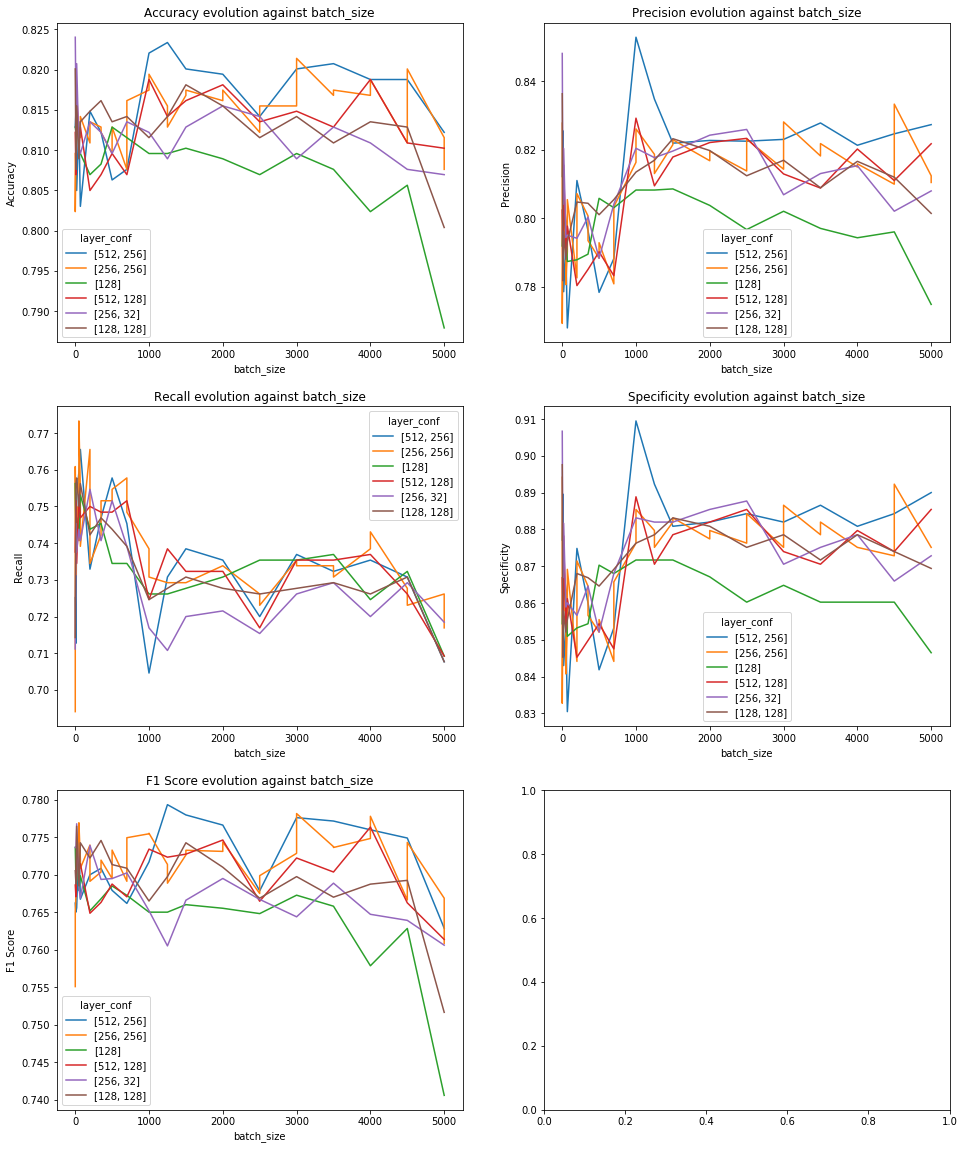

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c81091860>,
       dtype=object))

In [29]:
plot_mlp_summ_performance(mlp_perf_metrics23, 'batch_size', 'layer_conf')

Following conclusions can be extracted from the graph above:

* Models with architecture [512, 256] and [256, 256] reach top values for the most metrics.
* Evolution respecting `batch_size` is very disruptive. For value 1250, higuer metrics can be outperformed for the most architectures

In [30]:
mlp_perf_metrics23.nlargest(5, 'accuracy')

,Unnamed: 0,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
11,11,2,"[256, 32]",0.0001,0.1,1.0,0.860427,0.812808,0.323961,0.438386,10,0.824032,0.848148,0.711180,0.906712,0.773649
7,7,2,"[512, 256]",0.0001,0.1,1250.0,0.842182,0.822660,0.366579,0.415356,49,0.823375,0.834798,0.730769,0.892325,0.779327
0,0,2,"[512, 256]",0.0001,0.1,1000.0,0.842000,0.821018,0.368339,0.404629,41,0.822062,0.852886,0.704615,0.909507,0.771693
41,41,2,"[256, 256]",0.0001,0.1,3000.0,0.839080,0.824302,0.371704,0.408708,126,0.821405,0.828125,0.733846,0.886598,0.778140
25,25,2,"[256, 32]",0.0001,0.1,20.0,0.862251,0.816092,0.330685,0.425597,18,0.820749,0.820380,0.737578,0.881684,0.776778


In [31]:
mlp_perf_metrics23.nlargest(5, 'f1_score')

,Unnamed: 0,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
7,7,2,"[512, 256]",0.0001,0.1,1250.0,0.842182,0.822660,0.366579,0.415356,49,0.823375,0.834798,0.730769,0.892325,0.779327
41,41,2,"[256, 256]",0.0001,0.1,3000.0,0.839080,0.824302,0.371704,0.408708,126,0.821405,0.828125,0.733846,0.886598,0.778140
14,14,2,"[512, 256]",0.0001,0.1,1500.0,0.840540,0.821018,0.378525,0.409411,47,0.820092,0.821918,0.738462,0.880871,0.777958
55,55,2,"[256, 256]",0.0001,0.1,4000.0,0.829228,0.816092,0.395538,0.411314,105,0.818779,0.815878,0.743077,0.875143,0.777778
35,35,2,"[512, 256]",0.0001,0.1,3000.0,0.837256,0.821018,0.376550,0.407989,82,0.820092,0.823024,0.736923,0.882016,0.777597


For the top architectures and `batch_size=1250`, let's grid some values for **dropout**

In [32]:
# Grid parameters
params4 = {
        'lay_conf': best_arch1,
        'lr': [1e-4],
        'dropout': [1e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
        'max_epochs': [300],
        'batch_size': [1250],
        'seed': [123456]
    }

In [33]:
mlp_perf_metrics4 = make_MLP_exp(X_train_vect, y_train.values, params4)

Training with parameters {'batch_size': 1250, 'dropout': 0.01, 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_200 (Dense)            (None, 512)               393728    
_________________________________________________________________
dropout_130 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_131 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 1)                

Epoch 54/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3411 - acc: 0.8542 - val_loss: 0.4370 - val_acc: 0.8013
Epoch 55/300
5/5 [==============================] - 0s 44ms/step - loss: 0.3391 - acc: 0.8533 - val_loss: 0.4398 - val_acc: 0.8079
Epoch 56/300
5/5 [==============================] - 0s 46ms/step - loss: 0.3376 - acc: 0.8564 - val_loss: 0.4378 - val_acc: 0.8046
Training with parameters {'batch_size': 1250, 'dropout': 0.01, 'lay_conf': [256, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_203 (Dense)            (None, 256)               196864    
_________________________________________________________________
dropout_132 (Dropout)        (None, 256)               0 

Epoch 51/300
5/5 [==============================] - 0s 38ms/step - loss: 0.3848 - acc: 0.8314 - val_loss: 0.4388 - val_acc: 0.8062
Epoch 52/300
5/5 [==============================] - 0s 31ms/step - loss: 0.3832 - acc: 0.8314 - val_loss: 0.4400 - val_acc: 0.8062
Epoch 53/300
5/5 [==============================] - 0s 32ms/step - loss: 0.3808 - acc: 0.8321 - val_loss: 0.4384 - val_acc: 0.8062
Epoch 54/300
5/5 [==============================] - 0s 32ms/step - loss: 0.3801 - acc: 0.8311 - val_loss: 0.4396 - val_acc: 0.8095
Epoch 55/300
5/5 [==============================] - 0s 35ms/step - loss: 0.3785 - acc: 0.8356 - val_loss: 0.4369 - val_acc: 0.8046
Epoch 56/300
5/5 [==============================] - 0s 33ms/step - loss: 0.3767 - acc: 0.8360 - val_loss: 0.4364 - val_acc: 0.8095
Epoch 57/300
5/5 [==============================] - 0s 33ms/step - loss: 0.3752 - acc: 0.8380 - val_loss: 0.4359 - val_acc: 0.8046
Epoch 58/300
5/5 [==============================] - 0s 30ms/step - loss: 0.3741 - a

Epoch 23/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4819 - acc: 0.7902 - val_loss: 0.4985 - val_acc: 0.7685
Epoch 24/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4793 - acc: 0.7896 - val_loss: 0.4956 - val_acc: 0.7668
Epoch 25/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4757 - acc: 0.7896 - val_loss: 0.4932 - val_acc: 0.7685
Epoch 26/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4728 - acc: 0.7909 - val_loss: 0.4903 - val_acc: 0.7668
Epoch 27/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4699 - acc: 0.7938 - val_loss: 0.4882 - val_acc: 0.7718
Epoch 28/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4679 - acc: 0.7933 - val_loss: 0.4861 - val_acc: 0.7750
Epoch 29/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4652 - acc: 0.7955 - val_loss: 0.4841 - val_acc: 0.7718
Epoch 30/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4637 - a

Epoch 14/300
5/5 [==============================] - 0s 44ms/step - loss: 0.4802 - acc: 0.7893 - val_loss: 0.4952 - val_acc: 0.7685
Epoch 15/300
5/5 [==============================] - 0s 44ms/step - loss: 0.4715 - acc: 0.7905 - val_loss: 0.4878 - val_acc: 0.7685
Epoch 16/300
5/5 [==============================] - 0s 43ms/step - loss: 0.4637 - acc: 0.7958 - val_loss: 0.4811 - val_acc: 0.7750
Epoch 17/300
5/5 [==============================] - 0s 40ms/step - loss: 0.4575 - acc: 0.7964 - val_loss: 0.4751 - val_acc: 0.7767
Epoch 18/300
5/5 [==============================] - 0s 40ms/step - loss: 0.4511 - acc: 0.8042 - val_loss: 0.4695 - val_acc: 0.7800
Epoch 19/300
5/5 [==============================] - 0s 39ms/step - loss: 0.4445 - acc: 0.8053 - val_loss: 0.4655 - val_acc: 0.7865
Epoch 20/300
5/5 [==============================] - 0s 43ms/step - loss: 0.4394 - acc: 0.8113 - val_loss: 0.4615 - val_acc: 0.7865
Epoch 21/300
5/5 [==============================] - 0s 43ms/step - loss: 0.4353 - a

Epoch 10/300
5/5 [==============================] - 0s 30ms/step - loss: 0.5779 - acc: 0.7340 - val_loss: 0.5816 - val_acc: 0.7373
Epoch 11/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5678 - acc: 0.7446 - val_loss: 0.5736 - val_acc: 0.7455
Epoch 12/300
5/5 [==============================] - 0s 29ms/step - loss: 0.5582 - acc: 0.7462 - val_loss: 0.5659 - val_acc: 0.7340
Epoch 13/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5496 - acc: 0.7488 - val_loss: 0.5574 - val_acc: 0.7373
Epoch 14/300
5/5 [==============================] - 0s 26ms/step - loss: 0.5395 - acc: 0.7559 - val_loss: 0.5486 - val_acc: 0.7570
Epoch 15/300
5/5 [==============================] - 0s 14ms/step - loss: 0.5307 - acc: 0.7645 - val_loss: 0.5403 - val_acc: 0.7603
Epoch 16/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5214 - acc: 0.7681 - val_loss: 0.5329 - val_acc: 0.7619
Epoch 17/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5135 - a

Epoch 25/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4669 - acc: 0.7942 - val_loss: 0.4836 - val_acc: 0.7718
Epoch 26/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4617 - acc: 0.7971 - val_loss: 0.4800 - val_acc: 0.7718
Epoch 27/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4581 - acc: 0.7980 - val_loss: 0.4769 - val_acc: 0.7783
Epoch 28/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4553 - acc: 0.8013 - val_loss: 0.4742 - val_acc: 0.7767
Epoch 29/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4510 - acc: 0.8019 - val_loss: 0.4722 - val_acc: 0.7865
Epoch 30/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4483 - acc: 0.8004 - val_loss: 0.4701 - val_acc: 0.7882
Epoch 31/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4464 - acc: 0.8055 - val_loss: 0.4678 - val_acc: 0.7865
Epoch 32/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4431 - a

Epoch 43/300
5/5 [==============================] - 0s 32ms/step - loss: 0.3988 - acc: 0.8269 - val_loss: 0.4459 - val_acc: 0.8095
Epoch 44/300
5/5 [==============================] - 0s 31ms/step - loss: 0.3956 - acc: 0.8287 - val_loss: 0.4428 - val_acc: 0.8062
Epoch 45/300
5/5 [==============================] - 0s 32ms/step - loss: 0.3927 - acc: 0.8272 - val_loss: 0.4441 - val_acc: 0.8112
Epoch 46/300
5/5 [==============================] - 0s 30ms/step - loss: 0.3938 - acc: 0.8261 - val_loss: 0.4416 - val_acc: 0.7980
Epoch 47/300
5/5 [==============================] - 0s 33ms/step - loss: 0.3901 - acc: 0.8296 - val_loss: 0.4433 - val_acc: 0.8128
Epoch 48/300
5/5 [==============================] - 0s 30ms/step - loss: 0.3894 - acc: 0.8312 - val_loss: 0.4422 - val_acc: 0.8062
Epoch 49/300
5/5 [==============================] - 0s 31ms/step - loss: 0.3879 - acc: 0.8301 - val_loss: 0.4419 - val_acc: 0.8062
Epoch 50/300
5/5 [==============================] - 0s 32ms/step - loss: 0.3859 - a

Epoch 9/300
5/5 [==============================] - 0s 44ms/step - loss: 0.5275 - acc: 0.7539 - val_loss: 0.5376 - val_acc: 0.7438
Epoch 10/300
5/5 [==============================] - 0s 43ms/step - loss: 0.5137 - acc: 0.7666 - val_loss: 0.5250 - val_acc: 0.7537
Epoch 11/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5009 - acc: 0.7780 - val_loss: 0.5132 - val_acc: 0.7553
Epoch 12/300
5/5 [==============================] - 0s 46ms/step - loss: 0.4897 - acc: 0.7814 - val_loss: 0.5042 - val_acc: 0.7521
Epoch 13/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4814 - acc: 0.7842 - val_loss: 0.4968 - val_acc: 0.7685
Epoch 14/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4699 - acc: 0.7940 - val_loss: 0.4895 - val_acc: 0.7652
Epoch 15/300
5/5 [==============================] - 0s 48ms/step - loss: 0.4640 - acc: 0.7944 - val_loss: 0.4840 - val_acc: 0.7586
Epoch 16/300
5/5 [==============================] - 0s 47ms/step - loss: 0.4566 - ac

Epoch 5/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6396 - acc: 0.6141 - val_loss: 0.6276 - val_acc: 0.6289
Epoch 6/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6217 - acc: 0.6743 - val_loss: 0.6140 - val_acc: 0.7241
Epoch 7/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6078 - acc: 0.7041 - val_loss: 0.6040 - val_acc: 0.7258
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5932 - acc: 0.7077 - val_loss: 0.5944 - val_acc: 0.7258
Epoch 9/300
5/5 [==============================] - 0s 36ms/step - loss: 0.5840 - acc: 0.7114 - val_loss: 0.5839 - val_acc: 0.7258
Epoch 10/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5691 - acc: 0.7269 - val_loss: 0.5737 - val_acc: 0.7422
Epoch 11/300
5/5 [==============================] - 0s 32ms/step - loss: 0.5608 - acc: 0.7327 - val_loss: 0.5634 - val_acc: 0.7455
Epoch 12/300
5/5 [==============================] - 0s 30ms/step - loss: 0.5501 - acc: 0

Epoch 40/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4477 - acc: 0.8041 - val_loss: 0.4699 - val_acc: 0.7898
Epoch 41/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4474 - acc: 0.8062 - val_loss: 0.4687 - val_acc: 0.7898
Epoch 42/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4466 - acc: 0.8079 - val_loss: 0.4680 - val_acc: 0.7947
Epoch 43/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4443 - acc: 0.8088 - val_loss: 0.4667 - val_acc: 0.7898
Epoch 44/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4422 - acc: 0.8042 - val_loss: 0.4662 - val_acc: 0.7898
Epoch 45/300
5/5 [==============================] - 0s 9ms/step - loss: 0.4416 - acc: 0.8081 - val_loss: 0.4650 - val_acc: 0.7931
Epoch 46/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4403 - acc: 0.8090 - val_loss: 0.4645 - val_acc: 0.7980
Epoch 47/300
5/5 [==============================] - 0s 9ms/step - loss: 0.4377 - acc

5/5 [==============================] - 0s 43ms/step - loss: 0.4643 - acc: 0.7969 - val_loss: 0.4746 - val_acc: 0.7750
Epoch 19/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4559 - acc: 0.7993 - val_loss: 0.4700 - val_acc: 0.7800
Epoch 20/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4516 - acc: 0.8053 - val_loss: 0.4658 - val_acc: 0.7882
Epoch 21/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4476 - acc: 0.8055 - val_loss: 0.4619 - val_acc: 0.7898
Epoch 22/300
5/5 [==============================] - 0s 44ms/step - loss: 0.4407 - acc: 0.8090 - val_loss: 0.4598 - val_acc: 0.7898
Epoch 23/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4381 - acc: 0.8135 - val_loss: 0.4568 - val_acc: 0.7915
Epoch 24/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4319 - acc: 0.8179 - val_loss: 0.4544 - val_acc: 0.7947
Epoch 25/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4312 - acc: 0.8146 - 

Epoch 14/300
5/5 [==============================] - 0s 15ms/step - loss: 0.5497 - acc: 0.7438 - val_loss: 0.5513 - val_acc: 0.7438
Epoch 15/300
5/5 [==============================] - 0s 24ms/step - loss: 0.5416 - acc: 0.7519 - val_loss: 0.5436 - val_acc: 0.7619
Epoch 16/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5358 - acc: 0.7546 - val_loss: 0.5360 - val_acc: 0.7652
Epoch 17/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5240 - acc: 0.7626 - val_loss: 0.5286 - val_acc: 0.7635
Epoch 18/300
5/5 [==============================] - 0s 29ms/step - loss: 0.5166 - acc: 0.7615 - val_loss: 0.5219 - val_acc: 0.7619
Epoch 19/300
5/5 [==============================] - 0s 26ms/step - loss: 0.5087 - acc: 0.7721 - val_loss: 0.5154 - val_acc: 0.7718
Epoch 20/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5057 - acc: 0.7685 - val_loss: 0.5097 - val_acc: 0.7685
Epoch 21/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5005 - a

Epoch 34/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4459 - acc: 0.8037 - val_loss: 0.4640 - val_acc: 0.7931
Epoch 35/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4441 - acc: 0.8031 - val_loss: 0.4625 - val_acc: 0.7915
Epoch 36/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4418 - acc: 0.8046 - val_loss: 0.4614 - val_acc: 0.7947
Epoch 37/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4416 - acc: 0.8075 - val_loss: 0.4599 - val_acc: 0.7947
Epoch 38/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4377 - acc: 0.8072 - val_loss: 0.4585 - val_acc: 0.7964
Epoch 39/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4364 - acc: 0.8095 - val_loss: 0.4578 - val_acc: 0.7980
Epoch 40/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4346 - acc: 0.8073 - val_loss: 0.4563 - val_acc: 0.7964
Epoch 41/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4327 - a

5/5 [==============================] - 0s 34ms/step - loss: 0.8080 - acc: 0.4335 - val_loss: 0.7404 - val_acc: 0.4171
Epoch 2/300
5/5 [==============================] - 0s 15ms/step - loss: 0.7164 - acc: 0.4687 - val_loss: 0.6803 - val_acc: 0.6043
Epoch 3/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6724 - acc: 0.5975 - val_loss: 0.6565 - val_acc: 0.5895
Epoch 4/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6543 - acc: 0.5973 - val_loss: 0.6428 - val_acc: 0.5878
Epoch 5/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6427 - acc: 0.6046 - val_loss: 0.6278 - val_acc: 0.6223
Epoch 6/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6228 - acc: 0.6641 - val_loss: 0.6136 - val_acc: 0.7225
Epoch 7/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6052 - acc: 0.7072 - val_loss: 0.6030 - val_acc: 0.7373
Epoch 8/300
5/5 [==============================] - 0s 32ms/step - loss: 0.5950 - acc: 0.7101 - val_los

Epoch 64/300
5/5 [==============================] - 0s 35ms/step - loss: 0.3742 - acc: 0.8385 - val_loss: 0.4353 - val_acc: 0.8079
Epoch 65/300
5/5 [==============================] - 0s 30ms/step - loss: 0.3718 - acc: 0.8400 - val_loss: 0.4378 - val_acc: 0.8046
Epoch 66/300
5/5 [==============================] - 0s 30ms/step - loss: 0.3715 - acc: 0.8402 - val_loss: 0.4372 - val_acc: 0.8046
Epoch 67/300
5/5 [==============================] - 0s 35ms/step - loss: 0.3689 - acc: 0.8389 - val_loss: 0.4357 - val_acc: 0.8062
Epoch 68/300
5/5 [==============================] - 0s 31ms/step - loss: 0.3714 - acc: 0.8376 - val_loss: 0.4373 - val_acc: 0.8095
Epoch 69/300
5/5 [==============================] - 0s 35ms/step - loss: 0.3682 - acc: 0.8387 - val_loss: 0.4356 - val_acc: 0.8112
Training with parameters {'batch_size': 1250, 'dropout': 0.15, 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_84"
____________________________________________________________

Epoch 48/300
5/5 [==============================] - 0s 44ms/step - loss: 0.3730 - acc: 0.8387 - val_loss: 0.4398 - val_acc: 0.8095
Epoch 49/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3678 - acc: 0.8431 - val_loss: 0.4369 - val_acc: 0.8030
Epoch 50/300
5/5 [==============================] - 0s 46ms/step - loss: 0.3686 - acc: 0.8371 - val_loss: 0.4387 - val_acc: 0.8062
Epoch 51/300
5/5 [==============================] - 0s 46ms/step - loss: 0.3646 - acc: 0.8446 - val_loss: 0.4383 - val_acc: 0.8013
Epoch 52/300
5/5 [==============================] - 0s 41ms/step - loss: 0.3659 - acc: 0.8425 - val_loss: 0.4429 - val_acc: 0.8079
Epoch 53/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3630 - acc: 0.8424 - val_loss: 0.4375 - val_acc: 0.8046
Epoch 54/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3584 - acc: 0.8438 - val_loss: 0.4375 - val_acc: 0.8062
Training with parameters {'batch_size': 1250, 'dropout': 0.15, 'lay_conf': [256, 25

Epoch 47/300
5/5 [==============================] - 0s 32ms/step - loss: 0.4091 - acc: 0.8190 - val_loss: 0.4418 - val_acc: 0.8046
Epoch 48/300
5/5 [==============================] - 0s 33ms/step - loss: 0.4080 - acc: 0.8234 - val_loss: 0.4448 - val_acc: 0.8095
Epoch 49/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4031 - acc: 0.8252 - val_loss: 0.4397 - val_acc: 0.8095
Epoch 50/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4009 - acc: 0.8263 - val_loss: 0.4407 - val_acc: 0.8095
Epoch 51/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4006 - acc: 0.8263 - val_loss: 0.4413 - val_acc: 0.8062
Epoch 52/300
5/5 [==============================] - 0s 31ms/step - loss: 0.3985 - acc: 0.8225 - val_loss: 0.4403 - val_acc: 0.8112
Epoch 53/300
5/5 [==============================] - 0s 36ms/step - loss: 0.3977 - acc: 0.8252 - val_loss: 0.4392 - val_acc: 0.8046
Epoch 54/300
5/5 [==============================] - 0s 30ms/step - loss: 0.3950 - a

Epoch 14/300
5/5 [==============================] - 0s 11ms/step - loss: 0.5268 - acc: 0.7625 - val_loss: 0.5347 - val_acc: 0.7537
Epoch 15/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5215 - acc: 0.7628 - val_loss: 0.5295 - val_acc: 0.7603
Epoch 16/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5176 - acc: 0.7645 - val_loss: 0.5249 - val_acc: 0.7603
Epoch 17/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5103 - acc: 0.7679 - val_loss: 0.5208 - val_acc: 0.7635
Epoch 18/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5058 - acc: 0.7730 - val_loss: 0.5165 - val_acc: 0.7652
Epoch 19/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5031 - acc: 0.7780 - val_loss: 0.5126 - val_acc: 0.7635
Epoch 20/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4962 - acc: 0.7783 - val_loss: 0.5092 - val_acc: 0.7603
Epoch 21/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4939 - a

Epoch 4/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6428 - acc: 0.6008 - val_loss: 0.6220 - val_acc: 0.6305
Epoch 5/300
5/5 [==============================] - 0s 31ms/step - loss: 0.6203 - acc: 0.6614 - val_loss: 0.6074 - val_acc: 0.7159
Epoch 6/300
5/5 [==============================] - 0s 40ms/step - loss: 0.6001 - acc: 0.6970 - val_loss: 0.5984 - val_acc: 0.6765
Epoch 7/300
5/5 [==============================] - 0s 44ms/step - loss: 0.5864 - acc: 0.6968 - val_loss: 0.5832 - val_acc: 0.7110
Epoch 8/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5713 - acc: 0.7232 - val_loss: 0.5691 - val_acc: 0.7488
Epoch 9/300
5/5 [==============================] - 0s 38ms/step - loss: 0.5561 - acc: 0.7396 - val_loss: 0.5559 - val_acc: 0.7521
Epoch 10/300
5/5 [==============================] - 0s 39ms/step - loss: 0.5416 - acc: 0.7493 - val_loss: 0.5436 - val_acc: 0.7488
Epoch 11/300
5/5 [==============================] - 0s 43ms/step - loss: 0.5311 - acc: 0.

Epoch 1/300
5/5 [==============================] - 0s 38ms/step - loss: 0.8481 - acc: 0.4322 - val_loss: 0.7632 - val_acc: 0.4171
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 0.7465 - acc: 0.4433 - val_loss: 0.6981 - val_acc: 0.4729
Epoch 3/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6947 - acc: 0.5176 - val_loss: 0.6682 - val_acc: 0.6273
Epoch 4/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6716 - acc: 0.5880 - val_loss: 0.6534 - val_acc: 0.6190
Epoch 5/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6570 - acc: 0.6194 - val_loss: 0.6403 - val_acc: 0.6273
Epoch 6/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6405 - acc: 0.6559 - val_loss: 0.6267 - val_acc: 0.7011
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6255 - acc: 0.6809 - val_loss: 0.6149 - val_acc: 0.7471
Epoch 8/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6119 - acc: 0.70

Epoch 30/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4622 - acc: 0.7929 - val_loss: 0.4732 - val_acc: 0.7800
Epoch 31/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4593 - acc: 0.7960 - val_loss: 0.4708 - val_acc: 0.7865
Epoch 32/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4557 - acc: 0.7995 - val_loss: 0.4687 - val_acc: 0.7849
Epoch 33/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4519 - acc: 0.8002 - val_loss: 0.4665 - val_acc: 0.7882
Epoch 34/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4525 - acc: 0.8048 - val_loss: 0.4654 - val_acc: 0.7947
Epoch 35/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4475 - acc: 0.8000 - val_loss: 0.4628 - val_acc: 0.7915
Epoch 36/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4480 - acc: 0.7978 - val_loss: 0.4613 - val_acc: 0.7898
Epoch 37/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4424 - a

Epoch 6/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6279 - acc: 0.6608 - val_loss: 0.6156 - val_acc: 0.7061
Epoch 7/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6112 - acc: 0.6964 - val_loss: 0.6048 - val_acc: 0.7340
Epoch 8/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6029 - acc: 0.6942 - val_loss: 0.5953 - val_acc: 0.7258
Epoch 9/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5876 - acc: 0.7021 - val_loss: 0.5854 - val_acc: 0.7241
Epoch 10/300
5/5 [==============================] - 0s 35ms/step - loss: 0.5779 - acc: 0.7053 - val_loss: 0.5754 - val_acc: 0.7323
Epoch 11/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5675 - acc: 0.7254 - val_loss: 0.5656 - val_acc: 0.7504
Epoch 12/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5547 - acc: 0.7344 - val_loss: 0.5555 - val_acc: 0.7504
Epoch 13/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5465 - acc: 

Model: "model_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_260 (Dense)            (None, 512)               393728    
_________________________________________________________________
dropout_169 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_261 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_170 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 1)                 257       
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
____________________________________________________

Epoch 55/300
5/5 [==============================] - 0s 43ms/step - loss: 0.3651 - acc: 0.8422 - val_loss: 0.4384 - val_acc: 0.8062
Epoch 56/300
5/5 [==============================] - 0s 45ms/step - loss: 0.3634 - acc: 0.8409 - val_loss: 0.4369 - val_acc: 0.8062
Epoch 57/300
5/5 [==============================] - 0s 45ms/step - loss: 0.3599 - acc: 0.8442 - val_loss: 0.4394 - val_acc: 0.8079
Epoch 58/300
5/5 [==============================] - 0s 44ms/step - loss: 0.3567 - acc: 0.8460 - val_loss: 0.4392 - val_acc: 0.8095
Epoch 59/300
5/5 [==============================] - 0s 43ms/step - loss: 0.3572 - acc: 0.8447 - val_loss: 0.4363 - val_acc: 0.8062
Epoch 60/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3585 - acc: 0.8456 - val_loss: 0.4359 - val_acc: 0.8079
Epoch 61/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3511 - acc: 0.8508 - val_loss: 0.4372 - val_acc: 0.8079
Epoch 62/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3497 - a

Epoch 43/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4168 - acc: 0.8141 - val_loss: 0.4463 - val_acc: 0.8079
Epoch 44/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4145 - acc: 0.8232 - val_loss: 0.4472 - val_acc: 0.8062
Epoch 45/300
5/5 [==============================] - 0s 39ms/step - loss: 0.4115 - acc: 0.8185 - val_loss: 0.4447 - val_acc: 0.8112
Epoch 46/300
5/5 [==============================] - 0s 34ms/step - loss: 0.4149 - acc: 0.8150 - val_loss: 0.4437 - val_acc: 0.8079
Epoch 47/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4126 - acc: 0.8166 - val_loss: 0.4437 - val_acc: 0.8095
Epoch 48/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4095 - acc: 0.8225 - val_loss: 0.4438 - val_acc: 0.8112
Epoch 49/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4064 - acc: 0.8214 - val_loss: 0.4455 - val_acc: 0.8062
Epoch 50/300
5/5 [==============================] - 0s 32ms/step - loss: 0.4070 - a

Epoch 32/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4659 - acc: 0.7951 - val_loss: 0.4814 - val_acc: 0.7750
Epoch 33/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4627 - acc: 0.7942 - val_loss: 0.4797 - val_acc: 0.7734
Epoch 34/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4637 - acc: 0.7946 - val_loss: 0.4781 - val_acc: 0.7750
Epoch 35/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4589 - acc: 0.7951 - val_loss: 0.4766 - val_acc: 0.7800
Epoch 36/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4584 - acc: 0.7997 - val_loss: 0.4753 - val_acc: 0.7750
Epoch 37/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4555 - acc: 0.8026 - val_loss: 0.4741 - val_acc: 0.7816
Epoch 38/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4539 - acc: 0.8015 - val_loss: 0.4727 - val_acc: 0.7833
Epoch 39/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4534 - a

Epoch 28/300
5/5 [==============================] - 0s 36ms/step - loss: 0.4354 - acc: 0.8115 - val_loss: 0.4520 - val_acc: 0.7931
Epoch 29/300
5/5 [==============================] - 0s 45ms/step - loss: 0.4296 - acc: 0.8143 - val_loss: 0.4501 - val_acc: 0.7980
Epoch 30/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4256 - acc: 0.8135 - val_loss: 0.4492 - val_acc: 0.7997
Epoch 31/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4234 - acc: 0.8157 - val_loss: 0.4480 - val_acc: 0.7980
Epoch 32/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4250 - acc: 0.8157 - val_loss: 0.4466 - val_acc: 0.7980
Epoch 33/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4173 - acc: 0.8208 - val_loss: 0.4454 - val_acc: 0.7947
Epoch 34/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4188 - acc: 0.8197 - val_loss: 0.4440 - val_acc: 0.7947
Epoch 35/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4160 - a

Epoch 17/300
5/5 [==============================] - 0s 32ms/step - loss: 0.5437 - acc: 0.7448 - val_loss: 0.5362 - val_acc: 0.7635
Epoch 18/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5319 - acc: 0.7482 - val_loss: 0.5294 - val_acc: 0.7619
Epoch 19/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5304 - acc: 0.7539 - val_loss: 0.5233 - val_acc: 0.7619
Epoch 20/300
5/5 [==============================] - 0s 29ms/step - loss: 0.5272 - acc: 0.7583 - val_loss: 0.5177 - val_acc: 0.7701
Epoch 21/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5144 - acc: 0.7637 - val_loss: 0.5126 - val_acc: 0.7718
Epoch 22/300
5/5 [==============================] - 0s 30ms/step - loss: 0.5136 - acc: 0.7670 - val_loss: 0.5072 - val_acc: 0.7734
Epoch 23/300
5/5 [==============================] - 0s 26ms/step - loss: 0.5039 - acc: 0.7708 - val_loss: 0.5025 - val_acc: 0.7701
Epoch 24/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5018 - a

Epoch 39/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4466 - acc: 0.8051 - val_loss: 0.4600 - val_acc: 0.7898
Epoch 40/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4456 - acc: 0.8017 - val_loss: 0.4588 - val_acc: 0.7915
Epoch 41/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4446 - acc: 0.8041 - val_loss: 0.4583 - val_acc: 0.7980
Epoch 42/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4400 - acc: 0.8095 - val_loss: 0.4571 - val_acc: 0.7980
Epoch 43/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4370 - acc: 0.8108 - val_loss: 0.4551 - val_acc: 0.7947
Epoch 44/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4394 - acc: 0.8057 - val_loss: 0.4545 - val_acc: 0.7980
Epoch 45/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4341 - acc: 0.8099 - val_loss: 0.4533 - val_acc: 0.7980
Epoch 46/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4328 - a

Epoch 15/300
5/5 [==============================] - 0s 35ms/step - loss: 0.5323 - acc: 0.7449 - val_loss: 0.5296 - val_acc: 0.7603
Epoch 16/300
5/5 [==============================] - 0s 34ms/step - loss: 0.5261 - acc: 0.7493 - val_loss: 0.5210 - val_acc: 0.7767
Epoch 17/300
5/5 [==============================] - 0s 37ms/step - loss: 0.5129 - acc: 0.7606 - val_loss: 0.5124 - val_acc: 0.7734
Epoch 18/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5027 - acc: 0.7634 - val_loss: 0.5048 - val_acc: 0.7783
Epoch 19/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4965 - acc: 0.7681 - val_loss: 0.4997 - val_acc: 0.7783
Epoch 20/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4951 - acc: 0.7696 - val_loss: 0.4929 - val_acc: 0.7734
Epoch 21/300
5/5 [==============================] - 0s 33ms/step - loss: 0.4866 - acc: 0.7756 - val_loss: 0.4882 - val_acc: 0.7783
Epoch 22/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4772 - a

5/5 [==============================] - 1s 48ms/step - loss: 0.7481 - acc: 0.4579 - val_loss: 0.6807 - val_acc: 0.5599
Epoch 2/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6791 - acc: 0.5627 - val_loss: 0.6621 - val_acc: 0.5846
Epoch 3/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6591 - acc: 0.5842 - val_loss: 0.6397 - val_acc: 0.5846
Epoch 4/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6312 - acc: 0.6346 - val_loss: 0.6164 - val_acc: 0.7159
Epoch 5/300
5/5 [==============================] - 0s 24ms/step - loss: 0.6090 - acc: 0.6897 - val_loss: 0.6034 - val_acc: 0.6929
Epoch 6/300
5/5 [==============================] - 0s 44ms/step - loss: 0.5946 - acc: 0.6975 - val_loss: 0.5887 - val_acc: 0.7028
Epoch 7/300
5/5 [==============================] - 0s 42ms/step - loss: 0.5763 - acc: 0.7156 - val_loss: 0.5734 - val_acc: 0.7389
Epoch 8/300
5/5 [==============================] - 0s 42ms/step - loss: 0.5596 - acc: 0.7364 - val_los

Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(None, 768)]             0         
_________________________________________________________________
dense_283 (Dense)            (None, 256)               196864    
_________________________________________________________________
dropout_184 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_284 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_185 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_285 (Dense)            (None, 1)                 257       
Total params: 262,913
Trainable params: 262,913
Non-trainable params: 0
____________________________________________________

Epoch 55/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4057 - acc: 0.8197 - val_loss: 0.4428 - val_acc: 0.8079
Epoch 56/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4029 - acc: 0.8258 - val_loss: 0.4409 - val_acc: 0.8079
Epoch 57/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4007 - acc: 0.8230 - val_loss: 0.4423 - val_acc: 0.8128
Epoch 58/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4019 - acc: 0.8269 - val_loss: 0.4439 - val_acc: 0.8095
Epoch 59/300
5/5 [==============================] - 0s 15ms/step - loss: 0.3986 - acc: 0.8270 - val_loss: 0.4414 - val_acc: 0.8079
Epoch 60/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3944 - acc: 0.8245 - val_loss: 0.4413 - val_acc: 0.8161
Epoch 61/300
5/5 [==============================] - 0s 16ms/step - loss: 0.3943 - acc: 0.8290 - val_loss: 0.4410 - val_acc: 0.8144
Training with parameters {'batch_size': 1250, 'dropout': 0.25, 'lay_conf': [128], '

Epoch 49/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4406 - acc: 0.8103 - val_loss: 0.4631 - val_acc: 0.7947
Epoch 50/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4397 - acc: 0.8084 - val_loss: 0.4630 - val_acc: 0.7997
Epoch 51/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4406 - acc: 0.8082 - val_loss: 0.4619 - val_acc: 0.7947
Epoch 52/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4397 - acc: 0.8050 - val_loss: 0.4615 - val_acc: 0.7898
Epoch 53/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4375 - acc: 0.8126 - val_loss: 0.4608 - val_acc: 0.7997
Epoch 54/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4356 - acc: 0.8128 - val_loss: 0.4604 - val_acc: 0.7997
Epoch 55/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4351 - acc: 0.8112 - val_loss: 0.4595 - val_acc: 0.7964
Epoch 56/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4340 - a

Epoch 27/300
5/5 [==============================] - 0s 41ms/step - loss: 0.4394 - acc: 0.8057 - val_loss: 0.4542 - val_acc: 0.7931
Epoch 28/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4389 - acc: 0.8075 - val_loss: 0.4523 - val_acc: 0.7947
Epoch 29/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4337 - acc: 0.8155 - val_loss: 0.4502 - val_acc: 0.7964
Epoch 30/300
5/5 [==============================] - 0s 40ms/step - loss: 0.4317 - acc: 0.8121 - val_loss: 0.4487 - val_acc: 0.7997
Epoch 31/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4289 - acc: 0.8123 - val_loss: 0.4482 - val_acc: 0.7947
Epoch 32/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4253 - acc: 0.8221 - val_loss: 0.4474 - val_acc: 0.8046
Epoch 33/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4246 - acc: 0.8144 - val_loss: 0.4468 - val_acc: 0.7964
Epoch 34/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4186 - a

Epoch 14/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5735 - acc: 0.7183 - val_loss: 0.5638 - val_acc: 0.7488
Epoch 15/300
5/5 [==============================] - 0s 15ms/step - loss: 0.5648 - acc: 0.7283 - val_loss: 0.5555 - val_acc: 0.7504
Epoch 16/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5566 - acc: 0.7329 - val_loss: 0.5478 - val_acc: 0.7521
Epoch 17/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5535 - acc: 0.7347 - val_loss: 0.5406 - val_acc: 0.7570
Epoch 18/300
5/5 [==============================] - 0s 26ms/step - loss: 0.5467 - acc: 0.7446 - val_loss: 0.5337 - val_acc: 0.7652
Epoch 19/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5388 - acc: 0.7466 - val_loss: 0.5271 - val_acc: 0.7652
Epoch 20/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5321 - acc: 0.7546 - val_loss: 0.5212 - val_acc: 0.7652
Epoch 21/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5253 - a

Epoch 26/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4912 - acc: 0.7749 - val_loss: 0.4928 - val_acc: 0.7718
Epoch 27/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4890 - acc: 0.7794 - val_loss: 0.4902 - val_acc: 0.7750
Epoch 28/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4817 - acc: 0.7831 - val_loss: 0.4858 - val_acc: 0.7734
Epoch 29/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4804 - acc: 0.7854 - val_loss: 0.4829 - val_acc: 0.7750
Epoch 30/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4779 - acc: 0.7896 - val_loss: 0.4807 - val_acc: 0.7750
Epoch 31/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4697 - acc: 0.7895 - val_loss: 0.4786 - val_acc: 0.7816
Epoch 32/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4671 - acc: 0.7955 - val_loss: 0.4751 - val_acc: 0.7734
Epoch 33/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4680 - a

Epoch 44/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4210 - acc: 0.8177 - val_loss: 0.4461 - val_acc: 0.8062
Epoch 45/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4208 - acc: 0.8161 - val_loss: 0.4457 - val_acc: 0.8095
Epoch 46/300
5/5 [==============================] - 0s 32ms/step - loss: 0.4183 - acc: 0.8166 - val_loss: 0.4450 - val_acc: 0.8112
Epoch 47/300
5/5 [==============================] - 0s 33ms/step - loss: 0.4185 - acc: 0.8134 - val_loss: 0.4446 - val_acc: 0.8112
Epoch 48/300
5/5 [==============================] - 0s 36ms/step - loss: 0.4146 - acc: 0.8188 - val_loss: 0.4438 - val_acc: 0.8046
Epoch 49/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4109 - acc: 0.8199 - val_loss: 0.4419 - val_acc: 0.8128
Epoch 50/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4116 - acc: 0.8163 - val_loss: 0.4427 - val_acc: 0.8095
Epoch 51/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4110 - a

Epoch 18/300
5/5 [==============================] - 0s 45ms/step - loss: 0.4644 - acc: 0.7905 - val_loss: 0.4787 - val_acc: 0.7849
Epoch 19/300
5/5 [==============================] - 0s 44ms/step - loss: 0.4607 - acc: 0.7924 - val_loss: 0.4714 - val_acc: 0.7718
Epoch 20/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4535 - acc: 0.7953 - val_loss: 0.4706 - val_acc: 0.7816
Epoch 21/300
5/5 [==============================] - 0s 46ms/step - loss: 0.4521 - acc: 0.7953 - val_loss: 0.4651 - val_acc: 0.7865
Epoch 22/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4477 - acc: 0.8009 - val_loss: 0.4625 - val_acc: 0.7849
Epoch 23/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4469 - acc: 0.8033 - val_loss: 0.4625 - val_acc: 0.7898
Epoch 24/300
5/5 [==============================] - 0s 43ms/step - loss: 0.4420 - acc: 0.8037 - val_loss: 0.4578 - val_acc: 0.7898
Epoch 25/300
5/5 [==============================] - 0s 41ms/step - loss: 0.4360 - a

Epoch 16/300
5/5 [==============================] - 0s 33ms/step - loss: 0.5396 - acc: 0.7449 - val_loss: 0.5346 - val_acc: 0.7619
Epoch 17/300
5/5 [==============================] - 0s 33ms/step - loss: 0.5335 - acc: 0.7513 - val_loss: 0.5260 - val_acc: 0.7701
Epoch 18/300
5/5 [==============================] - 0s 31ms/step - loss: 0.5204 - acc: 0.7530 - val_loss: 0.5182 - val_acc: 0.7800
Epoch 19/300
5/5 [==============================] - 0s 36ms/step - loss: 0.5139 - acc: 0.7621 - val_loss: 0.5110 - val_acc: 0.7783
Epoch 20/300
5/5 [==============================] - 0s 30ms/step - loss: 0.5062 - acc: 0.7685 - val_loss: 0.5048 - val_acc: 0.7783
Epoch 21/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4997 - acc: 0.7698 - val_loss: 0.4997 - val_acc: 0.7734
Epoch 22/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4901 - acc: 0.7743 - val_loss: 0.4937 - val_acc: 0.7767
Epoch 23/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4892 - a

Epoch 1/300
5/5 [==============================] - 0s 27ms/step - loss: 0.6707 - acc: 0.5847 - val_loss: 0.6462 - val_acc: 0.6700
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6480 - acc: 0.6238 - val_loss: 0.6305 - val_acc: 0.6683
Epoch 3/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6346 - acc: 0.6347 - val_loss: 0.6187 - val_acc: 0.7209
Epoch 4/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6202 - acc: 0.6639 - val_loss: 0.6086 - val_acc: 0.7044
Epoch 5/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6090 - acc: 0.6763 - val_loss: 0.6001 - val_acc: 0.7044
Epoch 6/300
5/5 [==============================] - 0s 11ms/step - loss: 0.5968 - acc: 0.7022 - val_loss: 0.5917 - val_acc: 0.7110
Epoch 7/300
5/5 [==============================] - 0s 11ms/step - loss: 0.5858 - acc: 0.7134 - val_loss: 0.5828 - val_acc: 0.7258
Epoch 8/300
5/5 [==============================] - 0s 11ms/step - loss: 0.5777 - acc: 0.71

5/5 [==============================] - 0s 13ms/step - loss: 0.3935 - acc: 0.8307 - val_loss: 0.4434 - val_acc: 0.8062
Epoch 126/300
5/5 [==============================] - 0s 12ms/step - loss: 0.3927 - acc: 0.8301 - val_loss: 0.4432 - val_acc: 0.8095
Epoch 127/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3941 - acc: 0.8320 - val_loss: 0.4429 - val_acc: 0.8046
Epoch 128/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3921 - acc: 0.8281 - val_loss: 0.4429 - val_acc: 0.8046
Epoch 129/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3902 - acc: 0.8321 - val_loss: 0.4429 - val_acc: 0.8046
Epoch 130/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3915 - acc: 0.8358 - val_loss: 0.4429 - val_acc: 0.8062
Epoch 131/300
5/5 [==============================] - 0s 12ms/step - loss: 0.3916 - acc: 0.8296 - val_loss: 0.4425 - val_acc: 0.8079
Epoch 132/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3897 - acc: 0.

Epoch 3/300
5/5 [==============================] - 0s 13ms/step - loss: 0.7084 - acc: 0.5028 - val_loss: 0.6700 - val_acc: 0.6273
Epoch 4/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6844 - acc: 0.5481 - val_loss: 0.6567 - val_acc: 0.6076
Epoch 5/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6707 - acc: 0.5835 - val_loss: 0.6464 - val_acc: 0.6043
Epoch 6/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6572 - acc: 0.6138 - val_loss: 0.6366 - val_acc: 0.6207
Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6421 - acc: 0.6413 - val_loss: 0.6265 - val_acc: 0.6913
Epoch 8/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6342 - acc: 0.6568 - val_loss: 0.6169 - val_acc: 0.7471
Epoch 9/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6215 - acc: 0.6780 - val_loss: 0.6084 - val_acc: 0.7422
Epoch 10/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6189 - acc: 0.6

Epoch 18/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5376 - acc: 0.7504 - val_loss: 0.5337 - val_acc: 0.7635
Epoch 19/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5348 - acc: 0.7480 - val_loss: 0.5273 - val_acc: 0.7685
Epoch 20/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5275 - acc: 0.7557 - val_loss: 0.5214 - val_acc: 0.7701
Epoch 21/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5223 - acc: 0.7570 - val_loss: 0.5161 - val_acc: 0.7668
Epoch 22/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5178 - acc: 0.7619 - val_loss: 0.5114 - val_acc: 0.7635
Epoch 23/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5137 - acc: 0.7577 - val_loss: 0.5070 - val_acc: 0.7668
Epoch 24/300
5/5 [==============================] - 0s 13ms/step - loss: 0.5078 - acc: 0.7716 - val_loss: 0.5028 - val_acc: 0.7718
Epoch 25/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5005 - a

Epoch 1/300
5/5 [==============================] - 0s 32ms/step - loss: 0.8309 - acc: 0.4468 - val_loss: 0.7420 - val_acc: 0.4171
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 0.7414 - acc: 0.4764 - val_loss: 0.6828 - val_acc: 0.5928
Epoch 3/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6937 - acc: 0.5455 - val_loss: 0.6600 - val_acc: 0.5878
Epoch 4/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6728 - acc: 0.5944 - val_loss: 0.6493 - val_acc: 0.5862
Epoch 5/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6595 - acc: 0.6079 - val_loss: 0.6374 - val_acc: 0.5878
Epoch 6/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6450 - acc: 0.6325 - val_loss: 0.6238 - val_acc: 0.6355
Epoch 7/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6308 - acc: 0.6544 - val_loss: 0.6125 - val_acc: 0.7291
Epoch 8/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6216 - acc: 0.65

Epoch 39/300
5/5 [==============================] - 0s 45ms/step - loss: 0.4065 - acc: 0.8232 - val_loss: 0.4456 - val_acc: 0.8030
Epoch 40/300
5/5 [==============================] - 0s 44ms/step - loss: 0.4065 - acc: 0.8225 - val_loss: 0.4423 - val_acc: 0.8095
Epoch 41/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4040 - acc: 0.8256 - val_loss: 0.4417 - val_acc: 0.8062
Epoch 42/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3993 - acc: 0.8261 - val_loss: 0.4409 - val_acc: 0.8095
Epoch 43/300
5/5 [==============================] - 0s 48ms/step - loss: 0.3983 - acc: 0.8274 - val_loss: 0.4426 - val_acc: 0.8062
Epoch 44/300
5/5 [==============================] - 0s 45ms/step - loss: 0.4024 - acc: 0.8250 - val_loss: 0.4410 - val_acc: 0.8046
Epoch 45/300
5/5 [==============================] - 0s 45ms/step - loss: 0.4008 - acc: 0.8254 - val_loss: 0.4414 - val_acc: 0.8079
Epoch 46/300
5/5 [==============================] - 0s 45ms/step - loss: 0.4003 - a

Epoch 22/300
5/5 [==============================] - 0s 32ms/step - loss: 0.5034 - acc: 0.7699 - val_loss: 0.4979 - val_acc: 0.7734
Epoch 23/300
5/5 [==============================] - 0s 34ms/step - loss: 0.4981 - acc: 0.7752 - val_loss: 0.4933 - val_acc: 0.7750
Epoch 24/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4882 - acc: 0.7769 - val_loss: 0.4902 - val_acc: 0.7750
Epoch 25/300
5/5 [==============================] - 0s 34ms/step - loss: 0.4870 - acc: 0.7789 - val_loss: 0.4855 - val_acc: 0.7833
Epoch 26/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4818 - acc: 0.7829 - val_loss: 0.4841 - val_acc: 0.7833
Epoch 27/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4772 - acc: 0.7862 - val_loss: 0.4789 - val_acc: 0.7849
Epoch 28/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4712 - acc: 0.7816 - val_loss: 0.4758 - val_acc: 0.7833
Epoch 29/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4683 - a

Epoch 1/300
5/5 [==============================] - 0s 35ms/step - loss: 0.6723 - acc: 0.5917 - val_loss: 0.6468 - val_acc: 0.6716
Epoch 2/300
5/5 [==============================] - 0s 10ms/step - loss: 0.6540 - acc: 0.6130 - val_loss: 0.6313 - val_acc: 0.6700
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 0.6387 - acc: 0.6351 - val_loss: 0.6196 - val_acc: 0.7110
Epoch 4/300
5/5 [==============================] - 0s 10ms/step - loss: 0.6234 - acc: 0.6537 - val_loss: 0.6098 - val_acc: 0.6913
Epoch 5/300
5/5 [==============================] - 0s 10ms/step - loss: 0.6081 - acc: 0.6822 - val_loss: 0.6011 - val_acc: 0.7044
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5988 - acc: 0.6982 - val_loss: 0.5927 - val_acc: 0.7110
Epoch 7/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5916 - acc: 0.7008 - val_loss: 0.5845 - val_acc: 0.7225
Epoch 8/300
5/5 [==============================] - 0s 10ms/step - loss: 0.5821 - acc: 0.71

5/5 [==============================] - 0s 12ms/step - loss: 0.3964 - acc: 0.8303 - val_loss: 0.4428 - val_acc: 0.8062
Epoch 126/300
5/5 [==============================] - 0s 10ms/step - loss: 0.3965 - acc: 0.8296 - val_loss: 0.4429 - val_acc: 0.8079
Epoch 127/300
5/5 [==============================] - 0s 10ms/step - loss: 0.3953 - acc: 0.8280 - val_loss: 0.4429 - val_acc: 0.8046
Epoch 128/300
5/5 [==============================] - 0s 10ms/step - loss: 0.3957 - acc: 0.8278 - val_loss: 0.4437 - val_acc: 0.8079
Epoch 129/300
5/5 [==============================] - 0s 10ms/step - loss: 0.3956 - acc: 0.8285 - val_loss: 0.4433 - val_acc: 0.8079
Training with parameters {'batch_size': 1250, 'dropout': 0.35, 'lay_conf': [512, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       [(None, 768)]             0         
_

Epoch 49/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4087 - acc: 0.8247 - val_loss: 0.4370 - val_acc: 0.8079
Epoch 50/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4046 - acc: 0.8276 - val_loss: 0.4378 - val_acc: 0.8095
Epoch 51/300
5/5 [==============================] - 0s 38ms/step - loss: 0.3982 - acc: 0.8281 - val_loss: 0.4364 - val_acc: 0.8062
Epoch 52/300
5/5 [==============================] - 0s 40ms/step - loss: 0.4021 - acc: 0.8245 - val_loss: 0.4371 - val_acc: 0.8112
Epoch 53/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4014 - acc: 0.8228 - val_loss: 0.4358 - val_acc: 0.8062
Epoch 54/300
5/5 [==============================] - 0s 41ms/step - loss: 0.3966 - acc: 0.8261 - val_loss: 0.4361 - val_acc: 0.8079
Epoch 55/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3979 - acc: 0.8318 - val_loss: 0.4346 - val_acc: 0.8062
Epoch 56/300
5/5 [==============================] - 0s 44ms/step - loss: 0.3938 - a

Epoch 30/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4982 - acc: 0.7738 - val_loss: 0.4880 - val_acc: 0.7800
Epoch 31/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4949 - acc: 0.7772 - val_loss: 0.4854 - val_acc: 0.7833
Epoch 32/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4928 - acc: 0.7750 - val_loss: 0.4832 - val_acc: 0.7849
Epoch 33/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4906 - acc: 0.7794 - val_loss: 0.4808 - val_acc: 0.7833
Epoch 34/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4914 - acc: 0.7761 - val_loss: 0.4787 - val_acc: 0.7833
Epoch 35/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4816 - acc: 0.7887 - val_loss: 0.4776 - val_acc: 0.7865
Epoch 36/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4773 - acc: 0.7865 - val_loss: 0.4748 - val_acc: 0.7800
Epoch 37/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4803 - a

Epoch 48/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4482 - acc: 0.8050 - val_loss: 0.4572 - val_acc: 0.7964
Epoch 49/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4475 - acc: 0.8039 - val_loss: 0.4558 - val_acc: 0.7980
Epoch 50/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4451 - acc: 0.8070 - val_loss: 0.4557 - val_acc: 0.7947
Epoch 51/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4454 - acc: 0.8041 - val_loss: 0.4547 - val_acc: 0.7980
Epoch 52/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4391 - acc: 0.8103 - val_loss: 0.4537 - val_acc: 0.7980
Epoch 53/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4437 - acc: 0.8064 - val_loss: 0.4533 - val_acc: 0.7997
Epoch 54/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4382 - acc: 0.8057 - val_loss: 0.4521 - val_acc: 0.8030
Epoch 55/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4392 - a

Epoch 1/300
5/5 [==============================] - 0s 41ms/step - loss: 0.8413 - acc: 0.4459 - val_loss: 0.7430 - val_acc: 0.4171
Epoch 2/300
5/5 [==============================] - 0s 15ms/step - loss: 0.7431 - acc: 0.4822 - val_loss: 0.6837 - val_acc: 0.5961
Epoch 3/300
5/5 [==============================] - 0s 15ms/step - loss: 0.7024 - acc: 0.5255 - val_loss: 0.6608 - val_acc: 0.5862
Epoch 4/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6719 - acc: 0.5953 - val_loss: 0.6514 - val_acc: 0.5846
Epoch 5/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6667 - acc: 0.6004 - val_loss: 0.6404 - val_acc: 0.5862
Epoch 6/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6514 - acc: 0.6260 - val_loss: 0.6271 - val_acc: 0.6190
Epoch 7/300
5/5 [==============================] - 0s 28ms/step - loss: 0.6358 - acc: 0.6408 - val_loss: 0.6159 - val_acc: 0.7077
Epoch 8/300
5/5 [==============================] - 0s 31ms/step - loss: 0.6228 - acc: 0.65

Epoch 38/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4218 - acc: 0.8165 - val_loss: 0.4459 - val_acc: 0.8013
Epoch 39/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4151 - acc: 0.8190 - val_loss: 0.4459 - val_acc: 0.8013
Epoch 40/300
5/5 [==============================] - 0s 50ms/step - loss: 0.4150 - acc: 0.8196 - val_loss: 0.4451 - val_acc: 0.8046
Epoch 41/300
5/5 [==============================] - 0s 43ms/step - loss: 0.4165 - acc: 0.8163 - val_loss: 0.4453 - val_acc: 0.8062
Epoch 42/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4114 - acc: 0.8197 - val_loss: 0.4429 - val_acc: 0.8062
Epoch 43/300
5/5 [==============================] - 0s 47ms/step - loss: 0.4086 - acc: 0.8263 - val_loss: 0.4429 - val_acc: 0.8079
Epoch 44/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4121 - acc: 0.8219 - val_loss: 0.4426 - val_acc: 0.8079
Epoch 45/300
5/5 [==============================] - 0s 46ms/step - loss: 0.4062 - a

Epoch 21/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5179 - acc: 0.7562 - val_loss: 0.5112 - val_acc: 0.7685
Epoch 22/300
5/5 [==============================] - 0s 33ms/step - loss: 0.5138 - acc: 0.7643 - val_loss: 0.5059 - val_acc: 0.7734
Epoch 23/300
5/5 [==============================] - 0s 32ms/step - loss: 0.5059 - acc: 0.7718 - val_loss: 0.5019 - val_acc: 0.7750
Epoch 24/300
5/5 [==============================] - 0s 34ms/step - loss: 0.5017 - acc: 0.7770 - val_loss: 0.4959 - val_acc: 0.7734
Epoch 25/300
5/5 [==============================] - 0s 32ms/step - loss: 0.4934 - acc: 0.7769 - val_loss: 0.4914 - val_acc: 0.7783
Epoch 26/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4923 - acc: 0.7745 - val_loss: 0.4893 - val_acc: 0.7767
Epoch 27/300
5/5 [==============================] - 0s 34ms/step - loss: 0.4852 - acc: 0.7801 - val_loss: 0.4864 - val_acc: 0.7816
Epoch 28/300
5/5 [==============================] - 0s 32ms/step - loss: 0.4852 - a

5/5 [==============================] - 0s 10ms/step - loss: 0.4434 - acc: 0.8066 - val_loss: 0.4642 - val_acc: 0.7882
Epoch 53/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4416 - acc: 0.8092 - val_loss: 0.4635 - val_acc: 0.7947
Epoch 54/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4435 - acc: 0.8059 - val_loss: 0.4628 - val_acc: 0.7980
Epoch 55/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4440 - acc: 0.8061 - val_loss: 0.4621 - val_acc: 0.7849
Epoch 56/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4407 - acc: 0.8106 - val_loss: 0.4618 - val_acc: 0.7865
Epoch 57/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4421 - acc: 0.8061 - val_loss: 0.4612 - val_acc: 0.7964
Epoch 58/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4359 - acc: 0.8103 - val_loss: 0.4606 - val_acc: 0.7964
Epoch 59/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4416 - acc: 0.8044 - 

5/5 [==============================] - 0s 20ms/step - loss: 0.6677 - acc: 0.5815 - val_loss: 0.6336 - val_acc: 0.5895
Epoch 5/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6450 - acc: 0.6150 - val_loss: 0.6167 - val_acc: 0.6995
Epoch 6/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6253 - acc: 0.6548 - val_loss: 0.6069 - val_acc: 0.7225
Epoch 7/300
5/5 [==============================] - 0s 43ms/step - loss: 0.6174 - acc: 0.6654 - val_loss: 0.5981 - val_acc: 0.7044
Epoch 8/300
5/5 [==============================] - 0s 38ms/step - loss: 0.6041 - acc: 0.6873 - val_loss: 0.5864 - val_acc: 0.7258
Epoch 9/300
5/5 [==============================] - 0s 38ms/step - loss: 0.5895 - acc: 0.6986 - val_loss: 0.5755 - val_acc: 0.7373
Epoch 10/300
5/5 [==============================] - 0s 37ms/step - loss: 0.5834 - acc: 0.7055 - val_loss: 0.5654 - val_acc: 0.7488
Epoch 11/300
5/5 [==============================] - 0s 44ms/step - loss: 0.5687 - acc: 0.7278 - val_l

Epoch 67/300
5/5 [==============================] - 0s 38ms/step - loss: 0.3853 - acc: 0.8358 - val_loss: 0.4320 - val_acc: 0.8030
Epoch 68/300
5/5 [==============================] - 0s 38ms/step - loss: 0.3886 - acc: 0.8327 - val_loss: 0.4337 - val_acc: 0.8062
Epoch 69/300
5/5 [==============================] - 0s 40ms/step - loss: 0.3857 - acc: 0.8345 - val_loss: 0.4327 - val_acc: 0.8062
Epoch 70/300
5/5 [==============================] - 0s 42ms/step - loss: 0.3825 - acc: 0.8343 - val_loss: 0.4326 - val_acc: 0.8062
Epoch 71/300
5/5 [==============================] - 0s 38ms/step - loss: 0.3878 - acc: 0.8331 - val_loss: 0.4338 - val_acc: 0.8062
Epoch 72/300
5/5 [==============================] - 0s 38ms/step - loss: 0.3803 - acc: 0.8365 - val_loss: 0.4326 - val_acc: 0.8079
Training with parameters {'batch_size': 1250, 'dropout': 0.4, 'lay_conf': [256, 32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_123"
_____________________________________________________________

Epoch 48/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4633 - acc: 0.7946 - val_loss: 0.4611 - val_acc: 0.7865
Epoch 49/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4654 - acc: 0.8008 - val_loss: 0.4601 - val_acc: 0.7898
Epoch 50/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4589 - acc: 0.7971 - val_loss: 0.4581 - val_acc: 0.7865
Epoch 51/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4607 - acc: 0.8042 - val_loss: 0.4566 - val_acc: 0.7849
Epoch 52/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4566 - acc: 0.8011 - val_loss: 0.4564 - val_acc: 0.7898
Epoch 53/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4564 - acc: 0.8002 - val_loss: 0.4562 - val_acc: 0.7931
Epoch 54/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4585 - acc: 0.7980 - val_loss: 0.4534 - val_acc: 0.7865
Epoch 55/300
5/5 [==============================] - 0s 29ms/step - loss: 0.4539 - a

Epoch 43/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4593 - acc: 0.7960 - val_loss: 0.4651 - val_acc: 0.7882
Epoch 44/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4606 - acc: 0.7958 - val_loss: 0.4644 - val_acc: 0.7882
Epoch 45/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4617 - acc: 0.7999 - val_loss: 0.4636 - val_acc: 0.7882
Epoch 46/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4562 - acc: 0.7980 - val_loss: 0.4617 - val_acc: 0.7882
Epoch 47/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4526 - acc: 0.8020 - val_loss: 0.4615 - val_acc: 0.7898
Epoch 48/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4555 - acc: 0.8020 - val_loss: 0.4593 - val_acc: 0.7882
Epoch 49/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4578 - acc: 0.7940 - val_loss: 0.4579 - val_acc: 0.7931
Epoch 50/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4526 - a

Epoch 44/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4392 - acc: 0.8035 - val_loss: 0.4576 - val_acc: 0.7964
Epoch 45/300
5/5 [==============================] - 0s 33ms/step - loss: 0.4358 - acc: 0.8093 - val_loss: 0.4540 - val_acc: 0.8013
Epoch 46/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4372 - acc: 0.8108 - val_loss: 0.4526 - val_acc: 0.7997
Epoch 47/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4364 - acc: 0.8103 - val_loss: 0.4519 - val_acc: 0.8030
Epoch 48/300
5/5 [==============================] - 0s 33ms/step - loss: 0.4314 - acc: 0.8124 - val_loss: 0.4533 - val_acc: 0.7997
Epoch 49/300
5/5 [==============================] - 0s 34ms/step - loss: 0.4262 - acc: 0.8124 - val_loss: 0.4500 - val_acc: 0.7997
Epoch 50/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4312 - acc: 0.8126 - val_loss: 0.4504 - val_acc: 0.8030
Epoch 51/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4281 - a

In [34]:
mlp_perf_metrics4

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[512, 256]",0.0001,0.01,1250,0.856413,0.804598,0.337578,0.437817,56,0.820092,0.803890,0.764253,0.861556,0.783570
1,2,"[256, 256]",0.0001,0.01,1250,0.856778,0.819376,0.331602,0.434488,83,0.812869,0.783489,0.775039,0.840961,0.779241
2,1,[128],0.0001,0.01,1250,0.834884,0.806240,0.384279,0.442817,124,0.814183,0.800000,0.751926,0.860412,0.775218
3,2,"[512, 128]",0.0001,0.01,1250,0.849298,0.807882,0.351228,0.438279,57,0.819435,0.806557,0.758089,0.864989,0.781573
4,2,"[256, 32]",0.0001,0.01,1250,0.845831,0.814450,0.355905,0.438476,100,0.821405,0.809524,0.759630,0.867277,0.783784
5,2,"[128, 128]",0.0001,0.01,1250,0.848568,0.811166,0.354372,0.440564,97,0.810243,0.795082,0.747304,0.856979,0.770453
6,2,"[256, 256]",0.0001,0.01,1250,0.862069,0.816092,0.321684,0.433280,87,0.826001,0.809677,0.773498,0.864989,0.791174
7,2,"[512, 256]",0.0001,0.10,1250,0.851305,0.804598,0.348299,0.438181,57,0.821405,0.820034,0.744222,0.878719,0.780291
8,2,"[256, 256]",0.0001,0.10,1250,0.849480,0.811166,0.345813,0.435760,82,0.820092,0.805873,0.761171,0.863844,0.782884
9,1,[128],0.0001,0.10,1250,0.833972,0.807882,0.381732,0.441768,136,0.814183,0.797078,0.756549,0.856979,0.776285


In [36]:
mlp_perf_metrics4.to_csv('mlp_perf_metrics4.csv', sep=';')

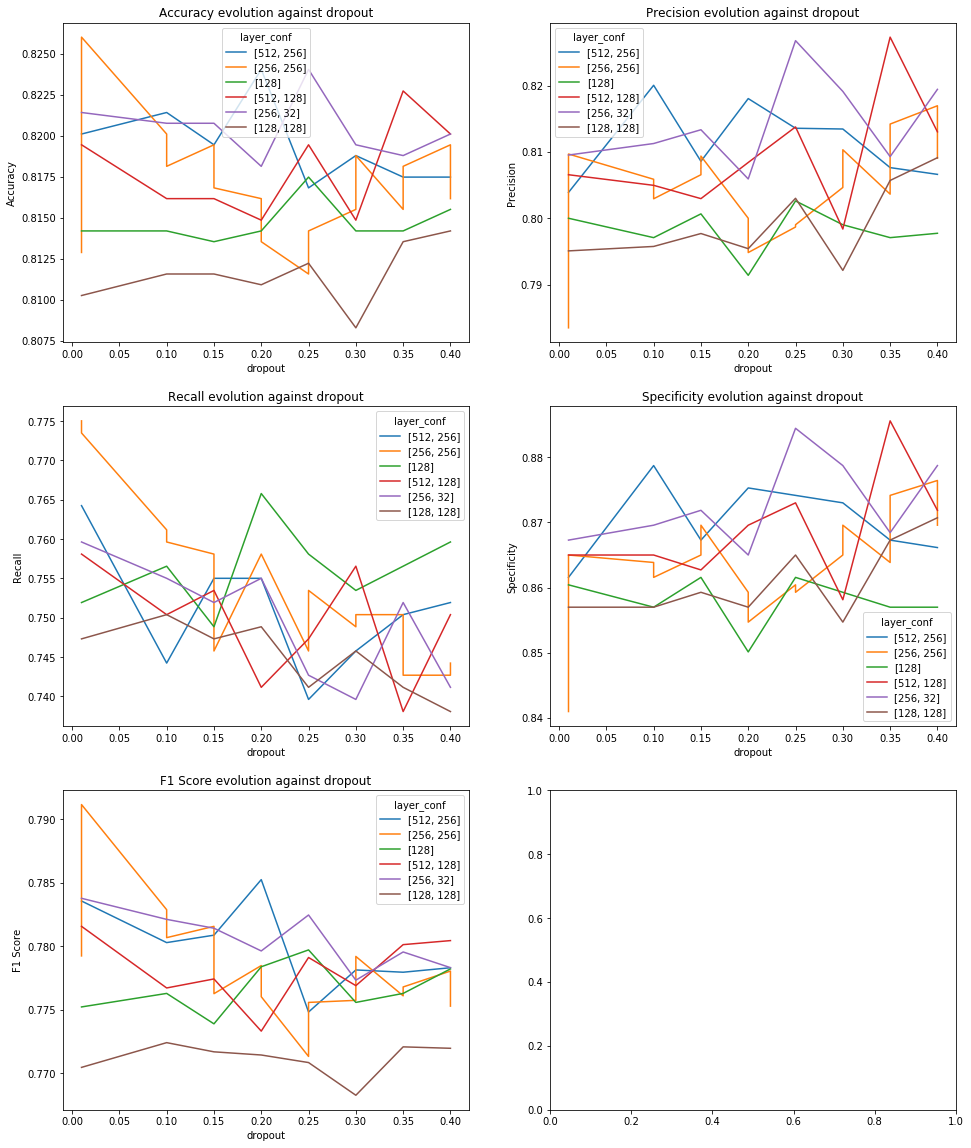

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c7f8fdf60>,
       dtype=object))

In [44]:
mlp_perf_metrics4['layer_conf'] = mlp_perf_metrics4['layer_conf'].astype(str)
plot_mlp_summ_performance(mlp_perf_metrics4, 'dropout', 'layer_conf')

In [43]:
mlp_perf_metrics4['layer_conf'] = mlp_perf_metrics4['layer_conf'].astype(str)

In [45]:
mlp_perf_metrics4.nlargest(5, 'accuracy')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
6,2,"[256, 256]",0.0001,0.01,1250,0.862069,0.816092,0.321684,0.433280,87,0.826001,0.809677,0.773498,0.864989,0.791174
21,2,"[512, 256]",0.0001,0.20,1250,0.848020,0.801314,0.343788,0.436324,65,0.824032,0.818030,0.755008,0.875286,0.785256
32,2,"[256, 32]",0.0001,0.25,1250,0.833789,0.809524,0.382990,0.434938,103,0.824032,0.826758,0.742681,0.884439,0.782468
45,2,"[512, 128]",0.0001,0.35,1250,0.840358,0.806240,0.371656,0.433346,72,0.822718,0.827288,0.738059,0.885584,0.780130
4,2,"[256, 32]",0.0001,0.01,1250,0.845831,0.814450,0.355905,0.438476,100,0.821405,0.809524,0.759630,0.867277,0.783784


In [46]:
mlp_perf_metrics4.nlargest(5, 'f1_score')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
6,2,"[256, 256]",0.0001,0.01,1250,0.862069,0.816092,0.321684,0.433280,87,0.826001,0.809677,0.773498,0.864989,0.791174
21,2,"[512, 256]",0.0001,0.20,1250,0.848020,0.801314,0.343788,0.436324,65,0.824032,0.818030,0.755008,0.875286,0.785256
4,2,"[256, 32]",0.0001,0.01,1250,0.845831,0.814450,0.355905,0.438476,100,0.821405,0.809524,0.759630,0.867277,0.783784
0,2,"[512, 256]",0.0001,0.01,1250,0.856413,0.804598,0.337578,0.437817,56,0.820092,0.803890,0.764253,0.861556,0.783570
8,2,"[256, 256]",0.0001,0.10,1250,0.849480,0.811166,0.345813,0.435760,82,0.820092,0.805873,0.761171,0.863844,0.782884


Model based on [256, 256] architecture, `batch_size=1250` and having `dropout=0.01` outperforms the metrics on all the performed experiments. Dropout values 0.2 seem to achieve a global balanced performance on all the grided configurations.

Let's try different dropout values on each layer:

In [12]:
# Grid parameters
best_arch2 = [[512, 256],
             [256, 256],
             [512, 128],
             [256, 32],
             [128, 128],
             [256, 256]]

params5 = {
        'lay_conf': best_arch2,
        'lr': [1e-4],
        'dropout': [[0.2, 0.1], [0.2, 0.01], [0.2, 0.3], [0.2, 0.4]],
        'max_epochs': [300],
        'batch_size': [1250],
        'seed': [123456]
    }

In [15]:
mlp_perf_metrics5 = make_MLP_exp(X_train_vect, y_train.values, params5)

Training with parameters {'batch_size': 1250, 'dropout': [0.2, 0.1], 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)             

5/5 [==============================] - 0s 38ms/step - loss: 0.8252 - acc: 0.4286 - val_loss: 0.7269 - val_acc: 0.4417
Epoch 2/300
5/5 [==============================] - 0s 10ms/step - loss: 0.7275 - acc: 0.4702 - val_loss: 0.6790 - val_acc: 0.6059
Epoch 3/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6814 - acc: 0.5722 - val_loss: 0.6659 - val_acc: 0.5649
Epoch 4/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6587 - acc: 0.6076 - val_loss: 0.6588 - val_acc: 0.5550
Epoch 5/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6529 - acc: 0.6032 - val_loss: 0.6440 - val_acc: 0.5649
Epoch 6/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6302 - acc: 0.6402 - val_loss: 0.6259 - val_acc: 0.6486
Epoch 7/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6149 - acc: 0.6816 - val_loss: 0.6110 - val_acc: 0.7143
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6059 - acc: 0.6893 - val_los

Epoch 64/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3828 - acc: 0.8303 - val_loss: 0.4359 - val_acc: 0.8013
Epoch 65/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3785 - acc: 0.8342 - val_loss: 0.4416 - val_acc: 0.7997
Epoch 66/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3775 - acc: 0.8380 - val_loss: 0.4352 - val_acc: 0.8030
Epoch 67/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3775 - acc: 0.8356 - val_loss: 0.4425 - val_acc: 0.7997
Epoch 68/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3759 - acc: 0.8400 - val_loss: 0.4369 - val_acc: 0.8030
Epoch 69/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3758 - acc: 0.8365 - val_loss: 0.4382 - val_acc: 0.7997
Epoch 70/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3747 - acc: 0.8382 - val_loss: 0.4391 - val_acc: 0.8013
Epoch 71/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3722 - a

Epoch 46/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3886 - acc: 0.8323 - val_loss: 0.4351 - val_acc: 0.8079
Epoch 47/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3848 - acc: 0.8336 - val_loss: 0.4370 - val_acc: 0.8030
Epoch 48/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3874 - acc: 0.8336 - val_loss: 0.4368 - val_acc: 0.7997
Epoch 49/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3821 - acc: 0.8327 - val_loss: 0.4355 - val_acc: 0.8079
Epoch 50/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3840 - acc: 0.8305 - val_loss: 0.4367 - val_acc: 0.7980
Epoch 51/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3789 - acc: 0.8413 - val_loss: 0.4350 - val_acc: 0.8112
Epoch 52/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3795 - acc: 0.8378 - val_loss: 0.4338 - val_acc: 0.8112
Epoch 53/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3753 - a

Epoch 33/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4532 - acc: 0.8026 - val_loss: 0.4585 - val_acc: 0.7915
Epoch 34/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4489 - acc: 0.8048 - val_loss: 0.4566 - val_acc: 0.7915
Epoch 35/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4521 - acc: 0.8026 - val_loss: 0.4553 - val_acc: 0.7915
Epoch 36/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4464 - acc: 0.7991 - val_loss: 0.4545 - val_acc: 0.7882
Epoch 37/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4449 - acc: 0.8026 - val_loss: 0.4541 - val_acc: 0.7898
Epoch 38/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4415 - acc: 0.8072 - val_loss: 0.4519 - val_acc: 0.7931
Epoch 39/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4431 - acc: 0.8077 - val_loss: 0.4505 - val_acc: 0.7931
Epoch 40/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4343 - a

Epoch 10/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5944 - acc: 0.7165 - val_loss: 0.5926 - val_acc: 0.7159
Epoch 11/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5809 - acc: 0.7243 - val_loss: 0.5831 - val_acc: 0.7274
Epoch 12/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5743 - acc: 0.7230 - val_loss: 0.5738 - val_acc: 0.7356
Epoch 13/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5665 - acc: 0.7347 - val_loss: 0.5641 - val_acc: 0.7356
Epoch 14/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5556 - acc: 0.7468 - val_loss: 0.5541 - val_acc: 0.7373
Epoch 15/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5465 - acc: 0.7490 - val_loss: 0.5438 - val_acc: 0.7471
Epoch 16/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5416 - acc: 0.7493 - val_loss: 0.5340 - val_acc: 0.7570
Epoch 17/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5320 - a

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               196864    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 262,913
Trainable params: 262,913
Non-trainable params: 0
_____________________________________________________

5/5 [==============================] - 0s 39ms/step - loss: 0.7474 - acc: 0.4388 - val_loss: 0.6858 - val_acc: 0.5468
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6731 - acc: 0.5738 - val_loss: 0.6746 - val_acc: 0.5583
Epoch 3/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6521 - acc: 0.5787 - val_loss: 0.6468 - val_acc: 0.5632
Epoch 4/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6248 - acc: 0.6371 - val_loss: 0.6156 - val_acc: 0.7011
Epoch 5/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5996 - acc: 0.7134 - val_loss: 0.5970 - val_acc: 0.7044
Epoch 6/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5845 - acc: 0.7095 - val_loss: 0.5792 - val_acc: 0.7159
Epoch 7/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5663 - acc: 0.7349 - val_loss: 0.5645 - val_acc: 0.7323
Epoch 8/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5521 - acc: 0.7500 - val_los

Epoch 7/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6114 - acc: 0.6962 - val_loss: 0.6090 - val_acc: 0.7225
Epoch 8/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6004 - acc: 0.6926 - val_loss: 0.5973 - val_acc: 0.7110
Epoch 9/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5862 - acc: 0.7077 - val_loss: 0.5867 - val_acc: 0.7110
Epoch 10/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5796 - acc: 0.7141 - val_loss: 0.5771 - val_acc: 0.7241
Epoch 11/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5689 - acc: 0.7234 - val_loss: 0.5666 - val_acc: 0.7356
Epoch 12/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5566 - acc: 0.7371 - val_loss: 0.5538 - val_acc: 0.7323
Epoch 13/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5480 - acc: 0.7356 - val_loss: 0.5408 - val_acc: 0.7340
Epoch 14/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5374 - acc:

Epoch 4/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6443 - acc: 0.5902 - val_loss: 0.6317 - val_acc: 0.5977
Epoch 5/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6170 - acc: 0.6524 - val_loss: 0.6068 - val_acc: 0.7192
Epoch 6/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6003 - acc: 0.7074 - val_loss: 0.5932 - val_acc: 0.6913
Epoch 7/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5854 - acc: 0.7081 - val_loss: 0.5788 - val_acc: 0.6929
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5707 - acc: 0.7271 - val_loss: 0.5650 - val_acc: 0.7159
Epoch 9/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5590 - acc: 0.7347 - val_loss: 0.5507 - val_acc: 0.7307
Epoch 10/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5457 - acc: 0.7506 - val_loss: 0.5352 - val_acc: 0.7356
Epoch 11/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5300 - acc: 0.

5/5 [==============================] - 0s 29ms/step - loss: 0.8549 - acc: 0.4235 - val_loss: 0.7518 - val_acc: 0.4433
Epoch 2/300
5/5 [==============================] - 0s 9ms/step - loss: 0.7508 - acc: 0.4384 - val_loss: 0.6971 - val_acc: 0.4713
Epoch 3/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6969 - acc: 0.5176 - val_loss: 0.6737 - val_acc: 0.6273
Epoch 4/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6710 - acc: 0.5953 - val_loss: 0.6630 - val_acc: 0.5813
Epoch 5/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6548 - acc: 0.6236 - val_loss: 0.6524 - val_acc: 0.5878
Epoch 6/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6398 - acc: 0.6501 - val_loss: 0.6386 - val_acc: 0.6355
Epoch 7/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6264 - acc: 0.6787 - val_loss: 0.6242 - val_acc: 0.6995
Epoch 8/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6131 - acc: 0.7039 - val_loss

Epoch 64/300
5/5 [==============================] - 0s 12ms/step - loss: 0.3955 - acc: 0.8274 - val_loss: 0.4341 - val_acc: 0.8046
Epoch 65/300
5/5 [==============================] - 0s 11ms/step - loss: 0.3990 - acc: 0.8267 - val_loss: 0.4363 - val_acc: 0.7997
Epoch 66/300
5/5 [==============================] - 0s 12ms/step - loss: 0.3936 - acc: 0.8314 - val_loss: 0.4344 - val_acc: 0.8046
Epoch 67/300
5/5 [==============================] - 0s 12ms/step - loss: 0.3937 - acc: 0.8312 - val_loss: 0.4350 - val_acc: 0.8046
Epoch 68/300
5/5 [==============================] - 0s 13ms/step - loss: 0.3906 - acc: 0.8314 - val_loss: 0.4355 - val_acc: 0.8013
Epoch 69/300
5/5 [==============================] - 0s 14ms/step - loss: 0.3915 - acc: 0.8307 - val_loss: 0.4340 - val_acc: 0.8046
Epoch 70/300
5/5 [==============================] - 0s 15ms/step - loss: 0.3902 - acc: 0.8305 - val_loss: 0.4339 - val_acc: 0.8046
Epoch 71/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3913 - a

Epoch 41/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4358 - acc: 0.8068 - val_loss: 0.4489 - val_acc: 0.7980
Epoch 42/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4322 - acc: 0.8119 - val_loss: 0.4491 - val_acc: 0.7931
Epoch 43/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4298 - acc: 0.8159 - val_loss: 0.4514 - val_acc: 0.7849
Epoch 44/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4277 - acc: 0.8152 - val_loss: 0.4476 - val_acc: 0.7980
Epoch 45/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4265 - acc: 0.8143 - val_loss: 0.4476 - val_acc: 0.7964
Epoch 46/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4264 - acc: 0.8141 - val_loss: 0.4482 - val_acc: 0.7915
Epoch 47/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4240 - acc: 0.8179 - val_loss: 0.4459 - val_acc: 0.7964
Epoch 48/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4210 - a

Epoch 21/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4782 - acc: 0.7885 - val_loss: 0.4763 - val_acc: 0.7882
Epoch 22/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4711 - acc: 0.7898 - val_loss: 0.4702 - val_acc: 0.7849
Epoch 23/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4677 - acc: 0.7876 - val_loss: 0.4695 - val_acc: 0.7816
Epoch 24/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4603 - acc: 0.7909 - val_loss: 0.4650 - val_acc: 0.7833
Epoch 25/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4545 - acc: 0.7973 - val_loss: 0.4621 - val_acc: 0.7882
Epoch 26/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4492 - acc: 0.8026 - val_loss: 0.4603 - val_acc: 0.7915
Epoch 27/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4518 - acc: 0.7975 - val_loss: 0.4583 - val_acc: 0.7898
Epoch 28/300
5/5 [==============================] - 0s 21ms/step - loss: 0.4465 - a

Epoch 13/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4965 - acc: 0.7752 - val_loss: 0.4862 - val_acc: 0.7685
Epoch 14/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4855 - acc: 0.7801 - val_loss: 0.4786 - val_acc: 0.7701
Epoch 15/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4761 - acc: 0.7827 - val_loss: 0.4722 - val_acc: 0.7701
Epoch 16/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4682 - acc: 0.7927 - val_loss: 0.4672 - val_acc: 0.7783
Epoch 17/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4634 - acc: 0.7911 - val_loss: 0.4619 - val_acc: 0.7800
Epoch 18/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4564 - acc: 0.7999 - val_loss: 0.4607 - val_acc: 0.7849
Epoch 19/300
5/5 [==============================] - 0s 21ms/step - loss: 0.4501 - acc: 0.8066 - val_loss: 0.4552 - val_acc: 0.7865
Epoch 20/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4476 - a

Epoch 15/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5384 - acc: 0.7468 - val_loss: 0.5282 - val_acc: 0.7504
Epoch 16/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5303 - acc: 0.7539 - val_loss: 0.5176 - val_acc: 0.7586
Epoch 17/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5209 - acc: 0.7623 - val_loss: 0.5080 - val_acc: 0.7685
Epoch 18/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5120 - acc: 0.7687 - val_loss: 0.4997 - val_acc: 0.7685
Epoch 19/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5014 - acc: 0.7743 - val_loss: 0.4922 - val_acc: 0.7767
Epoch 20/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4942 - acc: 0.7776 - val_loss: 0.4855 - val_acc: 0.7849
Epoch 21/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4846 - acc: 0.7803 - val_loss: 0.4808 - val_acc: 0.7833
Epoch 22/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4797 - a

Epoch 7/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5956 - acc: 0.6975 - val_loss: 0.5846 - val_acc: 0.6946
Epoch 8/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5812 - acc: 0.7052 - val_loss: 0.5713 - val_acc: 0.7192
Epoch 9/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5728 - acc: 0.7256 - val_loss: 0.5585 - val_acc: 0.7291
Epoch 10/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5542 - acc: 0.7453 - val_loss: 0.5436 - val_acc: 0.7373
Epoch 11/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5441 - acc: 0.7469 - val_loss: 0.5298 - val_acc: 0.7455
Epoch 12/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5293 - acc: 0.7544 - val_loss: 0.5171 - val_acc: 0.7406
Epoch 13/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5176 - acc: 0.7677 - val_loss: 0.5068 - val_acc: 0.7553
Epoch 14/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5120 - acc:

5/5 [==============================] - 1s 38ms/step - loss: 0.8657 - acc: 0.4249 - val_loss: 0.7519 - val_acc: 0.4433
Epoch 2/300
5/5 [==============================] - 0s 9ms/step - loss: 0.7606 - acc: 0.4444 - val_loss: 0.6979 - val_acc: 0.4696
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 0.7028 - acc: 0.5061 - val_loss: 0.6745 - val_acc: 0.6223
Epoch 4/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6728 - acc: 0.5767 - val_loss: 0.6641 - val_acc: 0.5780
Epoch 5/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6609 - acc: 0.6125 - val_loss: 0.6548 - val_acc: 0.5878
Epoch 6/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6512 - acc: 0.6240 - val_loss: 0.6434 - val_acc: 0.6240
Epoch 7/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6377 - acc: 0.6398 - val_loss: 0.6298 - val_acc: 0.6962
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6192 - acc: 0.6860 - val_loss:

Epoch 64/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4112 - acc: 0.8214 - val_loss: 0.4403 - val_acc: 0.8013
Epoch 65/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4170 - acc: 0.8210 - val_loss: 0.4391 - val_acc: 0.8030
Epoch 66/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4093 - acc: 0.8243 - val_loss: 0.4398 - val_acc: 0.7964
Epoch 67/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4096 - acc: 0.8227 - val_loss: 0.4380 - val_acc: 0.8030
Epoch 68/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4128 - acc: 0.8216 - val_loss: 0.4374 - val_acc: 0.8046
Epoch 69/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4111 - acc: 0.8227 - val_loss: 0.4380 - val_acc: 0.7997
Epoch 70/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4148 - acc: 0.8228 - val_loss: 0.4374 - val_acc: 0.7997
Epoch 71/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4076 - a

Epoch 39/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4481 - acc: 0.8037 - val_loss: 0.4548 - val_acc: 0.7980
Epoch 40/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4441 - acc: 0.8046 - val_loss: 0.4538 - val_acc: 0.7947
Epoch 41/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4421 - acc: 0.8070 - val_loss: 0.4563 - val_acc: 0.7800
Epoch 42/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4438 - acc: 0.8070 - val_loss: 0.4523 - val_acc: 0.7915
Epoch 43/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4385 - acc: 0.8106 - val_loss: 0.4513 - val_acc: 0.7947
Epoch 44/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4402 - acc: 0.8075 - val_loss: 0.4505 - val_acc: 0.7882
Epoch 45/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4346 - acc: 0.8106 - val_loss: 0.4505 - val_acc: 0.7816
Epoch 46/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4341 - a

Epoch 10/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5877 - acc: 0.7039 - val_loss: 0.5799 - val_acc: 0.7307
Epoch 11/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5803 - acc: 0.7132 - val_loss: 0.5704 - val_acc: 0.7340
Epoch 12/300
5/5 [==============================] - 0s 28ms/step - loss: 0.5637 - acc: 0.7274 - val_loss: 0.5592 - val_acc: 0.7307
Epoch 13/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5555 - acc: 0.7331 - val_loss: 0.5476 - val_acc: 0.7406
Epoch 14/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5432 - acc: 0.7387 - val_loss: 0.5367 - val_acc: 0.7373
Epoch 15/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5366 - acc: 0.7513 - val_loss: 0.5268 - val_acc: 0.7521
Epoch 16/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5271 - acc: 0.7583 - val_loss: 0.5174 - val_acc: 0.7619
Epoch 17/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5210 - a

Epoch 7/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5814 - acc: 0.7081 - val_loss: 0.5698 - val_acc: 0.7307
Epoch 8/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5664 - acc: 0.7362 - val_loss: 0.5569 - val_acc: 0.7340
Epoch 9/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5509 - acc: 0.7426 - val_loss: 0.5386 - val_acc: 0.7438
Epoch 10/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5346 - acc: 0.7473 - val_loss: 0.5230 - val_acc: 0.7422
Epoch 11/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5247 - acc: 0.7566 - val_loss: 0.5103 - val_acc: 0.7488
Epoch 12/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5124 - acc: 0.7685 - val_loss: 0.4988 - val_acc: 0.7553
Epoch 13/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5018 - acc: 0.7749 - val_loss: 0.4879 - val_acc: 0.7652
Epoch 14/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4940 - acc:

Epoch 12/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5722 - acc: 0.7245 - val_loss: 0.5636 - val_acc: 0.7340
Epoch 13/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5620 - acc: 0.7285 - val_loss: 0.5529 - val_acc: 0.7356
Epoch 14/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5517 - acc: 0.7360 - val_loss: 0.5418 - val_acc: 0.7373
Epoch 15/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5464 - acc: 0.7424 - val_loss: 0.5316 - val_acc: 0.7422
Epoch 16/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5294 - acc: 0.7531 - val_loss: 0.5221 - val_acc: 0.7521
Epoch 17/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5253 - acc: 0.7586 - val_loss: 0.5126 - val_acc: 0.7619
Epoch 18/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5189 - acc: 0.7635 - val_loss: 0.5035 - val_acc: 0.7701
Epoch 19/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5035 - a

5/5 [==============================] - 0s 34ms/step - loss: 0.8267 - acc: 0.4286 - val_loss: 0.7069 - val_acc: 0.4663
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 0.7120 - acc: 0.5059 - val_loss: 0.6752 - val_acc: 0.5517
Epoch 3/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6753 - acc: 0.5745 - val_loss: 0.6626 - val_acc: 0.5583
Epoch 4/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6572 - acc: 0.5982 - val_loss: 0.6383 - val_acc: 0.5714
Epoch 5/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6347 - acc: 0.6309 - val_loss: 0.6139 - val_acc: 0.7011
Epoch 6/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6095 - acc: 0.6802 - val_loss: 0.5986 - val_acc: 0.7028
Epoch 7/300
5/5 [==============================] - 0s 20ms/step - loss: 0.6033 - acc: 0.6878 - val_loss: 0.5863 - val_acc: 0.6962
Epoch 8/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5865 - acc: 0.7044 - val_los

Epoch 64/300
5/5 [==============================] - 0s 20ms/step - loss: 0.3748 - acc: 0.8400 - val_loss: 0.4340 - val_acc: 0.8079
Epoch 65/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3714 - acc: 0.8398 - val_loss: 0.4387 - val_acc: 0.8013
Epoch 66/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3733 - acc: 0.8376 - val_loss: 0.4337 - val_acc: 0.8079
Epoch 67/300
5/5 [==============================] - 0s 20ms/step - loss: 0.3707 - acc: 0.8433 - val_loss: 0.4363 - val_acc: 0.8062
Epoch 68/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3682 - acc: 0.8413 - val_loss: 0.4349 - val_acc: 0.8030
Epoch 69/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3686 - acc: 0.8407 - val_loss: 0.4362 - val_acc: 0.8062
Epoch 70/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3634 - acc: 0.8449 - val_loss: 0.4357 - val_acc: 0.8030
Epoch 71/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3649 - a

Epoch 46/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4539 - acc: 0.8030 - val_loss: 0.4544 - val_acc: 0.7865
Epoch 47/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4491 - acc: 0.8022 - val_loss: 0.4523 - val_acc: 0.7898
Epoch 48/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4451 - acc: 0.8103 - val_loss: 0.4509 - val_acc: 0.7947
Epoch 49/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4415 - acc: 0.8061 - val_loss: 0.4497 - val_acc: 0.7931
Epoch 50/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4424 - acc: 0.8090 - val_loss: 0.4507 - val_acc: 0.7865
Epoch 51/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4483 - acc: 0.8088 - val_loss: 0.4490 - val_acc: 0.7947
Epoch 52/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4444 - acc: 0.8055 - val_loss: 0.4478 - val_acc: 0.7964
Epoch 53/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4409 - a

Epoch 13/300
5/5 [==============================] - 0s 21ms/step - loss: 0.5817 - acc: 0.7108 - val_loss: 0.5721 - val_acc: 0.7340
Epoch 14/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5740 - acc: 0.7185 - val_loss: 0.5628 - val_acc: 0.7373
Epoch 15/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5667 - acc: 0.7320 - val_loss: 0.5538 - val_acc: 0.7438
Epoch 16/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5562 - acc: 0.7404 - val_loss: 0.5452 - val_acc: 0.7422
Epoch 17/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5455 - acc: 0.7469 - val_loss: 0.5368 - val_acc: 0.7504
Epoch 18/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5406 - acc: 0.7488 - val_loss: 0.5281 - val_acc: 0.7553
Epoch 19/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5343 - acc: 0.7531 - val_loss: 0.5196 - val_acc: 0.7570
Epoch 20/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5299 - a

Epoch 42/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4203 - acc: 0.8157 - val_loss: 0.4425 - val_acc: 0.8013
Epoch 43/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4190 - acc: 0.8199 - val_loss: 0.4443 - val_acc: 0.7947
Epoch 44/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4155 - acc: 0.8212 - val_loss: 0.4412 - val_acc: 0.7964
Epoch 45/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4134 - acc: 0.8168 - val_loss: 0.4415 - val_acc: 0.7964
Epoch 46/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4157 - acc: 0.8201 - val_loss: 0.4449 - val_acc: 0.7964
Epoch 47/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4125 - acc: 0.8185 - val_loss: 0.4413 - val_acc: 0.7964
Epoch 48/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4113 - acc: 0.8208 - val_loss: 0.4448 - val_acc: 0.7997
Epoch 49/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4116 - a

In [16]:
mlp_perf_metrics5

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[512, 256]",0.0001,"[0.2, 0.1]",1250,0.844371,0.799672,0.362952,0.434138,50,0.820749,0.825119,0.760997,0.869203,0.791762
1,2,"[256, 256]",0.0001,"[0.2, 0.1]",1250,0.843277,0.801314,0.372175,0.435570,71,0.820092,0.829032,0.753666,0.873960,0.789555
2,2,"[512, 128]",0.0001,"[0.2, 0.1]",1250,0.846013,0.811166,0.352726,0.435091,66,0.816152,0.819048,0.756598,0.864447,0.786585
3,2,"[256, 32]",0.0001,"[0.2, 0.1]",1250,0.828134,0.802956,0.395003,0.436097,76,0.818122,0.827141,0.750733,0.872771,0.787087
4,2,"[128, 128]",0.0001,"[0.2, 0.1]",1250,0.832147,0.801314,0.393620,0.440261,71,0.814839,0.822581,0.747801,0.869203,0.783410
5,2,"[256, 256]",0.0001,"[0.2, 0.1]",1250,0.825944,0.801314,0.402604,0.440297,49,0.810243,0.816425,0.743402,0.864447,0.778204
6,2,"[512, 256]",0.0001,"[0.2, 0.01]",1250,0.841087,0.807882,0.368997,0.436075,47,0.822062,0.835237,0.750733,0.879905,0.790734
7,2,"[256, 256]",0.0001,"[0.2, 0.01]",1250,0.829593,0.801314,0.392296,0.438242,56,0.818122,0.829268,0.747801,0.875149,0.786430
8,2,"[512, 128]",0.0001,"[0.2, 0.01]",1250,0.842365,0.806240,0.364131,0.435487,58,0.820092,0.824841,0.759531,0.869203,0.790840
9,2,"[256, 32]",0.0001,"[0.2, 0.01]",1250,0.832330,0.802956,0.386347,0.433641,76,0.815496,0.827080,0.743402,0.873960,0.783012


In [17]:
mlp_perf_metrics5.to_csv('mlp_perf_metrics5.csv', sep=';')

No significative performance gain is reachen

Let's propose other activation functions

In [20]:
params6 = {
        'lay_conf': best_arch1,
        'lr': [1e-4],
        'dropout': [0.2],
        'max_epochs': [300],
        'batch_size': [1250],
        'inner_act_func': ['sigmoid'],
        'seed': [123456]
    }

In [21]:
mlp_perf_metrics6 = make_MLP_exp(X_train_vect, y_train.values, params6)

Training with parameters {'batch_size': 1250, 'dropout': 0.2, 'inner_act_func': 'sigmoid', 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_72 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_48 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)          

Epoch 49/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4108 - acc: 0.8176 - val_loss: 0.4152 - val_acc: 0.8177
Epoch 50/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4088 - acc: 0.8216 - val_loss: 0.4145 - val_acc: 0.8177
Epoch 51/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4065 - acc: 0.8238 - val_loss: 0.4145 - val_acc: 0.8194
Epoch 52/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4028 - acc: 0.8281 - val_loss: 0.4143 - val_acc: 0.8177
Epoch 53/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4040 - acc: 0.8210 - val_loss: 0.4138 - val_acc: 0.8227
Epoch 54/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3991 - acc: 0.8267 - val_loss: 0.4136 - val_acc: 0.8243
Epoch 55/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3989 - acc: 0.8263 - val_loss: 0.4132 - val_acc: 0.8128
Epoch 56/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4011 - a

Epoch 40/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4526 - acc: 0.8024 - val_loss: 0.4474 - val_acc: 0.8128
Epoch 41/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4530 - acc: 0.8008 - val_loss: 0.4462 - val_acc: 0.8128
Epoch 42/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4476 - acc: 0.8064 - val_loss: 0.4450 - val_acc: 0.8128
Epoch 43/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4468 - acc: 0.8011 - val_loss: 0.4442 - val_acc: 0.8062
Epoch 44/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4460 - acc: 0.8112 - val_loss: 0.4433 - val_acc: 0.8112
Epoch 45/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4441 - acc: 0.8082 - val_loss: 0.4423 - val_acc: 0.8112
Epoch 46/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4447 - acc: 0.8079 - val_loss: 0.4416 - val_acc: 0.8062
Epoch 47/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4439 - a

5/5 [==============================] - 0s 19ms/step - loss: 0.4030 - acc: 0.8234 - val_loss: 0.4148 - val_acc: 0.8144
Epoch 42/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4040 - acc: 0.8225 - val_loss: 0.4138 - val_acc: 0.8144
Epoch 43/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4046 - acc: 0.8252 - val_loss: 0.4139 - val_acc: 0.8194
Epoch 44/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4008 - acc: 0.8283 - val_loss: 0.4131 - val_acc: 0.8177
Epoch 45/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3996 - acc: 0.8281 - val_loss: 0.4125 - val_acc: 0.8194
Epoch 46/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3961 - acc: 0.8252 - val_loss: 0.4129 - val_acc: 0.8194
Epoch 47/300
5/5 [==============================] - 0s 20ms/step - loss: 0.3972 - acc: 0.8311 - val_loss: 0.4126 - val_acc: 0.8276
Epoch 48/300
5/5 [==============================] - 0s 19ms/step - loss: 0.3921 - acc: 0.8245 - 

Epoch 33/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4664 - acc: 0.7871 - val_loss: 0.4430 - val_acc: 0.8079
Epoch 34/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4646 - acc: 0.7964 - val_loss: 0.4412 - val_acc: 0.8079
Epoch 35/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4632 - acc: 0.7922 - val_loss: 0.4388 - val_acc: 0.8013
Epoch 36/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4619 - acc: 0.7911 - val_loss: 0.4376 - val_acc: 0.8030
Epoch 37/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4545 - acc: 0.8013 - val_loss: 0.4374 - val_acc: 0.8062
Epoch 38/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4531 - acc: 0.8035 - val_loss: 0.4347 - val_acc: 0.8046
Epoch 39/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4506 - acc: 0.8046 - val_loss: 0.4332 - val_acc: 0.8046
Epoch 40/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4509 - a

Epoch 45/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4351 - acc: 0.8084 - val_loss: 0.4255 - val_acc: 0.8161
Epoch 46/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4336 - acc: 0.8112 - val_loss: 0.4250 - val_acc: 0.8128
Epoch 47/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4335 - acc: 0.8108 - val_loss: 0.4239 - val_acc: 0.8177
Epoch 48/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4328 - acc: 0.8130 - val_loss: 0.4230 - val_acc: 0.8144
Epoch 49/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4287 - acc: 0.8112 - val_loss: 0.4225 - val_acc: 0.8095
Epoch 50/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4281 - acc: 0.8117 - val_loss: 0.4214 - val_acc: 0.8161
Epoch 51/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4288 - acc: 0.8082 - val_loss: 0.4207 - val_acc: 0.8161
Epoch 52/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4273 - a

In [22]:
mlp_perf_metrics6

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[512, 256]",0.0001,0.2,1250,0.844919,0.834154,0.358540,0.410538,57,0.820749,0.828431,0.751111,0.876179,0.787879
1,2,"[256, 256]",0.0001,0.2,1250,0.831965,0.811166,0.388654,0.412814,64,0.817466,0.833613,0.734815,0.883255,0.781102
2,1,[128],0.0001,0.2,1250,0.824485,0.817734,0.395030,0.419332,113,0.818779,0.826514,0.748148,0.875000,0.785381
3,2,"[512, 128]",0.0001,0.2,1250,0.835979,0.829228,0.374227,0.410503,61,0.819435,0.824675,0.752593,0.872642,0.786987
4,2,"[256, 32]",0.0001,0.2,1250,0.836891,0.822660,0.377859,0.408175,103,0.822718,0.844974,0.734815,0.892689,0.786054
5,2,"[128, 128]",0.0001,0.2,1250,0.825944,0.817734,0.394808,0.411047,81,0.817466,0.822764,0.749630,0.871462,0.784496
6,2,"[256, 256]",0.0001,0.2,1250,0.831053,0.812808,0.384728,0.412468,67,0.818122,0.823052,0.751111,0.871462,0.785438


In [23]:
params7 = {
        'lay_conf': best_arch1,
        'lr': [1e-4],
        'dropout': [0.2],
        'max_epochs': [300],
        'batch_size': [1250],
        'out_act_func': ['relu'],
        'seed': [123456]
    }

In [24]:
mlp_perf_metrics7 = make_MLP_exp(X_train_vect, y_train.values, params7)

Training with parameters {'batch_size': 1250, 'dropout': 0.2, 'lay_conf': [512, 256], 'lr': 0.0001, 'max_epochs': 300, 'out_act_func': 'relu', 'seed': 123456}
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_92 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_61 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_94 (Dense)             (N

5/5 [==============================] - 0s 34ms/step - loss: 0.8245 - acc: 0.4335 - val_loss: 0.7370 - val_acc: 0.4269
Epoch 2/300
5/5 [==============================] - 0s 10ms/step - loss: 0.7265 - acc: 0.4702 - val_loss: 0.6791 - val_acc: 0.6026
Epoch 3/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6847 - acc: 0.5634 - val_loss: 0.6569 - val_acc: 0.5796
Epoch 4/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6643 - acc: 0.6028 - val_loss: 0.6443 - val_acc: 0.5747
Epoch 5/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6502 - acc: 0.6174 - val_loss: 0.6276 - val_acc: 0.5862
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.6322 - acc: 0.6429 - val_loss: 0.6105 - val_acc: 0.6552
Epoch 7/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6195 - acc: 0.6783 - val_loss: 0.5959 - val_acc: 0.7225
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 0.6038 - acc: 0.6979 - val_los

Epoch 64/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3828 - acc: 0.8320 - val_loss: 0.4296 - val_acc: 0.8177
Epoch 65/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3817 - acc: 0.8300 - val_loss: 0.4310 - val_acc: 0.8144
Epoch 66/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3846 - acc: 0.8347 - val_loss: 0.4284 - val_acc: 0.8144
Epoch 67/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3810 - acc: 0.8318 - val_loss: 0.4315 - val_acc: 0.8144
Epoch 68/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3795 - acc: 0.8343 - val_loss: 0.4276 - val_acc: 0.8161
Epoch 69/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3779 - acc: 0.8365 - val_loss: 0.4300 - val_acc: 0.8144
Epoch 70/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3803 - acc: 0.8342 - val_loss: 0.4279 - val_acc: 0.8161
Epoch 71/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3708 - a

Epoch 46/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4432 - acc: 0.8112 - val_loss: 0.4605 - val_acc: 0.7997
Epoch 47/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4419 - acc: 0.8090 - val_loss: 0.4596 - val_acc: 0.8013
Epoch 48/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4403 - acc: 0.8037 - val_loss: 0.4585 - val_acc: 0.8046
Epoch 49/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4380 - acc: 0.8104 - val_loss: 0.4577 - val_acc: 0.8046
Epoch 50/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4361 - acc: 0.8088 - val_loss: 0.4576 - val_acc: 0.8062
Epoch 51/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4349 - acc: 0.8150 - val_loss: 0.4567 - val_acc: 0.8062
Epoch 52/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4366 - acc: 0.8108 - val_loss: 0.4556 - val_acc: 0.8079
Epoch 53/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4355 - a

5/5 [==============================] - 0s 20ms/step - loss: 0.4316 - acc: 0.8112 - val_loss: 0.4456 - val_acc: 0.8144
Epoch 29/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4262 - acc: 0.8126 - val_loss: 0.4447 - val_acc: 0.8177
Epoch 30/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4255 - acc: 0.8132 - val_loss: 0.4442 - val_acc: 0.8161
Epoch 31/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4264 - acc: 0.8101 - val_loss: 0.4420 - val_acc: 0.8210
Epoch 32/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4204 - acc: 0.8130 - val_loss: 0.4416 - val_acc: 0.8194
Epoch 33/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4213 - acc: 0.8179 - val_loss: 0.4406 - val_acc: 0.8210
Epoch 34/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4167 - acc: 0.8210 - val_loss: 0.4377 - val_acc: 0.8276
Epoch 35/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4140 - acc: 0.8212 - 

Epoch 12/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5863 - acc: 0.7179 - val_loss: 0.5661 - val_acc: 0.7504
Epoch 13/300
5/5 [==============================] - 0s 17ms/step - loss: 0.5785 - acc: 0.7267 - val_loss: 0.5583 - val_acc: 0.7537
Epoch 14/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5682 - acc: 0.7296 - val_loss: 0.5503 - val_acc: 0.7521
Epoch 15/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5581 - acc: 0.7375 - val_loss: 0.5425 - val_acc: 0.7471
Epoch 16/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5559 - acc: 0.7311 - val_loss: 0.5351 - val_acc: 0.7570
Epoch 17/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5460 - acc: 0.7462 - val_loss: 0.5283 - val_acc: 0.7652
Epoch 18/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5330 - acc: 0.7515 - val_loss: 0.5213 - val_acc: 0.7701
Epoch 19/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5275 - a

Epoch 34/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4560 - acc: 0.7957 - val_loss: 0.4608 - val_acc: 0.7980
Epoch 35/300
5/5 [==============================] - 0s 10ms/step - loss: 0.4533 - acc: 0.7978 - val_loss: 0.4604 - val_acc: 0.8013
Epoch 36/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4484 - acc: 0.7997 - val_loss: 0.4573 - val_acc: 0.8013
Epoch 37/300
5/5 [==============================] - 0s 11ms/step - loss: 0.4507 - acc: 0.8004 - val_loss: 0.4562 - val_acc: 0.8013
Epoch 38/300
5/5 [==============================] - 0s 13ms/step - loss: 0.4494 - acc: 0.8035 - val_loss: 0.4533 - val_acc: 0.8062
Epoch 39/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4449 - acc: 0.8015 - val_loss: 0.4529 - val_acc: 0.8046
Epoch 40/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4404 - acc: 0.8039 - val_loss: 0.4526 - val_acc: 0.8062
Epoch 41/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4392 - a

5/5 [==============================] - 0s 18ms/step - loss: 0.3796 - acc: 0.8301 - val_loss: 0.4283 - val_acc: 0.8161
Epoch 70/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3783 - acc: 0.8332 - val_loss: 0.4288 - val_acc: 0.8128
Epoch 71/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3745 - acc: 0.8334 - val_loss: 0.4341 - val_acc: 0.8128
Epoch 72/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3714 - acc: 0.8380 - val_loss: 0.4272 - val_acc: 0.8112
Epoch 73/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3732 - acc: 0.8373 - val_loss: 0.4310 - val_acc: 0.8112
Epoch 74/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3687 - acc: 0.8402 - val_loss: 0.4281 - val_acc: 0.8128
Epoch 75/300
5/5 [==============================] - 0s 18ms/step - loss: 0.3689 - acc: 0.8398 - val_loss: 0.4287 - val_acc: 0.8128
Epoch 76/300
5/5 [==============================] - 0s 17ms/step - loss: 0.3676 - acc: 0.8418 - 

In [25]:
mlp_perf_metrics7

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[512, 256]",0.0001,0.2,1250,0.832695,0.812808,0.386365,0.429664,44,0.818779,0.813205,0.759398,0.864802,0.785381
1,2,"[256, 256]",0.0001,0.2,1250,0.838168,0.812808,0.371757,0.429004,73,0.814839,0.813421,0.747368,0.867133,0.778997
2,1,[128],0.0001,0.2,1250,0.833425,0.811166,0.383264,0.432887,132,0.816809,0.814332,0.751880,0.867133,0.781861
3,2,"[512, 128]",0.0001,0.2,1250,0.845284,0.811166,0.355656,0.426885,69,0.816152,0.813008,0.751880,0.865967,0.781250
4,2,"[256, 32]",0.0001,0.2,1250,0.842000,0.816092,0.382131,0.426595,93,0.813526,0.814876,0.741353,0.869464,0.776378
5,2,"[128, 128]",0.0001,0.2,1250,0.830688,0.806240,0.391884,0.431945,79,0.819435,0.818627,0.753383,0.870629,0.784652
6,2,"[256, 256]",0.0001,0.2,1250,0.841452,0.809524,0.365454,0.427760,77,0.812213,0.811166,0.742857,0.865967,0.775510


## Prediction

Let's predict and score Test set by using the best model and the best configurations found on the research

**Multilayer Perceptron** outperforms the metrics for all the models tested. Model with [256, 256] architecture, `batch_size=1250` and having `dropout=0.01` beats the higuest performances so, we'll try to use this coniguration to predict the test set.

In [26]:
# Prepare model
mlp_model = build_MLP_network(input_dim=X_train_vect.shape[1],
                                      layers_dim=(256, 256),
                                      dropout=0.01, lr=1e-4,
                                      seed=123456)
mlp_model.summary()

# Fit model using train test keeping 
hist = mlp_model.fit(X_train_vect, y_train.values,
                     batch_size=1250,
                     epochs=300,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                               restore_best_weights=True,
                                              min_delta=1e-7)])

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_112 (Dense)            (None, 256)               196864    
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 257       
Total params: 262,913
Trainable params: 262,913
Non-trainable params: 0
____________________________________________________

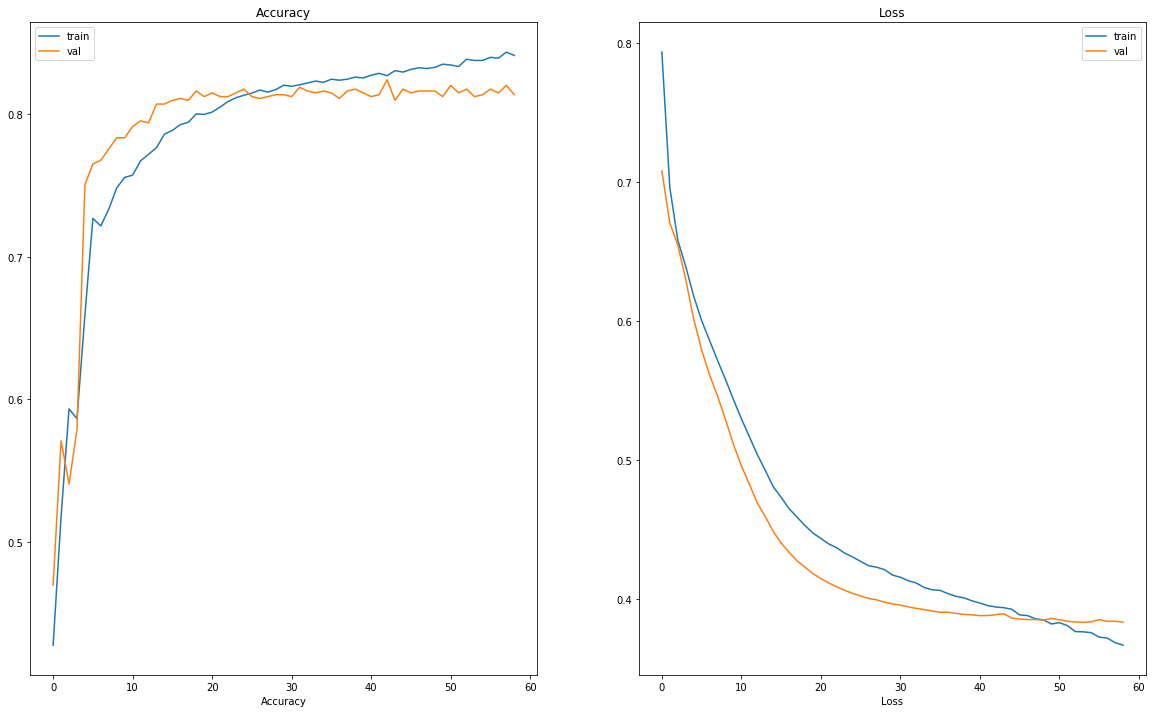

In [29]:
# Plot performance evolution metrics
fig, ax = plt.subplots(1,2, figsize=(20, 12))

# Accuracy
ax[0].plot(hist.history['acc'], label='train')
ax[0].plot(hist.history['val_acc'], label='val')
ax[0].set_xlabel('Epochs')
ax[0].set_xlabel('Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(hist.history['loss'], label='train')
ax[1].plot(hist.history['val_loss'], label='val')
ax[1].set_xlabel('Epochs')
ax[1].set_xlabel('Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.show()

Predict tests

In [39]:
y_pred = mlp_model.predict(X_test_vect)
y_pred

array([[0.871916  ],
       [0.934868  ],
       [0.80780846],
       ...,
       [0.97993934],
       [0.84976596],
       [0.87949026]], dtype=float32)

In [32]:
(X_test.shape, X_test_vect.shape, y_pred.shape)

((3263,), (3263, 768), (3263, 1))

In [40]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
y_pred = y_pred.squeeze().astype('int8')
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [44]:
# Merge index and labels in dataframe
pred_out = pd.DataFrame({'id':test['id'], 'target': y_pred})
pred_out

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [45]:
pred_out.to_csv('BERT_trans_mlp_pred_out.csv', index=False)